# Import of packages

In [1]:
'''To install the required packages that are not included in Colaboratory.'''
#Installation of packages that are not included in Colaboratory
!pip install kneed
!pip install osmnx

'''To install a specific version of the matplotlib package.'''
!pip install matplotlib==3.1.3

'''To import the required packages.'''
import pandas as pd
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import os
import matplotlib.image as mpimg

from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import osmnx as ox

  Using cached matplotlib-3.4.1-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp38-cp38-macosx_10_9_x86_64.whl (13.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

osmnx 1.0.1 requires matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.


/Users/pol/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Settings

In [2]:
'''To display all output results of a Jupyter cell.'''
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
'''To ensure that the output results of extensive output results are not truncated.'''
#pd.options.display.max_rows = 4000

'To ensure that the output results of extensive output results are not truncated.'

# File locations


In [4]:
'''If your computer is a Windows and that you are using the file locally (repository_loc == os.getcwd()) put True, False otherwise'''
windows_locally = False 

'If your computer is a Windows and that you are using the file locally (repository_loc == os.getcwd()) put True, False otherwise'

In [5]:
'''Register the GitHub link or the file relative location (select one)'''
#the Github link
#repository_loc, windows_locally = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main", False
#the local link
repository_loc = os.getcwd()

'Register the GitHub link or the file relative location (select one)'

In [6]:
'''Get the other folder locations'''

stops_cleaned_loc = repository_loc + '/stops_cleaned/'
df_for_edges_loc = repository_loc + '/df_for_edges/'
routes_loc = repository_loc + '/routes/'
coutries_train_networks_loc = repository_loc + '/countries_train_networks'
images_loc = repository_loc + '/images/'

if windows_locally:
    stops_cleaned_loc = stops_cleaned_loc.replace('/', " \\ ").replace(' ', "")
    df_for_edges_loc = df_for_edges_loc.replace('/', " \\ ").replace(' ', "")
    routes_loc = routes_loc.replace('/', " \\ ").replace(' ', "")    
    coutries_train_networks_loc = coutries_train_networks_loc.replace('/', "\\ ").replace(' ', "") 
    images_loc = images_loc.replace('/', "\\ ").replace(' ', "") 

'Get the other folder locations'

# Import of the DataFrames

In [7]:
''' To import the df_for_edges dfs'''
df_for_edges_Belgium = pd.read_csv( df_for_edges_loc + 'df_for_edges_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
df_for_edges_Netherlands = pd.read_csv(df_for_edges_loc + 'df_for_edges_Netherlands.csv', sep=",").drop(columns = ['Unnamed: 0'])
df_for_edges_Switzerland = pd.read_csv(df_for_edges_loc + 'df_for_edges_Switzerland.csv', sep=",").drop(columns = ['Unnamed: 0'])

' To import the df_for_edges dfs'

In [8]:
''' To import the stops_cleaned df'''
stops_cleaned_Belgium = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
stops_cleaned_Netherlands = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Netherlands.csv', sep=",")
stops_cleaned_Switzerland = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Switzerland.csv', sep=",")

' To import the stops_cleaned df'

In [9]:
''' To import routes df'''
belgian_routes_Belgium = pd.read_csv(routes_loc + 'belgian_routes_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
dutch_routes_Netherlands = pd.read_csv(routes_loc + 'dutch_routes_Netherlands.csv', sep=",").drop(columns = ['Unnamed: 0'])
swiss_routes_Switzerland = pd.read_csv(routes_loc + 'swiss_routes_Switzerland.csv', sep=",").drop(columns = ['Unnamed: 0'])

' To import routes df'

# Research question 1: How similar are railway systems in terms of their global network metrics? Comparison of the railway systems in space-of-stops representation

## Functions

In [10]:
''' To construct the network graph for the country '''
def create_graph(df_for_edges):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df_for_edges, 'stop_name_1', 'stop_name_2')
    return G

' To construct the network graph for the country '

In [11]:
''' To assign weights to the network graph for the country'''
def assign_weights (G, df_for_edges, stops_cleaned):
    # To assign node weights to graph
    for i in range(len(stops_cleaned)):
        for n, d in G.nodes(data=True):
            if stops_cleaned.stop_name[i] == n:
                G.nodes[n]['id']=stops_cleaned.stop_id[i]
                G.nodes[n]['latitude']=stops_cleaned.stop_lat[i]
                G.nodes[n]['longitude']=stops_cleaned.stop_lon[i]
                G.nodes[n]['country']=stops_cleaned.country[i]

    # To assign edge weights to the graph: the edge weight represents a list that contains all route_ids that cover that edge
    routes_on_edge = {}
    for node1,node2, edgeData in G.edges(data = True):
        if (node1, node2) not in routes_on_edge:
                routes_on_edge[(node1, node2)] = set()
        route_id_node1_node2= df_for_edges[(df_for_edges['stop_name_1'] == node1 ) & (df_for_edges['stop_name_2'] == node2 )]['route_id']
        route_id_node2_node1= df_for_edges[(df_for_edges['stop_name_1'] == node2 ) & (df_for_edges['stop_name_2'] == node1 )]['route_id']
        for route_id in pd.concat([route_id_node1_node2, route_id_node2_node1]):
            routes_on_edge[(node1, node2)].add(route_id)
        edgeData['route_id'] = routes_on_edge[(node1, node2)] 

    return G

' To assign weights to the network graph for the country'

In [12]:
'''Calculates the average degree'''
def avg_degree(G):
    sum_degrees = 0
    for n in G.nodes():
        sum_degrees += G.degree[n]
    return (sum_degrees/len(G.nodes()))

'Calculates the average degree'

In [13]:
'''Calculates the gamma index'''
def gamma_index(G):
    return len(G.edges()) / (3*(len(G.nodes()) - 2))

'Calculates the gamma index'

In [14]:
''' The degree distribution of the country railway system'''
def degree_distribution(G):

    #Sort degree values
    degree_sequence=sorted([d for n, d in G.degree()], reverse=True)

    #Count number of frequences of degree values
    degreeCount=collections.Counter(degree_sequence)

    #Define variables deg and cnt and probability
    deg, cnt = zip(*degreeCount.items())
    probability = []
    for v in cnt:
        pv= v/len(G.nodes())
        probability.append(pv)

    #plot degree probability histogram
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, probability, width=0.95, color='lightgrey')

    #plot degree distribution
    plt.plot(deg, probability, color="b")

    #graph settings
    plt.title("Degree distribution")
    plt.ylabel("P (k)")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    #count
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, cnt, width=0.95, color='lightgrey')

    plt.plot(deg, cnt, color="b")

    #graph settings
    plt.title("Degree count")
    plt.ylabel("Count")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

' The degree distribution of the country railway system'

In [15]:
'''Creates the railway network (using the self-made Networkx graph) of the country on the country map in red. 
The white on that map is the actual railway network given by OpenStreetmaps'''

import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

def plot_given_Networkx_on_country_map(country_Networkx, country_name, country_names, dic_country_networks, dic_country_names):
    
    train_network = dic_country_networks[country_names[0]]
    country_shape = ox.geocode_to_gdf(dic_country_names[country_names[0]])
    for country in country_names[1:]:
        country_shape = pd.concat([country_shape, ox.geocode_to_gdf(dic_country_names[country])])
        train_network = nx.compose(train_network, dic_country_networks[country])

    #create an empty list of edges
    list_edges = []
    
    #add each edge to the list, by finding both of its nodes in the given OpenStreetMaps network and highlighting them
    #and finding the shortest routes between each pair of edges to highlight that route as well
    for node1,node2 in country_Networkx.edges():
        orig = ox.get_nearest_node(train_network, (country_Networkx.nodes[node1]['latitude'], country_Networkx.nodes[node1]['longitude']))
        dest = ox.get_nearest_node(train_network, (country_Networkx.nodes[node2]['latitude'], country_Networkx.nodes[node2]['longitude']))
        try:
            list_edges.append(nx.shortest_path(train_network, orig, dest))
        except nx.NetworkXNoPath:
            print(f'No path between {node1} and {node2}')
            continue

    #put the self-made railway network as a graph in red
    fig, ax = ox.plot_graph_routes(train_network, list_edges, route_color = 'r', route_linewidth = 1, show=False, close=False, edge_color='#111111', node_color='#111111', node_size=0.2, bgcolor='w')

    #plot the country on the top of the self-made railway network
    country_shape.plot(ax=ax, color='#111111', alpha=0.4)

    plt.savefig(f'{images_loc}{country_name}_Network.png') 
    plt.show()

'Creates the railway network (using the self-made Networkx graph) of the country on the country map in red. \nThe white on that map is the actual railway network given by OpenStreetmaps'

## Download the train networks of all the counties of interest

### Functions

In [16]:
'''Download all the countries train networks and store it as .gpickles files'''

def download_countries_train_Networks(dic_country_names, coutries_train_networks_loc):
    for country, osm_request in dic_country_names.items():
        train_country = ox.graph_from_place(osm_request,
                                            retain_all=False, truncate_by_edge=True, simplify=True,
                                            custom_filter='["railway"~"rail"]')
        nx.write_gpickle(train_country, f'{coutries_train_networks_loc}/train_{country}.gpickle')
    

'Download all the countries train networks and store it as .gpickles files'

In [17]:
'''Retrieve all the countries train networks and put it in the dic_country_networks dictionnary'''

def retrieve_countries_train_Networks(dic_country_names, coutries_train_networks_loc):
    dic_country_networks = {}
    for country in dic_country_names:
        train_country = nx.read_gpickle(f'{coutries_train_networks_loc}/train_{country}.gpickle')
        dic_country_networks[country] = train_country
    return dic_country_networks
    

'Retrieve all the countries train networks and put it in the dic_country_networks dictionnary'

### Acutal download

In [18]:
'''Create a dictionary with all the countries of interest'''
dic_country_names = {'Netherlands' : ['South Holland, Netherlands',{'state':'Utrecht', 'country':'Netherlands'},'North Brabant, Netherlands', 'Limburg, Netherlands','Gelderland, Netherlands', 'Overijssel, Netherlands','Drenthe, Netherlands', 'Groningen, Netherlands', 'Friesland, Netherlands', 'Flevoland, Netherlands', 'North Holland, Netherlands'],
                    'Belgium': ['Belgium'], 'Switzerland': ['Switzerland'], 'France': ['Metropolitan France'],
                    'Luxembourg': ['Luxembourg'], 'Germany': ['Germany'], 'Austria': ['Austria'], 'Italy': ['Italy'],
                    'Liechtenstein': ['Liechtenstein'], 'United_Kingdom': ['United Kingdom']}

'Create a dictionary with all the countries of interest'

In [19]:
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO DOWNLOAD THE COUNTRIES TRAIN NETWORKS FROM OSM, BUT IT TAKES A LONG TIME
#download_countries_train_Networks(dic_country_names, coutries_train_networks_loc)

In [20]:
dic_country_networks = retrieve_countries_train_Networks(dic_country_names, coutries_train_networks_loc)

## Acutal calculation of the global characteristics of the railway systems in the space-of-stops representation

### Belgium

In [21]:
B = create_graph(df_for_edges_Belgium)
B = assign_weights (B, df_for_edges_Belgium, stops_cleaned_Belgium)

In [22]:
'''Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'''
belgian_stops = [n for n,v in B.nodes(data=True) if v['country'] == 'Belgium']
B_belgian_stops = B.subgraph(belgian_stops)

'Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

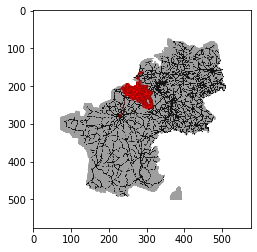

In [23]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Belgium'
country_names = ['France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(B, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

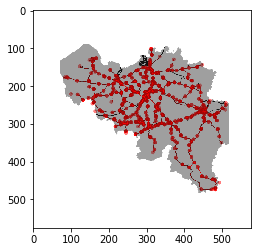

In [24]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Belgium_only'
country_names = ['Belgium']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(B_belgian_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [25]:
B.edges(data=True)

EdgeDataView([('MOUSCRON', 'HERSEAUX', {'route_id': {385.0, 387.0, 389.0, 393.0, 778.0, 779.0, 780.0, 151.0, 536.0, 159.0, 160.0, 161.0, 823.0, 824.0, 700.0, 453.0, 724.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 115.0, 253.0, 383.0}}), ('MOUSCRON', 'COURTRAI', {'route_id': {764.0, 250.0, 779.0, 724.0, 343.0, 344.0, 346.0, 763.0, 252.0, 253.0}}), ('MOUSCRON', 'MOUSCRON-FRONTIERE', {'route_id': {762.0, 251.0, 250.0, 763.0, 764.0}}), ('MOUSCRON', 'INGELMUNSTER', {'route_id': {536.0}}), ('HERSEAUX', 'FROYENNES', {'route_id': {385.0, 387.0, 389.0, 393.0, 778.0, 779.0, 780.0, 151.0, 536.0, 159.0, 160.0, 161.0, 823.0, 824.0, 700.0, 453.0, 724.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 115.0, 253.0, 383.0}}), ('FROYENNES', 'TOURNAI', {'route_id': {257.0, 258.0, 385.0, 387.0, 389.0, 393.0, 778.0, 779.0, 780.0, 151.0, 536.0, 159.0, 160.0, 161.0, 823.0, 824.0, 700.0, 453.0, 724.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 115.0, 764.0, 253.0, 766.0, 383.0}}), ('FROYENNES', 'BLANDAIN-FRONTIERE

In [26]:
''' The number of nodes in the Belgian railway system '''
# The number of total nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
len(B.nodes())

# The number of belgian nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
len(B_belgian_stops.nodes())

' The number of nodes in the Belgian railway system '

606

564

In [27]:
''' The degrees of the nodes in the Belgian railway system considering only stops in Belgium'''
B_belgian_stops.degree()

' The degrees of the nodes in the Belgian railway system considering only stops in Belgium'

DegreeView({'MOUSCRON': 4, 'HERSEAUX': 2, 'FROYENNES': 3, 'TOURNAI': 3, 'KNOKKE': 1, 'DUINBERGEN': 2, 'HEIST': 2, 'BRUGES-SAINT-PIERRE': 4, 'BRUGES': 4, 'SPA-GERONSTERE': 1, 'SPA': 2, 'FRANCHIMONT': 2, 'THEUX': 2, 'JUSLENVILLE': 2, 'PEPINSTER-CITE': 2, 'PEPINSTER': 3, 'VERVIERS-CENTRAL': 2, 'GAND-SAINT-PIERRE': 7, 'DE PINTE': 3, 'DEINZE': 3, 'AARSELE': 2, 'TIELT': 2, 'LICHTERVELDE': 4, 'TORHOUT': 2, 'ZEDELGEM': 2, 'GRAMMONT': 4, 'SCHENDELBEKE': 2, 'IDEGEM': 2, 'ZANDBERGEN': 2, 'APPELTERRE': 2, 'EICHEM': 2, 'NINOVE': 2, 'OKEGEM': 2, 'IDDERGEM': 2, 'DENDERLEEUW': 5, 'ATH': 4, 'LEUZE': 2, 'CHARLEROI-SUD': 5, 'MARCHIENNE-AU-PONT': 3, 'ROUX': 2, 'COURCELLES-MOTTE': 2, 'LUTTRE': 3, 'BRUXELLES-MIDI': 9, 'BRUXELLES-CHAPELLE': 2, 'BRUXELLES-CENTRAL': 2, 'BRUXELLES-CONGRES': 2, 'BRUXELLES-NORD': 4, 'BRUXELLES-SCHUMAN': 5, 'BRUXELLES-LUXEMBOURG': 3, 'ETTERBEEK': 5, 'WATERMAEL': 2, 'BOITSFORT': 2, 'GROENENDAAL': 2, 'HOEILAART': 2, 'LA HULPE': 2, 'GENVAL': 2, 'RIXENSART': 2, 'PROFONDSART': 2, 'OTTI

In [28]:
''' The average degree of the nodes in the Belgian railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Belgian railway system that consists of all routes that cover at least one belgian station
print(avg_degree(B))

# The average degree of all the nodes in the Belgian railway system if only the belgian stations are considered
print(avg_degree(B_belgian_stops))

' The average degree of the nodes in the Belgian railway system indicating the number of directions \na commuter can take from that given station.'

2.283828382838284
2.269503546099291


In [29]:
''' The number of edges in the Belgian railway system '''
len(B.edges())

' The number of edges in the Belgian railway system considering only stops in Belgium '

692

In [30]:
''' The gamma index of the Belgian railway system '''
print(gamma_index(B))

' The gamma index of the Belgian railway system considering only stops in Belgium'

0.3818984547461369


In [31]:
''' The mean clustering coefficient of the Belgian railway system '''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(B))

' The mean clustering coefficient of the Belgian railway system considering only stops in Belgium'

mean clustering coefficient: 0.036188380742836174


' The degree distribution of the Belgian railway system considering only stops in Belgian'

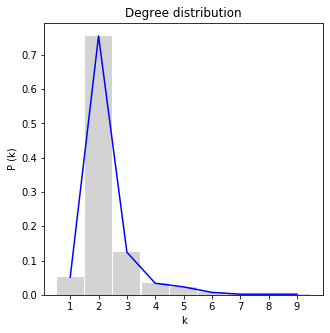

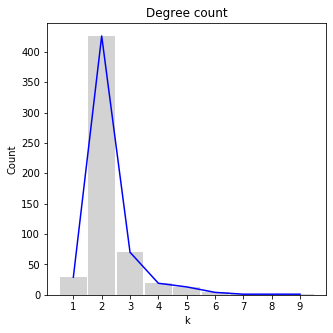

In [32]:
''' The degree distribution of the Belgian railway system considering only stops in Belgian'''
degree_distribution(B_belgian_stops)

In [33]:
''' Detection of the scale-free property in the Belgian railway system:
A PTN with the scale-free property consists of a large number of vertices 
that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Belgian railway system:\nA PTN with the scale-free property consists of a large number of vertices \nthat exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [34]:
''' The average path length of the Belgian railway system :
The average path length represents in the space_of_stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(B))

' The average path length of the Belgian railway system considering only stops in Belgium:\nThe average path length represents in the space_of_stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

21.6833756102883


In [35]:
''' The assortativity of the Belgian railway system considering only stops in Belgium:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected 
to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(B_belgian_stops))

' The assortativity of the Belgian railway system considering only stops in Belgium:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected \nto each other instead of being connected to vertices of the same kind.'

0.20729082485857414


### Netherlands

In [36]:
N = create_graph(df_for_edges_Netherlands)
N = assign_weights(N, df_for_edges_Netherlands, stops_cleaned_Netherlands)

In [37]:
'''Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'''
dutch_stops = [n for n,v in N.nodes(data=True) if v['country'] == 'Netherlands']
N_dutch_stops = N.subgraph(dutch_stops)

'Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

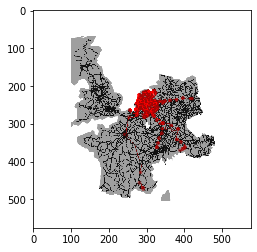

In [38]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Netherlands'
country_names = ['France', 'Belgium', 'Netherlands', 'United_Kingdom', 'Germany', 'Austria', 'Switzerland']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(N, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

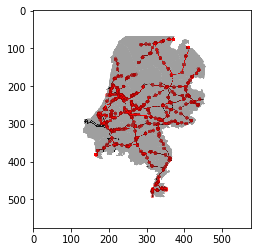

In [39]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Netherlands_only'
country_names = ['Netherlands']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(N_dutch_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [40]:
N.edges(data=True)

EdgeDataView([('AMSTERDAM CENTRAAL', 'SCHIPHOL AIRPORT', {'route_id': {59426.0, 17795.0, 77636.0, 67402.0, 66765.0, 17615.0, 17522.0, 77623.0, 75065.0, 77595.0, 77631.0}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM SLOTERDIJK', {'route_id': {17792.0, 61920.0, 76993.0, 77607.0, 41226.0, 17803.0, 46093.0, 52990.0, 77616.0, 41202.0, 17748.0, 46036.0, 52984.0, 52986.0, 17661.0, 41214.0}}), ('AMSTERDAM CENTRAAL', 'HILVERSUM', {'route_id': {77633.0, 76452.0, 67431.0, 77591.0, 77592.0, 77593.0, 17725.0}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM MUIDERPOORT', {'route_id': {61920.0, 46084.0, 77611.0, 46092.0, 17748.0}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM AMSTEL', {'route_id': {17792.0, 77616.0, 52984.0, 52986.0, 52990.0}}), ('AMSTERDAM CENTRAAL', 'UTRECHT CENTRAAL', {'route_id': {77600.0, 77601.0, 75064.0, 77603.0, 77602.0, 77637.0, 77638.0, 77639.0, 67402.0, 66765.0, 77623.0, 34264.0, 34238.0}}), ('AMSTERDAM CENTRAAL', 'ALMERE CENTRUM', {'route_id': {45189.0, 44942.0}}), ('AMSTERDAM CENTRAAL', 'HAARLEM', {

In [41]:
''' The number of nodes in the Dutch railway system '''
# The number of total nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
len(N.nodes())

# The number of dutch nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
print(len(N_dutch_stops.nodes()))

' The number of nodes in the Dutch railway system '

519

394


In [42]:
''' The degrees of the nodes in the Dutch railway system considering only stops in Netherlands'''
N_dutch_stops.degree()

' The degrees of the nodes in the Dutch railway system considering only stops in Netherlands'

DegreeView({'AMSTERDAM CENTRAAL': 12, 'SCHIPHOL AIRPORT': 9, 'ROTTERDAM CENTRAAL': 11, 'UTRECHT CENTRAAL': 18, 'GOUDA': 11, 'ROTTERDAM ALEXANDER': 4, 'LEIDEN CENTRAAL': 11, 'LEIDEN LAMMENSCHANS': 2, 'ALPHEN A/D RIJN': 3, 'BODEGRAVEN': 2, 'WOERDEN': 5, 'ALMERE OOSTVAARDERS': 2, 'ALMERE BUITEN': 4, 'ALMERE PARKWIJK': 2, 'ALMERE CENTRUM': 7, 'ALMERE MUZIEKWIJK': 2, 'ALMERE POORT': 3, 'WEESP': 4, 'DIEMEN ZUID': 2, 'DUIVENDRECHT': 7, 'AMSTERDAM RAI': 2, 'AMSTERDAM ZUID': 5, 'HOOFDDORP': 3, 'AMERSFOORT SCHOTHORST': 2, 'AMERSFOORT CENTRAAL': 10, 'DEN HAAG CENTRAAL': 5, 'ZWOLLE': 11, 'ASSEN': 4, 'GRONINGEN': 5, 'BREDA': 6, 'MEPPEL': 3, 'STEENWIJK': 3, 'WOLVEGA': 2, 'HEERENVEEN': 4, 'AKKRUM': 2, 'GROU-JIRNSUM': 2, 'LEEUWARDEN': 7, 'UTRECHT OVERVECHT': 4, 'BILTHOVEN': 2, 'DEN DOLDER': 3, 'SOEST ZUID': 2, 'SOEST': 2, 'SOESTDIJK': 2, 'BAARN': 3, 'AMERSFOORT VATHORST': 2, 'NIJKERK': 4, 'PUTTEN': 2, 'ERMELO': 2, 'HARDERWIJK': 3, 'NUNSPEET': 2, "HARDE ('T)": 2, 'WEZEP': 2, 'UTRECHT LEIDSCHE RIJN': 2,

In [43]:
''' The average degree of the nodes in the Dutch railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Dutch railway system that consists of all routes that cover at least one dutch station
print(avg_degree(N))

# The average degree of all the nodes in the Dutch railway system if only the dutch stations are considered
print(avg_degree(N_dutch_stops))

' The average degree of the nodes in the Dutch railway system indicating the number of directions \na commuter can take from that given station.'

2.6666666666666665
2.771573604060914


In [44]:
''' The number of edges in the Dutch railway system '''
len(N.edges())

' The number of edges in the Dutch railway system considering only the stops in Netherlands'

692

In [45]:
''' The gamma index of the Dutch railway system '''
print(gamma_index(N))

' The gamma index of the Dutch railway system considering only the stops in Netherlands'

0.44616376531270147


In [46]:
''' The mean clustering coefficient of the Dutch railway system '''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(N))

' The mean clustering coefficient of the Dutch railway system considering only the stops in Netherlands'

mean clustering coefficient: 0.10406279151603876


' The degree distribution of the Dutch railway system considering only stops in Netherlands'

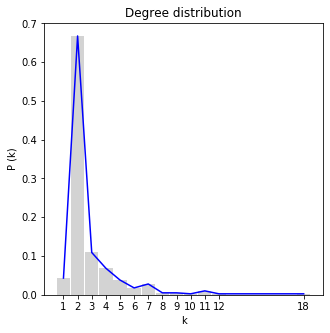

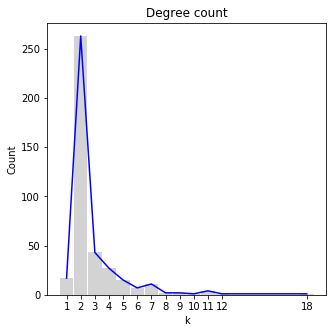

In [47]:
''' The degree distribution of the Dutch railway system considering only stops in Netherlands'''
degree_distribution(N_dutch_stops)

In [48]:
''' Detection of the scale-free property in the Dutch railway system:
A PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher")

' Detection of the scale-free property in the Dutch railway system:\nA PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher


In [49]:
''' The average path length of the Dutch railway system :
The average path length represents in the space-of-stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(N))

' The average path length of the Dutch railway system considering only the stops in Netherlands:\nThe average path length represents in the space-of-stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

9.916746639289991


In [50]:
''' The assortativity of the Dutch railway system considering only the stops in Netherlands:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected 
to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(N_dutch_stops))

' The assortativity of the Dutch railway system considering only the stops in Netherlands:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected \nto each other instead of being connected to vertices of the same kind.'

0.236557446396447


### Switzerland

In [51]:
S = create_graph(df_for_edges_Switzerland)
S = assign_weights(S, df_for_edges_Switzerland, stops_cleaned_Switzerland)

In [52]:
'''Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'''
swiss_stops = [n for n,v in S.nodes(data=True) if v['country'] == 'Switzerland']
S_swiss_stops = S.subgraph(swiss_stops)

'Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

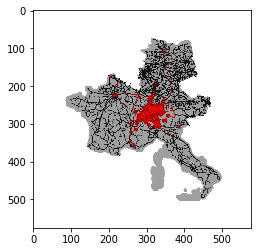

In [53]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Switzerland'
country_names = ['France', 'Germany', 'Austria', 'Switzerland', 'Italy', 'Liechtenstein']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(S, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

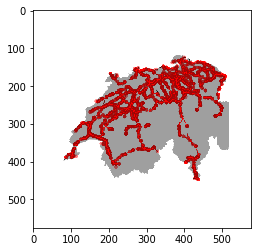

In [54]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Switzerland_only'
country_names = ['Switzerland']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(S_swiss_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [55]:
S.edges(data=True)

EdgeDataView([('LES BRENETS', 'LES FRETES', {'route_id': {'00001.000044.018:1'}}), ('LES FRETES', 'LE LOCLE LE CHALET', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE LE CHALET', 'LE LOCLE', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE', 'LE CRET-DU-LOCLE', {'route_id': {'06350.000011.101:6350', '07237.000011.101:7237', '07205.000011.101:7205'}}), ('BRIENZ BRB', 'PLANALP', {'route_id': {'00071.000104.001:71', '00001.000104.001:1'}}), ('PLANALP', 'BRIENZER ROTHORN', {'route_id': {'00001.000104.001:1'}}), ('BASEL BAD BF', 'BASEL SBB', {'route_id': {'00273.000011.104:273', '00003.000011.101:3', '00373.000011.102:373', '00471.000011.101:471', '00052.000011.101:52', '00006.000011.102:6', '00006.000011.101:6', '05320.000011.105:5320', '00151.000011.101:151', '00004.000011.102:4', '00003.000011.107:3'}}), ('BASEL BAD BF', 'HAMBURG-ALTONA', {'route_id': {'00273.000011.104:273'}}), ('BASEL BAD BF', 'RHEINFELDEN (BADEN)', {'route_id': {'19', '03040.800693.004:3040', '03049.800693.001:304

In [56]:
''' The number of nodes in the Swiss railway system '''
# The number of total nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
len(S.nodes())

# The number of swiss nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
print(len(S_swiss_stops.nodes()))

' The number of nodes in the Swiss railway system '

1901

1704


In [57]:
''' The degrees of the nodes in the Swiss railway system considering only stops in Switzerland'''
S_swiss_stops.degree()

' The degrees of the nodes in the Swiss railway system considering only stops in Switzerland'

DegreeView({'LES BRENETS': 1, 'LES FRETES': 2, 'LE LOCLE LE CHALET': 2, 'LE LOCLE': 2, 'BRIENZ BRB': 1, 'PLANALP': 2, 'BRIENZER ROTHORN': 1, 'BASEL BAD BF': 3, 'BASEL SBB': 12, 'HAUENSTEIN-BASISTUNNEL': 2, 'ZURICH HB': 23, 'ZIMMERBERG-BASISTUNNEL': 3, 'SARGANS': 9, 'LANDQUART': 11, 'CHUR': 14, 'TASCH': 2, 'ZERMATT': 2, 'STE-CROIX': 1, 'SIX-FONTAINES': 2, 'BAULMES': 2, 'VUITEBOEUF': 2, 'ESSERT-SOUS-CHAMPVENT': 2, 'VALEYRES-SOUS-MONTAGNY': 2, 'LA BRINAZ': 3, 'YVERDON-LES-BAINS': 10, 'YVERDON WILLIAM BARBEY': 2, 'ALPNACHSTAD PB': 1, 'AEMSIGEN': 2, 'PILATUS KULM': 1, 'BLONAY': 5, 'CHAMBY': 5, 'CHAMBY-MUSEE': 2, 'INTERLAKEN OST': 5, 'INTERLAKEN WEST': 2, 'SPIEZ': 8, 'THUN': 8, 'BERN': 25, 'BAHN-2000-STRECKE': 5, 'OLTEN': 25, 'LIESTAL': 7, 'AIGLE': 8, 'AIGLE-HOPITAL': 2, 'ST-TRIPHON-VILLAGE': 2, 'OLLON VD': 2, 'LES ARNOUX': 2, 'VILLY': 2, 'ST-TRIPHON-GARE': 2, 'PONT DU RHONE': 2, 'CORBIER': 2, 'COLLOMBEY-MURAZ': 2, 'MONTHEY-EN PLACE': 3, 'MONTHEY-VILLE': 1, 'MONTHEY-HOPITAL': 2, 'CHEMEX': 2,

In [58]:
''' The average degree of the nodes in the Swiss railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Swiss railway system that consists of all routes that cover at least one Swiss station
print(avg_degree(S))

# The average degree of all the nodes in the Swiss railway system if only the Swiss stations are considered
print(avg_degree(S_swiss_stops))

' The average degree of the nodes in the Swiss railway system indicating the number of directions \na commuter can take from that given station.'

2.689110994213572
2.6737089201877935


In [59]:
''' The number of edges in the Swiss railway system '''
len(S.edges())

' The number of edges in the Swiss railway system considering only stops in Switzerland'

2556

In [60]:
''' The gamma index of the Swiss railway system '''
print(gamma_index(S))

' The gamma index of the Swiss railway system considering only stops in Switzerland'

0.4486571879936809


In [61]:
''' The mean clustering coefficient of the Swiss railway system '''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(S))

' The mean clustering coefficient of the Swiss railway system considering only stops in Switzerland'

mean clustering coefficient: 0.1584090006903548


' The degree distribution of the Swiss railway system considering only stops in Switzerland'

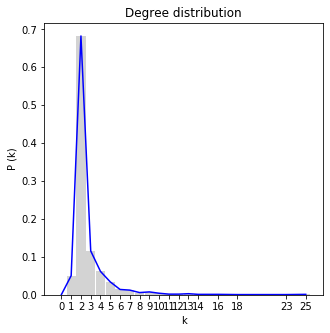

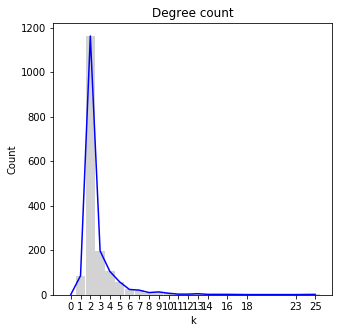

In [62]:
''' The degree distribution of the Swiss railway system considering only stops in Switzerland'''
degree_distribution(S_swiss_stops)

In [63]:
''' Detection of the scale-free property in the Swiss railway system:
A PTN with the scale-free property consists of a large number of vertices 
that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Swiss railway system:\nA PTN with the scale-free property consists of a large number of vertices \nthat exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [64]:
'''Separate all the connected subgraphs of Switzerland. And see what we lose by only taking the largest one.'''
all_connected_graphs = nx.connected_components(S)
largest_component = max(nx.connected_components(S), key=len)
largest_connected_subgraph = S.subgraph(largest_component)
lost_number_nodes = len(S.nodes()) - len(largest_connected_subgraph)
print(f'lost number of nodes: {lost_number_nodes}')
list_subgraphs_except_max = []
for sg in all_connected_graphs:
    if sg != largest_component:
        list_subgraphs_except_max.append(sg)

set_deleted_routes = set()
for sg in list_subgraphs_except_max:
    for n1, n2, edge_data in S.subgraph(sg).edges(data=True):
        set_deleted_routes.update(edge_data['route_id'])
        
print(f'lost number of routes: {len(set_deleted_routes)}')

'Separate all the connected subgraphs of Switzerland. And see what we lose by only taking the largest one.'

lost number of nodes: 163
lost number of routes: 56


In [65]:
''' The average path length of the Swiss railway system :
The average path length represents in the space-of-stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(largest_connected_subgraph))

' The average path length of the Swiss railway system considering only stops in Switzerland:\nThe average path length represents in the space-of-stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

11.943739884580706


In [66]:
''' The assortativity of the Swiss railway system considering only stops in Switzerland:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(S_swiss_stops))

' The assortativity of the Swiss railway system considering only stops in Switzerland:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'

0.23351210374488046


# RQ2: comparison of the Belgian NMBS/SNCB, the Dutch NS and the Swiss SBB railway systems in terms of the average planned travel time of similar routes

## Clustering preparation

### Functions

In [67]:
''' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'''
def create_route_characteristics(df_for_edges):
    # To create a list of all unique route_ids in the df_for_edges dataset
    routes_list = list(df_for_edges['route_id'].unique())
    routes_list.sort()

    # To create a dataframe that contains the values in the route_characteristics_Belgium_dic as the values in the first column'''
    route_characteristics = pd.DataFrame(routes_list, columns=['route_id'])
    return route_characteristics

' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'

In [68]:
''' To put the stations per route_id in df route_characteristics_Belgium'''
def put_stations_route_characteristics(G, route_characteristics):
    # To construct a new column of the route_characteristics_Belgium dataset that has for every column value an empty set
    route_characteristics['nodes'] = [set() for _ in range(len(route_characteristics))]

    # To put the two nodes of an edge in the nodes column of the route_characteristics_Belgium dataset if the route_id of the corresponding row 
    # is present in the set of the list values of the corresponding edge that contains all route_ids that contain the edge
    for node1, node2 in G.edges():
        route_characteristics[['route_id','nodes']].apply(lambda x: x['nodes'].update((node1, node2)) if x['route_id'] in set(G.get_edge_data(node1, node2)['route_id']) else x, axis = 1)
    return route_characteristics

' To put the stations per route_id in df route_characteristics_Belgium'

In [69]:
'''Deletes every empty route (useful after a inside contry filter)'''
def deletes_empty_routes(route_characteristics):
    index_empty_routes = route_characteristics_Belgium_belgian_nodes[route_characteristics_Belgium_belgian_nodes['nodes'].map(lambda d: len(d)) == 0].index
    return route_characteristics.drop(index_empty_routes)

'Deletes every empty route (useful after a inside contry filter)'

In [70]:
''' Definitions to calculate route topological metrics'''

# The inputs of the get_metric_list function are a dictionary that contains for all node keys the corresponding metric values and a specific route_id of a column of 
# the route_characteristics dataset
# A new empty list metric_list is created for these inputs
# For the nodes that are in the route_characteristics dataset corresponding to this route_id, the corresponding metric values from the dictionary get appended to metric_list

from statistics import mean
def get_metric_list(route_characteristics, metric_dic, route_id):
    """this is a sub function that is used in calculate_metric_route_per_node"""
    metric_list = []
    for nodes in route_characteristics[route_characteristics['route_id'] == route_id]['nodes']:
        for node in nodes:
            metric_list.append(metric_dic[node])
    return metric_list

# For the metric, a new column is created in route_characteristics, where every column value consists of an empty list
# The values in the column of the df are determined by giving the metric_dic and the route_id of the row where that value is placed to the get_metric_list function
# The metric_list ultimately contains the metric values for a specific metric for all the stations corresponding to that route

def calculate_metric_route_per_node(route_characteristics, metric_dic, metric_name):
    """puts the metrics of each node of a route in a list in the route_characteristics df"""
    route_characteristics[metric_name] = [list for _ in range(len(route_characteristics))]
    route_characteristics[metric_name] = route_characteristics.apply(lambda x: get_metric_list(route_characteristics, metric_dic, x['route_id']) , axis = 1)
    
# The function starts from the metric_name, the original_metric_name and the aggregation_method inputs
# A new column named with the metric_name is created: initially it contains all NaN values
# Thereafter the aggregation_method is taken into account. The avg aggregation method returns for all column values the mean of the values in the corresponding row
# of the original_metric_name list. The max aggregation method returns for all column values the max of the values in the corresponding row of the original_metric_name list.

def calculate_metric_aggregation_route(route_characteristics, metric_name, original_metric_name, aggregation_method):
    '''calculate the metric aggregation of the routes, only avg and max are supported as string values for aggregation method
    metric_name is the aggregation column name and original_metric_name is the node metric column name'''
    route_characteristics[metric_name] = np.nan
    if aggregation_method == 'avg':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: mean(x[original_metric_name]) , axis = 1)
    elif aggregation_method == 'max':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: max(x[original_metric_name]) , axis = 1)

' Definitions to calculate route topological metrics'

In [71]:
'''Calculate the metrics of the route_characteristics df'''
def calculate_characteristics (G, route_characteristics):
    calculate_metric_route_per_node(route_characteristics, dict(G.degree()), 'node_degree')
    calculate_metric_aggregation_route(route_characteristics, 'avg_degree', 'node_degree', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_degree', 'node_degree', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.clustering(G)), 'node_clustering')
    calculate_metric_aggregation_route(route_characteristics, 'avg_clustering', 'node_clustering', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_clustering', 'node_clustering', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.closeness_centrality(G)), 'node_closeness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_closeness_centrality', 'node_closeness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_closeness_centrality', 'node_closeness_centrality', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.betweenness_centrality(G)), 'node_betweenness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_betweenness_centrality', 'node_betweenness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_betweenness_centrality', 'node_betweenness_centrality', 'max')
    return route_characteristics

'Calculate the metrics of the route_characteristics df'

In [72]:
''' To add the number of stations present in the stop sequence of a route_id'''
def add_number_stations(route_characteristics):
    number_stations = []
    for number_stops in route_characteristics['nodes']:
        number_stations.append(len(number_stops))

    route_characteristics['len_stop_sequence'] = number_stations
    return route_characteristics

' To add the number of stations present in the stop sequence of a route_id'

In [73]:
''' To add the absolute distances between the starting and the ending station of all routes, and waiting and travel time'''

def add_absolute_distance_tt_wt(route_characteristics, routes_country):

    route_characteristics = route_characteristics.merge(routes_country[['route_id', 'distance','travel_time', 'waiting_time']], on='route_id')
    route_characteristics = route_characteristics.rename(columns = {'distance': 'absolute_distance'})
    return route_characteristics

' To add the absolute distances between the starting and the ending station of all routes, and waiting and travel time'

In [74]:
''' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'''

def add_relative_distance (route_characteristics):
    # The relative distance of a route is the distance of the route divided by the distance of the route with the longest distance
    relative_distance = []

    # To calculate the route which stop sequence has the greatest absolute distance
    max_distance = route_characteristics['absolute_distance'].max()

    # To calculate the relative distance of each route
    for abs_distance in route_characteristics['absolute_distance']:
        rel_distance = abs_distance / max_distance
        relative_distance.append(rel_distance)

    # To add the relative_distance list as a column to the route_characteristics dataset
    route_characteristics['relative_distance'] = relative_distance
    return route_characteristics

' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'

In [75]:
''' To add the absolute distances between the starting and the ending station of all routes'''

# Remember that geographical locations that are located further away to the right of the Prime Meridian Greenwich instead of another location that is closer
# (but still to the right) of this Meridian Greenwich, have a greater longitute value.
# Remember that geographical locations that are higher above the Equator than other geographical locations (that are also above the Equator), have a 
# higher latitude value

def add_absolute_distance_begin_end(route_characteristics, df_for_edges, stops_cleaned):

    absolute_distance = []
    for route in route_characteristics['route_id']:
        subdf_stop_sequence = df_for_edges[df_for_edges['route_id'] == route]
        number_of_rows = len(subdf_stop_sequence.index)

        # To get the starting station and the ending_station of the stop sequence of a route
        starting_station = subdf_stop_sequence['stop_name_1'].iloc[0]
        ending_station = subdf_stop_sequence['stop_name_2'].iloc[number_of_rows - 1]

        # The radius of the earth
        R = 6373.0

        # To convert the coordinates in radians 
        lat_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lat'].iloc[0])
        lon_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lon'].iloc[0])
        lat_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lat'].iloc[0])
        lon_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lon'].iloc[0])

        # To calculate the change in coordinates
        dlon = lon_ending_station - lon_starting_station
        dlat = lat_ending_station - lat_starting_station

        # To use the Haversine formula to get the distance in kilometers between the starting_station and the ending_station
        a = math.sin(dlat / 2)**2 + math.cos(lat_starting_station) * math.cos(lat_ending_station) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        # To calculate the distance
        distance = R * c

        # To add the distance in the absolute_distance list
        absolute_distance.append(distance)

    # To add the absolute_distance list as a column to the route_characteristics dataset
    route_characteristics['absolute_distance_begin_end'] = absolute_distance
    return route_characteristics

' To add the absolute distances between the starting and the ending station of all routes'

### Actual clustering preparation

#### Belgium

In [76]:
'''Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'''
belgian_stops = [n for n,v in B.nodes(data=True) if v['country'] == 'Belgium']
B_belgian_stops = B.subgraph(belgian_stops)

'Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'

In [77]:
route_characteristics_Belgium = create_route_characteristics(df_for_edges_Belgium)
route_characteristics_Belgium = put_stations_route_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = calculate_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = add_number_stations(route_characteristics_Belgium)
route_characteristics_Belgium = add_absolute_distance_tt_wt(route_characteristics_Belgium, belgian_routes_Belgium)
route_characteristics_Belgium = add_relative_distance (route_characteristics_Belgium)
route_characteristics_Belgium = add_absolute_distance_begin_end(route_characteristics_Belgium, df_for_edges_Belgium, stops_cleaned_Belgium)

In [78]:
route_characteristics_Belgium

route_id                                              nodes  \
0       115.0           {MOUSCRON, FROYENNES, HERSEAUX, TOURNAI}   
1       116.0  {DUINBERGEN, BRUGES, HEIST, KNOKKE, BRUGES-SAI...   
2       117.0  {SPA, VERVIERS-CENTRAL, PEPINSTER-CITE, FRANCH...   
3       118.0  {TORHOUT, AARSELE, TIELT, DUINBERGEN, LICHTERV...   
4       119.0  {SCHENDELBEKE, EICHEM, DENDERLEEUW, NINOVE, ID...   
..        ...                                                ...   
564     823.0  {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUX...   
565     824.0  {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUX...   
566     825.0  {OUDEGEM, KWATRECHT, WETTEREN, MELLE, COURTRAI...   
567     826.0  {BRUXELLES-CONGRES, FAMILLEUREUX, BRAINE-LE-CO...   
568     827.0  {COMINES, WIJGMAAL, MUIZEN, MELLE, SCHAERBEEK,...   

                                           node_degree  avg_degree  \
0                                         [4, 3, 2, 3]    3.000000   
1                                      [2, 4, 2, 1, 4]    2.600000   
2                             [2, 2, 2, 2, 3, 2, 2, 1]    2.000000   
3              [2, 2, 2, 2, 4, 4, 7, 2, 3, 1, 3, 2, 4]    2.923077   
4                       [2, 2, 5, 2, 2, 2, 4, 2, 2, 2]    2.500000   
..                                                 ...         ...   
564  [2, 2, 2, 5, 2, 4, 1, 3, 2, 5, 2, 2, 2, 3, 2, ...    3.000000   
565  [2, 2, 2, 5, 2, 4, 2, 5, 2, 2, 2, 3, 2, 2, 2, ...    3.103448   
566      [2, 2, 2, 5, 5, 3, 3, 2, 7, 2, 3, 4, 2, 3, 2]    3.133333   
567  [2, 3, 3, 5, 2, 4, 4, 2, 2, 2, 1, 3, 3, 2, 2, ...    2.826923   
568  [2, 2, 4, 5, 8, 2, 3, 5, 2, 2, 7, 3, 6, 3, 2, ...    2.895833   

     max_degree                                    node_clustering  \
0             4                     [0.16666666666666666, 0, 0, 0]   
1             4                                    [0, 0, 0, 0, 0]   
2             3                           [0, 0, 0, 0, 0, 0, 0, 0]   
3             7  [0, 0, 0, 0, 0, 0, 0.09523809523809523, 0, 0, ...   
4             5                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
..          ...                                                ...   
564           9  [0, 0, 0, 0.3, 0, 0.16666666666666666, 0, 0.66...   
565           9  [0, 0, 0, 0.3, 0, 0.16666666666666666, 0, 0.2,...   
566           7  [0, 0, 0, 0.1, 0.1, 0.3333333333333333, 0, 0, ...   
567           9  [0, 0.3333333333333333, 0, 0.3, 0, 0.166666666...   
568           8  [0, 0, 0.16666666666666666, 0.1, 0.14285714285...   

     avg_clustering  max_clustering  \
0          0.041667        0.166667   
1          0.000000        0.000000   
2          0.000000        0.000000   
3          0.007326        0.095238   
4          0.000000        0.000000   
..              ...             ...   
564        0.114335        1.000000   
565        0.068692        0.500000   
566        0.041905        0.333333   
567        0.116514        1.000000   
568        0.036905        0.500000   

                             node_closeness_centrality  \
0    [0.05051348417800785, 0.050627615062761505, 0....   
1    [0.039813108712819165, 0.04513578036407043, 0....   
2    [0.035873109991105843, 0.04182509505703422, 0....   
3    [0.049339422606426354, 0.05644183226047206, 0....   
4    [0.04726931791546215, 0.050274223034734916, 0....   
..                                                 ...   
564  [0.06808462750393877, 0.05467196819085487, 0.0...   
565  [0.06808462750393877, 0.05467196819085487, 0.0...   
566  [0.053577754162238755, 0.06087744012879855, 0....   
567  [0.06808462750393877, 0.052069885532317756, 0....   
568  [0.0417442903470641, 0.060651629072681706, 0.0...   

     avg_closeness_centrality  max_closeness_centrality  \
0                    0.050737                  0.052700   
1                    0.041586                  0.045136   
2                    0.039217                  0.043604   
3                    0.050319                  0.065747   
4                    0.051627                

#### Netherlands

In [79]:
'''Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'''
dutch_stops = [n for n,v in N.nodes(data=True) if v['country'] == 'Netherlands']
N_dutch_stops = N.subgraph(dutch_stops)

'Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'

In [80]:
route_characteristics_Netherlands = create_route_characteristics(df_for_edges_Netherlands)
route_characteristics_Netherlands = put_stations_route_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = calculate_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = add_number_stations(route_characteristics_Netherlands)
route_characteristics_Netherlands = add_absolute_distance_tt_wt(route_characteristics_Netherlands, dutch_routes_Netherlands)
route_characteristics_Netherlands = add_relative_distance (route_characteristics_Netherlands)
route_characteristics_Netherlands = add_absolute_distance_begin_end(route_characteristics_Netherlands, df_for_edges_Netherlands, stops_cleaned_Netherlands)

In [81]:
route_characteristics_Netherlands

route_id                                              nodes  \
0     17522.0  {ROTTERDAM CENTRAAL, SCHIPHOL AIRPORT, AMSTERD...   
1     17562.0  {ROTTERDAM CENTRAAL, UTRECHT CENTRAAL, GOUDA, ...   
2     17573.0  {BODEGRAVEN, UTRECHT CENTRAAL, LEIDEN LAMMENSC...   
3     17599.0  {SCHIPHOL AIRPORT, ALMERE BUITEN, ALMERE OOSTV...   
4     17601.0  {UTRECHT CENTRAAL, AMERSFOORT CENTRAAL, AMERSF...   
..        ...                                                ...   
190   77642.0  {DALFSEN, HARDENBERG, ZWOLLE, OMMEN, EMMEN, EM...   
191   77643.0      {LEEUWARDEN, ZUIDHORN, FEANWALDEN, GRONINGEN}   
192   77644.0                   {SNEEK, SNEEK NOORD, LEEUWARDEN}   
193   77645.0  {SCHEEMDA, KROPSWOLDE, ZUIDBROEK, MARTENSHOEK,...   
194   77646.0  {ANTWERPEN-CENTRAAL, MECHELEN, BRUSSEL-NOORD, ...   

                                 node_degree  avg_degree  max_degree  \
0                                [13, 9, 12]   11.333333          13   
1                            [13, 18, 11, 4]   11.500000          18   
2                       [2, 18, 2, 11, 5, 3]    6.833333          18   
3    [9, 4, 2, 7, 2, 5, 4, 7, 3, 2, 2, 2, 3]    4.000000           9   
4                         [18, 10, 2, 5, 11]    9.200000          18   
..                                       ...         ...         ...   
190                   [2, 4, 11, 3, 1, 3, 5]    4.142857          11   
191                             [7, 3, 5, 5]    5.000000           7   
192                                [2, 3, 7]    4.000000           7   
193              [3, 2, 3, 2, 2, 4, 2, 2, 5]    2.777778           5   
194              [5, 2, 2, 6, 7, 3, 2, 2, 2]    3.444444           7   

                                       node_clustering  avg_clustering  \
0      [0.1282051282051282, 0.25, 0.13636363636363635]        0.171523   
1    [0.1282051282051282, 0.0457516339869281, 0.083...        0.147656   
2    [0, 0.0457516339869281, 0, 0.10909090909090909...        0.025807   
3    [0.25, 0.5, 1.0, 0.14285714285714285, 1.0, 0.4...        0.405311   
4    [0.0457516339869281, 0.044444444444444446, 0, ...        0.114706   
..                                                 ...             ...   
190  [0, 0.3333333333333333, 0.01818181818181818, 0...        0.188312   
191                  [0.047619047619047616, 0, 0.1, 0]        0.036905   
192      [0, 0.3333333333333333, 0.047619047619047616]        0.126984   
193                        [0, 0, 0, 0, 0, 0, 0, 0, 0]        0.000000   
194  [0.1, 0, 0, 0.06666666666666667, 0.04761904761...        0.023810   

     max_clustering                          node_closeness_centrality  \
0          0.250000  [0.15421256326287586, 0.1502320185614849, 0.16...   
1          0.333333  [0.15421256326287586, 0.18207381370826012, 0.1...   
2          0.109091  [0.13493097160718937, 0.18207381370826012, 0.1...   
3          1.000000  [0.1502320185614849, 0.13787596486558423, 0.12...   
4          0.400000  [0.18207381370826012, 0.17249417249417248, 0.1...   
..              ...                                                ...   
190        0.333333  [0.13482561166059345, 0.1082097346981408, 0.15...   
191        0.100000  [0.10050446255335661, 0.11089702419182187, 0.1...   
192        0.333333  [0.08402270884022708, 0.09155178508306822, 0.1...   
193        0.000000  [0.09957708573625529, 0.09942418426103647, 0.0...   
194        0.100000  [0.13482561166059345, 0.1065405183052242, 0.10...   

     avg_closeness_centrality  max_closeness_centrality  \
0                    0.157615                  0.168401   
1                    0.161036                  0.182074   
2                    0.145061                  0.182074   
3                    0.135572                  0.151906   
4                    0.161627                  0.182074   
..                        ...                       ...   
190                  0.112303                  0.154765   
191                  0.108873                  0.123333   
192           

#### Switzerland

In [82]:
'''Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'''
swiss_stops = [n for n,v in S.nodes(data=True) if v['country'] == 'Switzerland']
S_swiss_stops = S.subgraph(swiss_stops)

'Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'

In [83]:
route_characteristics_Switzerland = create_route_characteristics(df_for_edges_Switzerland)
route_characteristics_Switzerland = put_stations_route_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = calculate_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = add_number_stations(route_characteristics_Switzerland)
route_characteristics_Switzerland = add_absolute_distance_tt_wt(route_characteristics_Switzerland, swiss_routes_Switzerland)
route_characteristics_Switzerland = add_relative_distance (route_characteristics_Switzerland)
route_characteristics_Switzerland = add_absolute_distance_begin_end(route_characteristics_Switzerland, df_for_edges_Switzerland, stops_cleaned_Switzerland)

In [84]:
route_characteristics_Switzerland

route_id  \
0         00001.000044.018:1   
1         00001.000104.001:1   
2         00003.000011.101:3   
3         00003.000011.102:3   
4         00003.000011.103:3   
...                      ...   
1918  96801.000011.101:96801   
1919  96802.000011.101:96802   
1920  96804.000011.101:96804   
1921  96804.000011.102:96804   
1922  96810.000011.101:96810   

                                                  nodes  \
0     {LE LOCLE, LES BRENETS, LES FRETES, LE LOCLE L...   
1               {BRIENZER ROTHORN, BRIENZ BRB, PLANALP}   
2     {BASEL SBB, BASEL BAD BF, HAUENSTEIN-BASISTUNN...   
3     {ZIMMERBERG-BASISTUNNEL, BASEL SBB, SARGANS, Z...   
4        {BASEL SBB, HAUENSTEIN-BASISTUNNEL, ZURICH HB}   
...                                                 ...   
1918                {VALENCE, GENEVE, BELLEGARDE (AIN)}   
1919               {GRENOBLE, GENEVE, BELLEGARDE (AIN)}   
1920        {CULOZ, GRENOBLE, GENEVE, BELLEGARDE (AIN)}   
1921  {BELLEGARDE (AIN), VALENCE, GENEVE, GRENOBLE, ...   
1922         {LYON PART DIEU, GENEVE, BELLEGARDE (AIN)}   

                    node_degree  avg_degree  max_degree  \
0                  [2, 1, 2, 2]    1.750000           2   
1                     [1, 1, 2]    1.333333           2   
2                [14, 8, 2, 23]   11.750000          23   
3     [3, 14, 9, 23, 14, 11, 2]   10.857143          23   
4                   [14, 2, 23]   13.000000          23   
...                         ...         ...         ...   
1918                 [2, 11, 6]    6.333333          11   
1919                 [3, 11, 6]    6.666667          11   
1920              [2, 3, 11, 6]    5.500000          11   
1921           [6, 2, 11, 3, 2]    4.800000          11   
1922                 [2, 11, 6]    6.333333          11   

                                        node_clustering  avg_clustering  \
0                                          [0, 0, 0, 0]        0.000000   
1                                             [0, 0, 0]        0.000000   
2     [0.08791208791208792, 0.03571428571428571, 0, ...        0.048693   
3     [0, 0.08791208791208792, 0.1388888888888889, 0...        0.072277   
4         [0.08791208791208792, 0, 0.07114624505928854]        0.053019   
...                                                 ...             ...   
1918    [1.0, 0.12727272727272726, 0.13333333333333333]        0.420202   
1919  [0.6666666666666666, 0.12727272727272726, 0.13...        0.309091   
1920  [1.0, 0.6666666666666666, 0.12727272727272726,...        0.481818   
1921  [0.13333333333333333, 1.0, 0.12727272727272726...        0.585455   
1922      [0, 0.12727272727272726, 0.13333333333333333]        0.086869   

      max_clustering                          node_closeness_centrality  \
0           0.000000  [0.06665199094272933, 0.0547071238574612, 0.05...   
1           0.000000  [0.0007017543859649122, 0.0007017543859649122,...   
2           0.087912  [0.11922694528196759, 0.1188165869218501, 0.12...   
3           0.138889  [0.11947811934470894, 0.11922694528196759, 0.1...   
4           0.087912  [0.11922694528196759, 0.12045692818103058, 0.1...   
...              ...                                                ...   
1918        1.000000  [0.08424763564170654, 0.10313591506205924, 0.0...   
1919        0.666667  [0.0842521054865517, 0.10313591506205924, 0.09...   
1920        1.000000  [0.08424763564170654, 0.0842521054865517, 0.10...   
1921        1.000000  [0.0927885756813443, 0.08424763564170654, 0.10...   
1922        0.133333  [0.08426104659930629, 0.10313591506205924, 0.0...   

      avg_closeness_centrality  max_closeness_centrality  \
0                     0.060420                  0.066652   
1                     0.000819                  0.001053   
2                     0.123743                  0.136472   
3                     0.119310                  0.136472   
4                     0.125385                  0.136472   
...                        ...                       ..

## Route clustering

The route_id is an identifying but not an explanatory variable and therefore not interesting.

The max_degree attribute is chosen because a route that contains a station from which there are many directions of travel may have a longer transfer time at this stop and thus a relatively higher travel_time of the route ceteris paribus.

The clustering attribute is not interesting in the context of route clustering. Stations with a high clustering value have immediate neighboring stations that share a link between them. This may indicate that a station is sometimes skipped on this trajectory. However, from the clustering coefficient, it is not possible to tell whether the route represents the route with many or few intermediate stops.

The closeness centrality is interesting because stations that have smaller shortests paths lengths to all  other stations are more connected and therefore often more important stations. These important stations have a higher transfer time.

The betweenness centrality is interesting because stations that lie more often on the paths between other stations are more connected and therefore often more important stations. These important stations have a higher transfer time.

The len_stop_sequence attribute is interesting because a higher number of stops results in a higher total transfer time ceteris paribus.

The absolute distance is interesting because trajectories that have a longer length will also typically take more time to travel.

The relative distance is not interesting as the scaled absolute distance is the same as the relative distance.

### Functions

In [85]:
''' To select the interesting attributes for the clustering '''
def select_clustering_attributes(route_characteristics):
    clustering_df = route_characteristics[['max_degree', 'max_closeness_centrality', 'max_betweenness_centrality','len_stop_sequence', 'absolute_distance']]

    return clustering_df

' To select the interesting attributes for the clustering '

In [86]:
''' To scale all attributes such that their values are between 0 and 1 and save the result in a dataframe'''

def scale_clustering_attributes_to_df(clustering_df):
    scaled_clustering_df = clustering_df.copy()
    scaler = MinMaxScaler()

    # To scale the max_degree
    scaler.fit(scaled_clustering_df[['max_degree']])
    scaled_clustering_df['max_degree'] = scaler.transform(scaled_clustering_df[['max_degree']])

    # To scale the max_closeness_centrality
    scaler.fit(scaled_clustering_df[['max_closeness_centrality']])
    scaled_clustering_df['max_closeness_centrality'] = scaler.transform(scaled_clustering_df[['max_closeness_centrality']])

    # To scale the max_betweenness_centrality
    scaler.fit(scaled_clustering_df[['max_betweenness_centrality']])
    scaled_clustering_df['max_betweenness_centrality'] = scaler.transform(scaled_clustering_df[['max_betweenness_centrality']])

    # To scale the len_stop_sequence
    scaler.fit(scaled_clustering_df[['len_stop_sequence']])
    scaled_clustering_df['len_stop_sequence'] = scaler.transform(scaled_clustering_df[['len_stop_sequence']])

    # To scale the absolute distance
    scaler.fit(scaled_clustering_df[['absolute_distance']])
    scaled_clustering_df['absolute_distance'] = scaler.transform(scaled_clustering_df[['absolute_distance']])

    # To verify the ranges of the attributes
    scaled_clustering_df.describe()

    return scaled_clustering_df

' To scale all attributes such that their values are between 0 and 1 and save the result in a dataframe'

In [87]:
''' To scale all attributes such that their values are between 0 and 1 and save the result in an array'''

def scale_clustering_attributes_to_arr(clustering_df):

    scaler = MinMaxScaler()
    # To scale all attributes
    scaler.fit(clustering_df)
    scaled_clustering_arr = scaler.transform(clustering_df)

    return scaled_clustering_arr

' To scale all attributes such that their values are between 0 and 1 and save the result in an array'

In [88]:
''' To create a reduced array with two components '''
def create_array_two_components(scaled_arr):
    # To create the array with the specified amount of desired components from the scaled_clustering_arr
    pca = PCA(n_components=2)
    pca.fit(scaled_arr)
    x_pca = pca.transform(scaled_arr)

    return x_pca

' To create a reduced array with two components '

In [89]:
''' To create a PCA plot'''
def create_PCA_plot_one_argument(x_pca):
    plt.figure(figsize=(8,6))
    plt.scatter(x_pca[:,0], x_pca[:,1])
    plt.xlabel("First principle component")
    plt.ylabel("Second principle component")

' To create a PCA plot'

In [90]:
''' To find the optimal number of clusters'''
def optimal_number_clusters(scaled_clustering_df):
    # The elbow method starts with a certain k and computes the sum of squared errors (sum of the squared distances of points from their cluster centroids).
    # Thereafter the elbow method computes this sum of squared errors also for other values of k.
    # The optimal k is indicated by the elow on the elbow plot.

    # To specify the k range
    k_range = range(1,50)

    # To introduce the array that will contain the sum of squared errors of all models
    sse = []

    # For each iteration, a new model is created with the number of clusters equal to k
    # The sum of squared error is given by the inertia parameter
    for k in k_range:
        km = KMeans(n_clusters=k)
        km.fit(scaled_clustering_df)
        sse.append(km.inertia_)

    # To plot the elbow plot
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_range, sse)

    # To calculate the optimal number of clusters
    kl = KneeLocator(range(1, 50), sse, curve="convex", direction="decreasing")

    return kl.elbow

' To find the optimal number of clusters'

In [91]:
''' To add the cluster group to the scaled_clustering_dfs and the clustering_dfs '''
def assign_cluster_group(optimal_number_clusters, clustering_df, scaled_clustering_df, x_pca_clustering_df):
    # To apply the clustering prediction
    km = KMeans(n_clusters=optimal_number_clusters)
    cluster_predicted = km.fit_predict(scaled_clustering_df)

    # To add the labels to the dfs
    clustering_cluster_groups_df = clustering_df.copy()
    clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    scaled_clustering_cluster_groups_df = scaled_clustering_df.copy()
    scaled_clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    x_pca_clustering_cluster_groups_df = x_pca_clustering_df.copy()
    x_pca_clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    return km, clustering_cluster_groups_df, scaled_clustering_cluster_groups_df, x_pca_clustering_cluster_groups_df

' To add the cluster group to the scaled_clustering_dfs and the clustering_dfs '

In [92]:
''' To get the cluster centroids '''
def find_cluster_centroids_in_5D(scaled_clustering_cluster_groups):
    # To retrieve the scaled attributes and to put them in an array
    X_df = scaled_clustering_cluster_groups.drop('cluster_group', axis=1)
    X = X_df.to_numpy()

    # To retrieve the labels and to put them in an array
    Y_df = scaled_clustering_cluster_groups['cluster_group']
    Y = Y_df.to_numpy()

    clf = NearestCentroid()
    clf.fit(X,Y)

    return clf.centroids_

' To get the cluster centroids '

In [93]:
''' To get the cluster centroids '''
def find_cluster_centroids_in_2D(scaled_clustering_cluster_groups):
    # To retrieve the scaled attributes and to put them in an array
    X_df = scaled_clustering_cluster_groups[['Principal component 1', 'Principal component 2']]
    X = X_df.to_numpy()

    # To retrieve the labels and to put them in an array
    Y_df = scaled_clustering_cluster_groups['cluster_group']
    Y = Y_df.to_numpy()

    clf = NearestCentroid()
    clf.fit(X,Y)

    return clf.centroids_

' To get the cluster centroids '

In [94]:
def get_cluster_centroids(km):
    return km.cluster_centers_

In [95]:
def create_PCA_plot(x_pca, x_pca_centroids, scaled_clustering_cluster_groups_df):
    plt.figure(figsize=(8,6))
    plt.scatter(x_pca[:,0], x_pca[:,1], c=scaled_clustering_cluster_groups_df['cluster_group'])
    plt.scatter(x_pca_centroids[:,0], x_pca_centroids[:,1], color = 'red', marker='*', s=200)
    plt.xlabel("First principle component")
    plt.ylabel("Second principle component")

### Acutal clustering of 3 countries

In [96]:
''' To create the clustering_dfs that contain the interesting attributes for clustering'''
clustering_df_Belgium = select_clustering_attributes(route_characteristics_Belgium)
clustering_df_Netherlands = select_clustering_attributes(route_characteristics_Netherlands)
clustering_df_Switzerland = select_clustering_attributes(route_characteristics_Switzerland)

''' To add a country attribute to the clustering_dfs'''
clustering_df_Belgium.loc[:,'country'] = 'Belgium'
clustering_df_Netherlands.loc[:,'country'] = 'Netherlands'
clustering_df_Switzerland.loc[:,'country'] = 'Switzerland'


''' To merge the two clustering_dfs'''
clustering_3_countries_df = clustering_df_Belgium.append(clustering_df_Netherlands)
clustering_3_countries_df = clustering_3_countries_df.append(clustering_df_Switzerland)


# To reset the index
clustering_3_countries_df = clustering_3_countries_df.reset_index(drop=True)
clustering_3_countries_df

' To create the clustering_dfs that contain the interesting attributes for clustering'

' To add a country attribute to the clustering_dfs'

/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


' To merge the two clustering_dfs'

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0              4                  0.052700                    0.054725   
1              4                  0.045136                    0.030551   
2              3                  0.043604                    0.045548   
3              7                  0.065747                    0.252057   
4              5                  0.062102                    0.061777   
...          ...                       ...                         ...   
2682          11                  0.103136                    0.036953   
2683          11                  0.103136                    0.036953   
2684          11                  0.103136                    0.036953   
2685          11                  0.103136                    0.036953   
2686          11                  0.103136                    0.036953   

      len_stop_sequence  absolute_distance      country  
0                     4          18.856662      Belgium  
1                     5          18.936973      Belgium  
2                     8          14.412581      Belgium  
3                    13          83.752756      Belgium  
4                    10          20.655690      Belgium  
...                 ...                ...          ...  
2682                  3         177.110629  Switzerland  
2683                  3         129.437931  Switzerland  
2684                  4         129.465746  Switzerland  
2685                  5         200.296819  Switzerland  
2686                  3         111.042380  Switzerland  

[2687 rows x 6 columns]

' To rescale all numerical attributes of the clustering_3_countries_df '

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0       0.125000                  0.287385                    0.100718   
1       0.125000                  0.245718                    0.056227   
2       0.083333                  0.237278                    0.083827   
3       0.250000                  0.359246                    0.463891   
4       0.166667                  0.339173                    0.113696   
...          ...                       ...                         ...   
2682    0.416667                  0.565194                    0.068010   
2683    0.416667                  0.565194                    0.068010   
2684    0.416667                  0.565194                    0.068010   
2685    0.416667                  0.565194                    0.068010   
2686    0.416667                  0.565194                    0.068010   

      len_stop_sequence  absolute_distance      country  
0              0.031250           0.017677      Belgium  
1              0.046875           0.017754      Belgium  
2              0.093750           0.013392      Belgium  
3              0.171875           0.080248      Belgium  
4              0.125000           0.019411      Belgium  
...                 ...                ...          ...  
2682           0.015625           0.170261  Switzerland  
2683           0.015625           0.124296  Switzerland  
2684           0.031250           0.124323  Switzerland  
2685           0.046875           0.192617  Switzerland  
2686           0.015625           0.106560  Switzerland  

[2687 rows x 6 columns]

array([[0.125     , 0.28738503, 0.10071789, 0.03125   , 0.01767674],
       [0.125     , 0.24571787, 0.05622705, 0.046875  , 0.01775418],
       [0.08333333, 0.23727833, 0.08382685, 0.09375   , 0.01339188],
       ...,
       [0.41666667, 0.56519424, 0.06800973, 0.03125   , 0.12432317],
       [0.41666667, 0.56519424, 0.06800973, 0.046875  , 0.19261666],
       [0.41666667, 0.56519424, 0.06800973, 0.015625  , 0.10655983]])

' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'

array([[ 0.52570442,  0.05889667],
       [ 0.56723333,  0.05160701],
       [ 0.58047923,  0.11012858],
       ...,
       [ 0.24406226, -0.20240337],
       [ 0.2392545 , -0.1910004 ],
       [ 0.24565774, -0.20971678]])

' To creata a PCA plot from x_pca_clustering_merged'

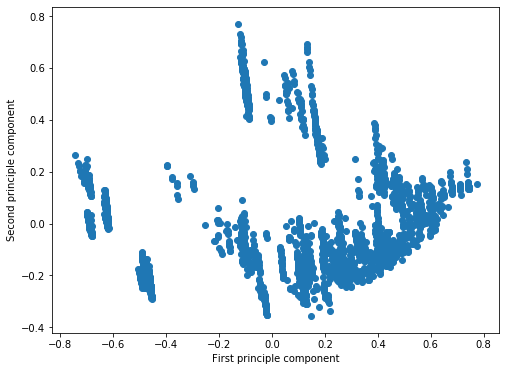

In [97]:
''' To rescale all numerical attributes of the clustering_3_countries_df '''
scaled_clustering_3_countries_df = scale_clustering_attributes_to_df(clustering_3_countries_df)
scaled_clustering_3_countries_arr = scale_clustering_attributes_to_arr(clustering_3_countries_df.drop('country', axis=1))
scaled_clustering_3_countries_df
scaled_clustering_3_countries_arr

''' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'''
x_pca_clustering_3_countries_arr = create_array_two_components(scaled_clustering_3_countries_arr)
x_pca_clustering_3_countries_arr

''' To creata a PCA plot from x_pca_clustering_merged'''
PCA_plot_before_clustering_3_countries = create_PCA_plot_one_argument(x_pca_clustering_3_countries_arr)
PCA_plot_before_clustering_3_countries

In [98]:
''' To split the scaled_clustering_3_countries_df '''
scaled_clustering_df_Belgium_from_3_countries = scaled_clustering_3_countries_df[scaled_clustering_3_countries_df['country'] == 'Belgium']
scaled_clustering_df_Netherlands_from_3_countries = scaled_clustering_3_countries_df[scaled_clustering_3_countries_df['country'] == 'Netherlands']
scaled_clustering_df_Switzerland_from_3_countries = scaled_clustering_3_countries_df[scaled_clustering_3_countries_df['country'] == 'Switzerland']


scaled_clustering_df_Belgium_from_3_countries
scaled_clustering_df_Netherlands_from_3_countries
scaled_clustering_df_Switzerland_from_3_countries

''' To convert the x_pca_clustering_merged array to a df and to add the country attribute'''
# To convert the x_pca_clustering_merged array to a df
x_pca_clustering_3_countries_df = pd.DataFrame({'Principal component 1': x_pca_clustering_3_countries_arr[:, 0], 'Principal component 2': x_pca_clustering_3_countries_arr[:, 1]})

# To add the country attribute
x_pca_clustering_3_countries_df['country'] = scaled_clustering_3_countries_df['country']
x_pca_clustering_3_countries_df

''' To split the x_pca_clustering_3_countries_df df into two for both the countries '''
x_pca_clustering_df_Belgium_from_3_countries = x_pca_clustering_3_countries_df[x_pca_clustering_3_countries_df['country'] == 'Belgium']
x_pca_clustering_df_Netherlands_from_3_countries = x_pca_clustering_3_countries_df[x_pca_clustering_3_countries_df['country'] == 'Netherlands']
x_pca_clustering_df_Switzerland_from_3_countries = x_pca_clustering_3_countries_df[x_pca_clustering_3_countries_df['country'] == 'Switzerland']
x_pca_clustering_df_Belgium_from_3_countries
x_pca_clustering_df_Netherlands_from_3_countries
x_pca_clustering_df_Switzerland_from_3_countries

''' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'''
# To drop the country attribute
x_pca_clustering_df_Belgium_from_3_countries = x_pca_clustering_df_Belgium_from_3_countries.drop('country', axis=1)
x_pca_clustering_df_Netherlands_from_3_countries = x_pca_clustering_df_Netherlands_from_3_countries.drop('country', axis=1)
x_pca_clustering_df_Switzerland_from_3_countries = x_pca_clustering_df_Switzerland_from_3_countries.drop('country', axis=1)

# To convert the x_pca_clustering dfs of both countries to an array
x_pca_clustering_arr_Belgium_from_3_countries = x_pca_clustering_df_Belgium_from_3_countries.to_numpy()
x_pca_clustering_arr_Netherlands_from_3_countries = x_pca_clustering_df_Netherlands_from_3_countries.to_numpy()
x_pca_clustering_arr_Switzerland_from_3_countries = x_pca_clustering_df_Switzerland_from_3_countries.to_numpy()

x_pca_clustering_arr_Belgium_from_3_countries
x_pca_clustering_arr_Netherlands_from_3_countries
x_pca_clustering_arr_Switzerland_from_3_countries

' To split the scaled_clustering_3_countries_df '

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0      0.125000                  0.287385                    0.100718   
1      0.125000                  0.245718                    0.056227   
2      0.083333                  0.237278                    0.083827   
3      0.250000                  0.359246                    0.463891   
4      0.166667                  0.339173                    0.113696   
..          ...                       ...                         ...   
564    0.333333                  0.376566                    0.787695   
565    0.333333                  0.376566                    0.787695   
566    0.250000                  0.359246                    0.463891   
567    0.333333                  0.376566                    0.787695   
568    0.291667                  0.388327                    0.697271   

     len_stop_sequence  absolute_distance  country  
0             0.031250           0.017677  Belgium  
1             0.046875           0.017754  Belgium  
2             0.093750           0.013392  Belgium  
3             0.171875           0.080248  Belgium  
4             0.125000           0.019411  Belgium  
..                 ...                ...      ...  
564           0.468750           0.122146  Belgium  
565           0.421875           0.118935  Belgium  
566           0.203125           0.066663  Belgium  
567           0.781250           0.120797  Belgium  
568           0.718750           0.181654  Belgium  

[569 rows x 6 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
569    0.500000                  0.924685                    0.482446   
570    0.708333                  1.000000                    1.000000   
571    0.708333                  1.000000                    1.000000   
572    0.333333                  0.833831                    0.069237   
573    0.708333                  1.000000                    1.000000   
..          ...                       ...                         ...   
759    0.416667                  0.849580                    0.479238   
760    0.250000                  0.676446                    0.178254   
761    0.250000                  0.550700                    0.102456   
762    0.166667                  0.676446                    0.178254   
763    0.250000                  0.786818                    0.112370   

     len_stop_sequence  absolute_distance      country  
569           0.015625           0.056811  Netherlands  
570           0.031250           0.045771  Netherlands  
571           0.062500           0.044228  Netherlands  
572           0.171875           0.043812  Netherlands  
573           0.046875           0.075071  Netherlands  
..                 ...                ...          ...  
759           0.078125           0.065838  Netherlands  
760           0.031250           0.050454  Netherlands  
761           0.015625           0.019317  Netherlands  
762           0.109375           0.043745  Netherlands  
763           0.109375           0.094956  Netherlands  

[195 rows x 6 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
764     0.041667                  0.364233                    0.005307   
765     0.041667                  0.002899                    0.000001   
766     0.916667                  0.748814                    0.796804   
767     0.916667                  0.748814                    0.796804   
768     0.916667                  0.748814                    0.796804   
...          ...                       ...                         ...   
2682    0.416667                  0.565194                    0.068010   
2683    0.416667                  0.565194                    0.068010   
2684    0.416667                  0.565194                    0.068010   
2685    0.416667                  0.565194                    0.068010   
2686    0.416667                  0.565194                    0.068010   

      len_stop_sequence  absolute_distance      country  
764            0.031250           0.002697  Switzerland  
765            0.015625           0.003885  Switzerland  
766            0.031250           0.075896  Switzerland  
767            0.078125           0.175368  Switzerland  
768            0.015625           0.073420  Switzerland  
...                 ...                ...          ...  
2682           0.015625           0.170261  Switzerland  
2683           0.015625           0.124296  Switzerland  
2684           0.031250           0.124323  Switzerland  
2685           0.046875           0.192617  Switzerland  
2686           0.015625           0.106560  Switzerland  

[1923 rows x 6 columns]

' To convert the x_pca_clustering_merged array to a df and to add the country attribute'

Principal component 1  Principal component 2      country
0                  0.525704               0.058897      Belgium
1                  0.567233               0.051607      Belgium
2                  0.580479               0.110129      Belgium
3                  0.177006               0.280865      Belgium
4                  0.468343               0.062814      Belgium
...                     ...                    ...          ...
2682               0.241608              -0.204561  Switzerland
2683               0.244530              -0.208281  Switzerland
2684               0.244062              -0.202403  Switzerland
2685               0.239255              -0.191000  Switzerland
2686               0.245658              -0.209717  Switzerland

[2687 rows x 3 columns]

' To split the x_pca_clustering_3_countries_df df into two for both the countries '

Principal component 1  Principal component 2  country
0                 0.525704               0.058897  Belgium
1                 0.567233               0.051607  Belgium
2                 0.580479               0.110129  Belgium
3                 0.177006               0.280865  Belgium
4                 0.468343               0.062814  Belgium
..                     ...                    ...      ...
564              -0.102987               0.574366  Belgium
565              -0.101384               0.556479  Belgium
566               0.176937               0.291517  Belgium
567              -0.112226               0.691772  Belgium
568              -0.031979               0.624642  Belgium

[569 rows x 3 columns]

Principal component 1  Principal component 2      country
569              -0.190885              -0.116405  Netherlands
570              -0.687926               0.120149  Netherlands
571              -0.688760               0.131775  Netherlands
572               0.212763              -0.230541  Netherlands
573              -0.690255               0.128396  Netherlands
..                     ...                    ...          ...
759              -0.108278              -0.025490  Netherlands
760               0.258038              -0.104349  Netherlands
761               0.350273              -0.112207  Netherlands
762               0.314142              -0.038136  Netherlands
763               0.257774              -0.163080  Netherlands

[195 rows x 3 columns]

Principal component 1  Principal component 2      country
764                0.619390              -0.002929  Switzerland
765                0.743457               0.139260  Switzerland
766               -0.622768              -0.005463  Switzerland
767               -0.630490               0.020215  Switzerland
768               -0.622144              -0.011539  Switzerland
...                     ...                    ...          ...
2682               0.241608              -0.204561  Switzerland
2683               0.244530              -0.208281  Switzerland
2684               0.244062              -0.202403  Switzerland
2685               0.239255              -0.191000  Switzerland
2686               0.245658              -0.209717  Switzerland

[1923 rows x 3 columns]

' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'

array([[ 0.52570442,  0.05889667],
       [ 0.56723333,  0.05160701],
       [ 0.58047923,  0.11012858],
       ...,
       [ 0.17693721,  0.29151702],
       [-0.11222565,  0.6917723 ],
       [-0.03197943,  0.62464193]])

array([[-0.19088518, -0.11640502],
       [-0.68792579,  0.12014852],
       [-0.68876018,  0.13177519],
       [ 0.21276349, -0.23054111],
       [-0.69025468,  0.12839564],
       [-0.70016676,  0.15686135],
       [-0.1939503 , -0.1072206 ],
       [ 0.26117335, -0.14458555],
       [-0.68817282,  0.14159183],
       [-0.69533795,  0.1876892 ],
       [-0.69183811,  0.16738693],
       [-0.20323524,  0.01305574],
       [-0.16326666, -0.08010566],
       [-0.69883224,  0.16044457],
       [-0.37954386,  0.17885157],
       [-0.20244379,  0.00395434],
       [ 0.27775826, -0.18480914],
       [ 0.37931094,  0.06805502],
       [ 0.25770376, -0.22026993],
       [-0.11867055, -0.00169407],
       [-0.70277689,  0.21300633],
       [-0.21565563, -0.06902308],
       [-0.16167216, -0.07685343],
       [ 0.15513674, -0.26114238],
       [ 0.41928989, -0.04829263],
       [-0.68984544,  0.12787463],
       [ 0.14766335, -0.35475805],
       [-0.29981444,  0.15160032],
       [-0.69375578,

array([[ 0.61939013, -0.0029286 ],
       [ 0.74345691,  0.13925982],
       [-0.62276775, -0.00546321],
       ...,
       [ 0.24406226, -0.20240337],
       [ 0.2392545 , -0.1910004 ],
       [ 0.24565774, -0.20971678]])

' To apply the elbow method to get the optimal number of clusters of routes in each railway system'

6

5

5

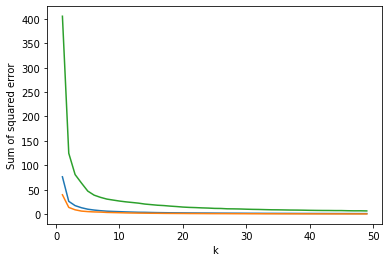

In [99]:
''' To apply the elbow method to get the optimal number of clusters of routes in each railway system'''
optimal_number_clusters_Belgium_from_3_countries = optimal_number_clusters(scaled_clustering_df_Belgium_from_3_countries.drop('country', axis=1))
optimal_number_clusters_Netherlands_from_3_countries = optimal_number_clusters(scaled_clustering_df_Netherlands_from_3_countries.drop('country', axis=1))
optimal_number_clusters_Switzerland_from_3_countries = optimal_number_clusters(scaled_clustering_df_Switzerland_from_3_countries.drop('country', axis=1))


optimal_number_clusters_Belgium_from_3_countries
optimal_number_clusters_Netherlands_from_3_countries
optimal_number_clusters_Switzerland_from_3_countries

In [100]:
''' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'''
km_5D_Belgium_from_3_countries, clustering_cluster_groups_5D_Belgium_from_3_countries, scaled_clustering_cluster_groups_5D_Belgium_from_3_countries, scaled_clustering_cluster_groups_2D_Belgium_from_3_countries = assign_cluster_group(optimal_number_clusters_Belgium_from_3_countries, clustering_df_Belgium.drop('country', axis=1), scaled_clustering_df_Belgium_from_3_countries.drop('country', axis=1), x_pca_clustering_df_Belgium_from_3_countries)
km_5D_Netherlands_from_3_countries, clustering_cluster_groups_5D_Netherlands_from_3_countries, scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries, scaled_clustering_cluster_groups_2D_Netherlands_from_3_countries = assign_cluster_group(optimal_number_clusters_Netherlands_from_3_countries, clustering_df_Netherlands.drop('country', axis=1), scaled_clustering_df_Netherlands_from_3_countries.drop('country', axis=1), x_pca_clustering_df_Netherlands_from_3_countries)
km_5D_Switzerland_from_3_countries, clustering_cluster_groups_5D_Switzerland_from_3_countries, scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries, scaled_clustering_cluster_groups_2D_Switzerland_from_3_countries = assign_cluster_group(optimal_number_clusters_Switzerland_from_3_countries, clustering_df_Switzerland.drop('country', axis=1), scaled_clustering_df_Switzerland_from_3_countries.drop('country', axis=1), x_pca_clustering_df_Switzerland_from_3_countries)


clustering_cluster_groups_5D_Belgium_from_3_countries
scaled_clustering_cluster_groups_5D_Belgium_from_3_countries
scaled_clustering_cluster_groups_2D_Belgium_from_3_countries
clustering_cluster_groups_5D_Netherlands_from_3_countries
scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries
scaled_clustering_cluster_groups_2D_Netherlands_from_3_countries
clustering_cluster_groups_5D_Switzerland_from_3_countries
scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries
scaled_clustering_cluster_groups_2D_Switzerland_from_3_countries

' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0             4                  0.052700                    0.054725   
1             4                  0.045136                    0.030551   
2             3                  0.043604                    0.045548   
3             7                  0.065747                    0.252057   
4             5                  0.062102                    0.061777   
..          ...                       ...                         ...   
564           9                  0.068891                    0.427996   
565           9                  0.068891                    0.427996   
566           7                  0.065747                    0.252057   
567           9                  0.068891                    0.427996   
568           8                  0.071026                    0.378864   

     len_stop_sequence  absolute_distance  cluster_group  
0                    4          18.856662              0  
1                    5          18.936973              0  
2                    8          14.412581              0  
3                   13          83.752756              3  
4                   10          20.655690              0  
..                 ...                ...            ...  
564                 32         127.207623              1  
565                 29         123.877025              1  
566                 15          69.662900              3  
567                 52         125.808981              4  
568                 48         188.927295              4  

[569 rows x 6 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0      0.125000                  0.287385                    0.100718   
1      0.125000                  0.245718                    0.056227   
2      0.083333                  0.237278                    0.083827   
3      0.250000                  0.359246                    0.463891   
4      0.166667                  0.339173                    0.113696   
..          ...                       ...                         ...   
564    0.333333                  0.376566                    0.787695   
565    0.333333                  0.376566                    0.787695   
566    0.250000                  0.359246                    0.463891   
567    0.333333                  0.376566                    0.787695   
568    0.291667                  0.388327                    0.697271   

     len_stop_sequence  absolute_distance  cluster_group  
0             0.031250           0.017677              0  
1             0.046875           0.017754              0  
2             0.093750           0.013392              0  
3             0.171875           0.080248              3  
4             0.125000           0.019411              0  
..                 ...                ...            ...  
564           0.468750           0.122146              1  
565           0.421875           0.118935              1  
566           0.203125           0.066663              3  
567           0.781250           0.120797              4  
568           0.718750           0.181654              4  

[569 rows x 6 columns]

Principal component 1  Principal component 2  cluster_group
0                 0.525704               0.058897              0
1                 0.567233               0.051607              0
2                 0.580479               0.110129              0
3                 0.177006               0.280865              3
4                 0.468343               0.062814              0
..                     ...                    ...            ...
564              -0.102987               0.574366              1
565              -0.101384               0.556479              1
566               0.176937               0.291517              3
567              -0.112226               0.691772              4
568              -0.031979               0.624642              4

[569 rows x 3 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0            13                  0.168401                    0.262139   
1            18                  0.182074                    0.543353   
2            18                  0.182074                    0.543353   
3             9                  0.151906                    0.037620   
4            18                  0.182074                    0.543353   
..          ...                       ...                         ...   
190          11                  0.154765                    0.260395   
191           7                  0.123333                    0.096855   
192           7                  0.100504                    0.055670   
193           5                  0.123333                    0.096855   
194           7                  0.143371                    0.061057   

     len_stop_sequence  absolute_distance  cluster_group  
0                    3          59.444891              2  
1                    4          47.994900              1  
2                    6          46.394804              1  
3                   13          45.962746              0  
4                    5          78.383771              1  
..                 ...                ...            ...  
190                  7          68.807951              2  
191                  4          52.851600              0  
192                  3          20.557738              0  
193                  9          45.893449              0  
194                  9          99.007810              0  

[195 rows x 6 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
569    0.500000                  0.924685                    0.482446   
570    0.708333                  1.000000                    1.000000   
571    0.708333                  1.000000                    1.000000   
572    0.333333                  0.833831                    0.069237   
573    0.708333                  1.000000                    1.000000   
..          ...                       ...                         ...   
759    0.416667                  0.849580                    0.479238   
760    0.250000                  0.676446                    0.178254   
761    0.250000                  0.550700                    0.102456   
762    0.166667                  0.676446                    0.178254   
763    0.250000                  0.786818                    0.112370   

     len_stop_sequence  absolute_distance  cluster_group  
569           0.015625           0.056811              2  
570           0.031250           0.045771              1  
571           0.062500           0.044228              1  
572           0.171875           0.043812              0  
573           0.046875           0.075071              1  
..                 ...                ...            ...  
759           0.078125           0.065838              2  
760           0.031250           0.050454              0  
761           0.015625           0.019317              0  
762           0.109375           0.043745              0  
763           0.109375           0.094956              0  

[195 rows x 6 columns]

Principal component 1  Principal component 2  cluster_group
569              -0.190885              -0.116405              2
570              -0.687926               0.120149              1
571              -0.688760               0.131775              1
572               0.212763              -0.230541              0
573              -0.690255               0.128396              1
..                     ...                    ...            ...
759              -0.108278              -0.025490              2
760               0.258038              -0.104349              0
761               0.350273              -0.112207              0
762               0.314142              -0.038136              0
763               0.257774              -0.163080              0

[195 rows x 3 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
0              2                  0.066652                2.883512e-03   
1              2                  0.001053                5.543084e-07   
2             23                  0.136472                4.329460e-01   
3             23                  0.136472                4.329460e-01   
4             23                  0.136472                4.329460e-01   
...          ...                       ...                         ...   
1918          11                  0.103136                3.695330e-02   
1919          11                  0.103136                3.695330e-02   
1920          11                  0.103136                3.695330e-02   
1921          11                  0.103136                3.695330e-02   
1922          11                  0.103136                3.695330e-02   

      len_stop_sequence  absolute_distance  cluster_group  
0                     4           3.320147              2  
1                     3           4.552323              2  
2                     4          79.239036              0  
3                     7         182.406957              0  
4                     3          76.670926              0  
...                 ...                ...            ...  
1918                  3         177.110629              1  
1919                  3         129.437931              1  
1920                  4         129.465746              1  
1921                  5         200.296819              1  
1922                  3         111.042380              1  

[1923 rows x 6 columns]

max_degree  max_closeness_centrality  max_betweenness_centrality  \
764     0.041667                  0.364233                    0.005307   
765     0.041667                  0.002899                    0.000001   
766     0.916667                  0.748814                    0.796804   
767     0.916667                  0.748814                    0.796804   
768     0.916667                  0.748814                    0.796804   
...          ...                       ...                         ...   
2682    0.416667                  0.565194                    0.068010   
2683    0.416667                  0.565194                    0.068010   
2684    0.416667                  0.565194                    0.068010   
2685    0.416667                  0.565194                    0.068010   
2686    0.416667                  0.565194                    0.068010   

      len_stop_sequence  absolute_distance  cluster_group  
764            0.031250           0.002697              2  
765            0.015625           0.003885              2  
766            0.031250           0.075896              0  
767            0.078125           0.175368              0  
768            0.015625           0.073420              0  
...                 ...                ...            ...  
2682           0.015625           0.170261              1  
2683           0.015625           0.124296              1  
2684           0.031250           0.124323              1  
2685           0.046875           0.192617              1  
2686           0.015625           0.106560              1  

[1923 rows x 6 columns]

Principal component 1  Principal component 2  cluster_group
764                0.619390              -0.002929              2
765                0.743457               0.139260              2
766               -0.622768              -0.005463              0
767               -0.630490               0.020215              0
768               -0.622144              -0.011539              0
...                     ...                    ...            ...
2682               0.241608              -0.204561              1
2683               0.244530              -0.208281              1
2684               0.244062              -0.202403              1
2685               0.239255              -0.191000              1
2686               0.245658              -0.209717              1

[1923 rows x 3 columns]

In [101]:
''' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '''
cluster_centroids_5D_Belgium_from_3_countries = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Belgium_from_3_countries)
cluster_centroids_5D_Netherlands_from_3_countries = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries)
cluster_centroids_5D_Switzerland_from_3_countries = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries)
cluster_centroids_2D_Belgium_from_3_countries = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Belgium_from_3_countries)
cluster_centroids_2D_Netherlands_from_3_countries = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Netherlands_from_3_countries)
cluster_centroids_2D_Switzerland_from_3_countries = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Switzerland_from_3_countries)


cluster_centroids_5D_Belgium_from_3_countries
cluster_centroids_5D_Netherlands_from_3_countries
cluster_centroids_5D_Switzerland_from_3_countries
cluster_centroids_2D_Belgium_from_3_countries
cluster_centroids_2D_Netherlands_from_3_countries
cluster_centroids_2D_Switzerland_from_3_countries

# To compare the 5D centroids of the get_cluster_centroids definition to the 5D centroids of the find_cluster_centroids_in_5D definition
# These centroids values are almost equal. 
#centroidtest_5D_scaled = get_cluster_centroids(km_5D_Belgium_from_3_countries)
#centroidtest_5D_scaled

' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '

array([[0.13383838, 0.2664208 , 0.12471393, 0.08892045, 0.03029063],
       [0.31536697, 0.38368898, 0.76823074, 0.47319381, 0.13154753],
       [0.32374631, 0.38528099, 0.77789816, 0.24142699, 0.06337331],
       [0.22572816, 0.34928502, 0.52826268, 0.22466626, 0.0619379 ],
       [0.28017241, 0.36176605, 0.67365764, 0.7580819 , 0.15938023],
       [0.165     , 0.2925182 , 0.21475486, 0.350625  , 0.07724996]])

array([[0.2309322 , 0.70590959, 0.1486895 , 0.08871822, 0.04218058],
       [0.70833333, 1.        , 1.        , 0.10873724, 0.11783977],
       [0.43118687, 0.88768235, 0.42523199, 0.11363636, 0.08634328],
       [0.42045455, 0.94723342, 0.77910657, 0.09517045, 0.10656464],
       [0.6125    , 0.9766385 , 0.88197661, 0.18125   , 0.66043652]])

array([[0.93891916, 0.74881394, 0.79680403, 0.14237057, 0.08827481],
       [0.27367424, 0.5655321 , 0.06498929, 0.11761871, 0.03649456],
       [0.09906463, 0.1384981 , 0.00661846, 0.08051658, 0.02864452],
       [0.55808304, 0.62937359, 0.20998829, 0.14211572, 0.06016387],
       [1.        , 0.7266971 , 0.47963971, 0.1360394 , 0.07269877]])

array([[ 5.08840964e-01,  1.02971646e-01],
       [-8.12782139e-02,  5.68455924e-01],
       [-8.25029460e-02,  4.78017600e-01],
       [ 1.56114458e-01,  3.58656705e-01],
       [ 3.59551243e-05,  6.37660241e-01],
       [ 4.10744725e-01,  2.42300415e-01]])

array([[ 0.27900053, -0.10758993],
       [-0.69481945,  0.15512027],
       [-0.09929598, -0.07018981],
       [-0.33609391,  0.14816265],
       [-0.58237837,  0.19776573]])

array([[-0.64236048,  0.0273447 ],
       [ 0.34840311, -0.11512048],
       [ 0.65065478,  0.08758117],
       [ 0.03526827, -0.15843499],
       [-0.47583777, -0.21295238]])

' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'

' To make the 2D PCA plot of Netherlands with the Dutch cluster centroids'

' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'

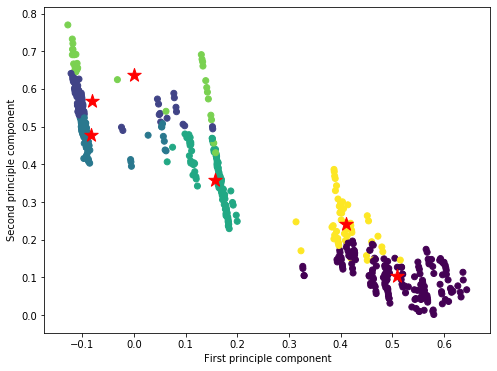

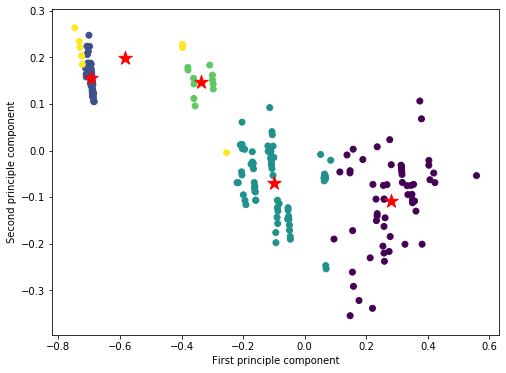

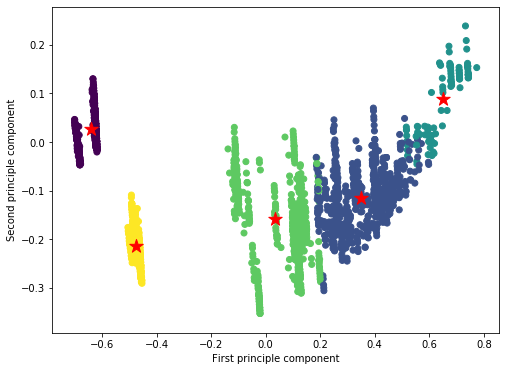

In [102]:
''' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'''
PCA_plot_clustering_Belgium_from_3_countries_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_3_countries, cluster_centroids_2D_Belgium_from_3_countries, scaled_clustering_cluster_groups_5D_Belgium_from_3_countries)
PCA_plot_clustering_Belgium_from_3_countries_belgian_centroids

''' To make the 2D PCA plot of Netherlands with the Dutch cluster centroids'''
PCA_plot_clustering_Netherlands_from_3_countries_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_3_countries, cluster_centroids_2D_Netherlands_from_3_countries, scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries)
PCA_plot_clustering_Netherlands_from_3_countries_dutch_centroids

''' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'''
PCA_plot_clustering_Switzerland_from_3_countries_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_3_countries, cluster_centroids_2D_Switzerland_from_3_countries, scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries)
PCA_plot_clustering_Switzerland_from_3_countries_swiss_centroids

' To make the 2D PCA plot of Belgium with the Dutch cluster centroids'

' To make the 2D PCA plot of Netherlands with the Belgian cluster centroids'

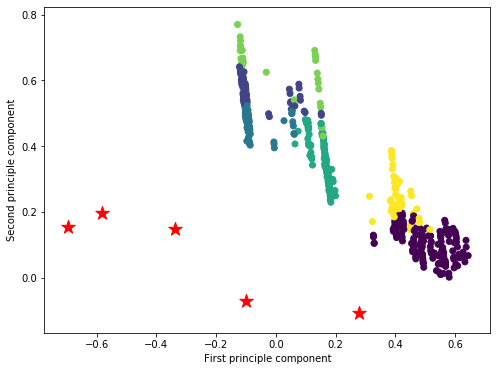

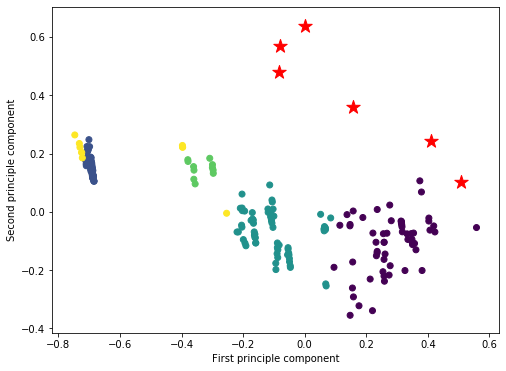

In [103]:
''' To make the 2D PCA plot of Belgium with the Dutch cluster centroids'''
PCA_plot_clustering_Belgium_from_3_countries_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_3_countries, cluster_centroids_2D_Netherlands_from_3_countries, scaled_clustering_cluster_groups_5D_Belgium_from_3_countries)
PCA_plot_clustering_Belgium_from_3_countries_dutch_centroids

''' To make the 2D PCA plot of Netherlands with the Belgian cluster centroids'''
PCA_plot_clustering_Netherlands_from_3_countries_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_3_countries, cluster_centroids_2D_Belgium_from_3_countries, scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries)
PCA_plot_clustering_Netherlands_from_3_countries_belgian_centroids

' To make the 2D PCA plot of Belgium with the Swiss cluster centroids'

' To make the 2D PCA plot of Switzerland with the Belgian cluster centroids'

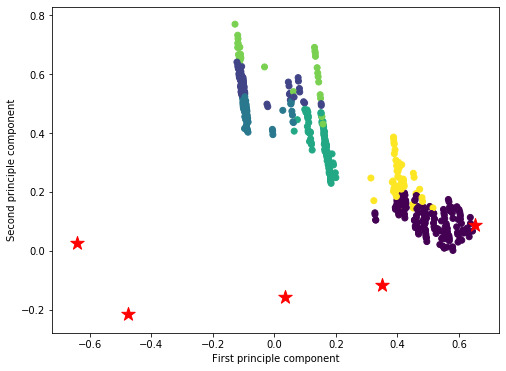

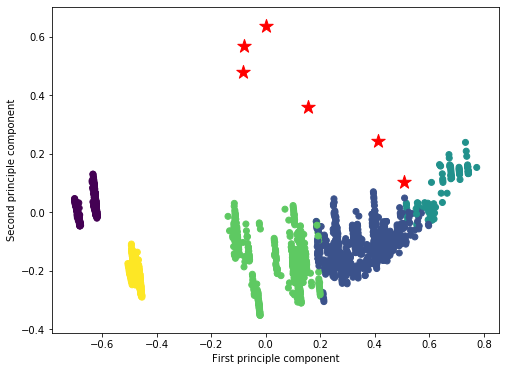

In [104]:
''' To make the 2D PCA plot of Belgium with the Swiss cluster centroids'''
PCA_plot_clustering_Belgium_from_3_countries_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_3_countries, cluster_centroids_2D_Switzerland_from_3_countries, scaled_clustering_cluster_groups_5D_Belgium_from_3_countries)
PCA_plot_clustering_Belgium_from_3_countries_swiss_centroids

''' To make the 2D PCA plot of Switzerland with the Belgian cluster centroids'''
PCA_plot_clustering_Switzerland_from_3_countries_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_3_countries, cluster_centroids_2D_Belgium_from_3_countries, scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries)
PCA_plot_clustering_Switzerland_from_3_countries_belgian_centroids

' To make the 2D PCA plot of Netherlands with the Swiss cluster centroids'

' To make the 2D PCA plot of Switzerland with the Dutch cluster centroids'

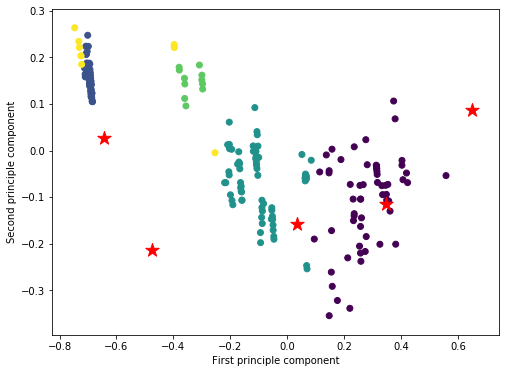

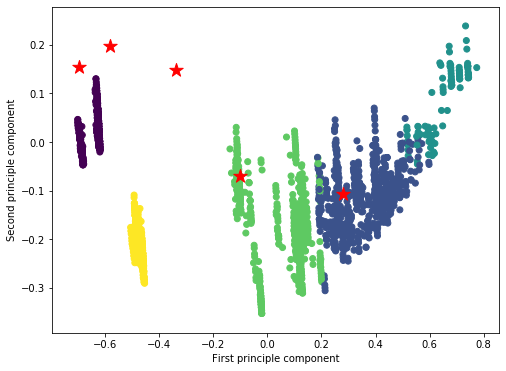

In [105]:
''' To make the 2D PCA plot of Netherlands with the Swiss cluster centroids'''
PCA_plot_clustering_Netherlands_from_3_countries_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_3_countries, cluster_centroids_2D_Switzerland_from_3_countries, scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries)
PCA_plot_clustering_Netherlands_from_3_countries_swiss_centroids

''' To make the 2D PCA plot of Switzerland with the Dutch cluster centroids'''
PCA_plot_clustering_Switzerland_from_3_countries_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_3_countries, cluster_centroids_2D_Netherlands_from_3_countries, scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries)
PCA_plot_clustering_Switzerland_from_3_countries_dutch_centroids

In [106]:
cluster_centroids_2D_Netherlands_from_3_countries

array([[ 0.27900053, -0.10758993],
       [-0.69481945,  0.15512027],
       [-0.09929598, -0.07018981],
       [-0.33609391,  0.14816265],
       [-0.58237837,  0.19776573]])

## K-nearest neighbor method

### Functions

In [107]:
''' To drop the country attribute from the scaled_clustering_df and to convert the result to an array'''
def get_array_routes_other_country(scaled_clustering_df):
    scaled_clustering_arr = scaled_clustering_df.drop('country', axis=1)
    scaled_clustering_arr = scaled_clustering_arr.to_numpy()

    return scaled_clustering_arr

' To drop the country attribute from the scaled_clustering_df and to convert the result to an array'

In [108]:
'''To split the first centroid in the cluster_centroids_5D array off from the other centroids in that array '''
def split_off_the_first_centroid(cluster_centroids_5D):
    first_centroid = cluster_centroids_5D[:1]
    other_centroids = cluster_centroids_5D[1:]

    return first_centroid, other_centroids

'To split the first centroid in the cluster_centroids_5D array off from the other centroids in that array '

In [109]:
''' To get the array that contains the k nearest neighbors of one centroid'''
def get_k_nearest_neighbors_of_centroid(centroid_routes, nearest, k):
    for j in nearest[:, 1:k+1]:
        return centroid_routes[j]

' To get the array that contains the k nearest neighbors of one centroid'

In [110]:
''' To get the list of indices that correspond to the indices of the k nearest neighbors of one centroid in the route_characteristics df'''
def get_indices_k_nearest_neighbors_of_centroid(nearest, k):
    list_indices = []
    for i in nearest[0, 1:k+1]:
        list_indices.append(i-1)

    return list_indices

' To get the list of indices that correspond to the indices of the k nearest neighbors of one centroid in the route_characteristics df'

In [111]:
''' To create the nearest array that contains for each array element an index that corresponds to an array element index of the centroid_routes_arr together 
with the k-nearest neighbor indices of the array element indices of the centroid_routes_arr'''
def to_get_k_nearest_neighbors_of_centroid(centroid_routes_arr):
    D = distance.squareform(distance.pdist(centroid_routes_arr))
    nearest = np.argsort(D, axis=1)

    nearest_neighbors_centroid = get_k_nearest_neighbors_of_centroid(centroid_routes_arr, nearest, 5)
    list_indices_nearest_neighbors = get_indices_k_nearest_neighbors_of_centroid(nearest, 5)

    return nearest_neighbors_centroid, list_indices_nearest_neighbors

' To create the nearest array that contains for each array element an index that corresponds to an array element index of the centroid_routes_arr together \nwith the k-nearest neighbor indices of the array element indices of the centroid_routes_arr'

In [112]:
''' To concatenate the array that contains one centroid with the array that contains the scaled route characteristics of the routes of another country'''
def to_get_array_centroid_routes(first_centroid, scaled_clustering_arr):
    centroid_routes_arr = np.concatenate((first_centroid, scaled_clustering_arr), axis=0)

    return centroid_routes_arr

' To concatenate the array that contains one centroid with the array that contains the scaled route characteristics of the routes of another country'

In [113]:
''' To activate the definition that add the cluster centroid as the first array element of the array that contains the other routes and
to activate the definitions to get the k-nearest neighbors of a centroid as well as the indices of the nearest neighbors in the route_characteristics df'''
def find_k_nearest_neighbors_of_one_centroid(first_centroid, scaled_clustering_arr):
    centroid_routes_arr = to_get_array_centroid_routes(first_centroid, scaled_clustering_arr)
    nearest_neighbors_centroid, list_indices_nearest_neighbors = to_get_k_nearest_neighbors_of_centroid(centroid_routes_arr)

    return nearest_neighbors_centroid, list_indices_nearest_neighbors

' To activate the definition that add the cluster centroid as the first array element of the array that contains the other routes and\nto activate the definitions to get the k-nearest neighbors of a centroid as well as the indices of the nearest neighbors in the route_characteristics df'

In [114]:
''' To find the nearest_neighbors of all centroids and to find the indices of these nearest_neighbors'''
def find_k_nearest_neighbors_of_all_centroids(cluster_centroids_5D, scaled_clustering_df):
    centroids_list = []
    nearest_neighbors_list = []
    indices_nearest_neighbors_list = []
    number_of_cluster_centroids = len(cluster_centroids_5D)
    print("Number of centroids:", number_of_cluster_centroids)
    other_centroids = cluster_centroids_5D.copy()
    scaled_clustering_arr = get_array_routes_other_country(scaled_clustering_df)
    for i in range(0, number_of_cluster_centroids):
        centroid, other_centroids = split_off_the_first_centroid(other_centroids)
        nearest_neighbors_centroid, list_indices_nearest_neighbors = find_k_nearest_neighbors_of_one_centroid(centroid, scaled_clustering_arr)
        nearest_neighbors_list.append(nearest_neighbors_centroid)
        indices_nearest_neighbors_list.append(list_indices_nearest_neighbors)
        centroids_list.append(centroid)    

    return nearest_neighbors_list, indices_nearest_neighbors_list, centroids_list

' To find the nearest_neighbors of all centroids and to find the indices of these nearest_neighbors'

In [115]:
''' To find the nearest neighbors of all centroids and their corresponding route_ids'''
def search_k_nearest_neighbors_of_centroids(cluster_centroids_5D, scaled_clustering_df, route_characteristics):
    nearest_neighbors_list, indices_nearest_neighbors_list, centroids_list = find_k_nearest_neighbors_of_all_centroids(cluster_centroids_5D, scaled_clustering_df)
    k_nearest_neighbors_df = pd.DataFrame(index=range(len(centroids_list)),columns=['centroid', 'nearest_neighbors_centroid', 'route_ids_nearest_neighbors'])
    for nr_centroid, centroid in enumerate(centroids_list):
        #[0] is used to only get one array and not an array of an array
        k_nearest_neighbors_df.loc[nr_centroid,'centroid'] = centroid[0]
        k_nearest_neighbors_df.loc[nr_centroid, 'nearest_neighbors_centroid'] = nearest_neighbors_list[nr_centroid]
        sublist = indices_nearest_neighbors_list[nr_centroid]
        list_route_ids = []
        for listelement in sublist:
            route_id = route_characteristics.loc[listelement,'route_id']
            list_route_ids.append(route_id)
            k_nearest_neighbors_df.loc[nr_centroid, 'route_ids_nearest_neighbors'] = list_route_ids

    return k_nearest_neighbors_df

' To find the nearest neighbors of all centroids and their corresponding route_ids'

### Belgian centroids and Dutch routes

In [116]:
k_nearest_neighbors_df_belgian_centroids_dutch_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_3_countries, scaled_clustering_df_Netherlands_from_3_countries, route_characteristics_Netherlands)
k_nearest_neighbors_df_belgian_centroids_dutch_routes

Number of centroids: 6


centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12...   
1  [0.31536697247706397, 0.3836889795758983, 0.76...   
2  [0.32374631268436566, 0.38528099112620956, 0.7...   
3  [0.2257281553398057, 0.3492850215734978, 0.528...   
4  [0.2801724137931033, 0.3617660498764408, 0.673...   
5  [0.16500000000000006, 0.2925182003310213, 0.21...   

                          nearest_neighbors_centroid  \
0  [[0.16666666666666666, 0.5439096488329229, 0.1...   
1  [[0.4583333333333333, 0.9180976564336435, 0.53...   
2  [[0.41666666666666663, 0.8495801241333183, 0.4...   
3  [[0.20833333333333334, 0.5996876008726527, 0.2...   
4  [[0.4583333333333333, 0.9180976564336435, 0.53...   
5  [[0.08333333333333334, 0.6130870882069412, 0.1...   

                     route_ids_nearest_neighbors  
0  [67449.0, 77597.0, 45223.0, 18646.0, 67424.0]  
1  [61914.0, 77619.0, 53004.0, 52989.0, 41223.0]  
2  [52989.0, 53004.0, 52996.0, 41220.0, 46084.0]  
3  [45231.0, 45224.0, 67425.0, 17760.0, 77613.0]  
4  [61914.0, 77594.0, 77619.0, 41202.0, 17748.0]  
5  [77594.0, 45223.0, 67449.0, 17760.0, 18646.0]

### Dutch centroids and Belgian routes

In [117]:
k_nearest_neighbors_df_dutch_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_3_countries, scaled_clustering_df_Belgium_from_3_countries, route_characteristics_Belgium)
k_nearest_neighbors_df_dutch_centroids_belgian_routes

Number of centroids: 5


centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14...   
1  [0.708333333333333, 0.9999999999999999, 1.0, 0...   
2  [0.4311868686868686, 0.8876823531859631, 0.425...   
3  [0.42045454545454547, 0.9472334164672815, 0.77...   
4  [0.6124999999999999, 0.9766385008437577, 0.881...   

                          nearest_neighbors_centroid  \
0  [[0.20833333333333334, 0.3669224142351884, 0.2...   
1  [[0.3333333333333333, 0.3883267325338699, 0.78...   
2  [[0.24999999999999997, 0.3592462677223216, 0.4...   
3  [[0.3333333333333333, 0.3883267325338699, 0.78...   
4  [[0.3333333333333333, 0.3744603900107032, 0.78...   

           route_ids_nearest_neighbors  
0  [516.0, 775.0, 529.0, 506.0, 325.0]  
1  [328.0, 329.0, 794.0, 776.0, 789.0]  
2  [142.0, 208.0, 361.0, 674.0, 804.0]  
3  [328.0, 329.0, 776.0, 794.0, 789.0]  
4  [732.0, 726.0, 727.0, 753.0, 552.0]

### Belgian centroids and Swiss routes

In [118]:
k_nearest_neighbors_df_belgian_centroids_swiss_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_3_countries, scaled_clustering_df_Switzerland_from_3_countries, route_characteristics_Switzerland)
k_nearest_neighbors_df_belgian_centroids_swiss_routes

Number of centroids: 6


centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12...   
1  [0.31536697247706397, 0.3836889795758983, 0.76...   
2  [0.32374631268436566, 0.38528099112620956, 0.7...   
3  [0.2257281553398057, 0.3492850215734978, 0.528...   
4  [0.2801724137931033, 0.3617660498764408, 0.673...   
5  [0.16500000000000006, 0.2925182003310213, 0.21...   

                          nearest_neighbors_centroid  \
0  [[0.125, 0.268197564510806, 0.0176396227231409...   
1  [[0.625, 0.6314422597154831, 0.356057128217433...   
2  [[0.3333333333333333, 0.6665431910623193, 0.33...   
3  [[0.3333333333333333, 0.6665431910623193, 0.33...   
4  [[0.625, 0.6314422597154831, 0.356057128217433...   
5  [[0.125, 0.4265668654997753, 0.039810224659644...   

                         route_ids_nearest_neighbors  
0  [00402.000029.014:402, 00330.000049.002:330, 0...  
1  [24006.000011.101:24006, 30197.000011.107:3019...  
2  [14416.000053.101:20, 14504.000011.101:30, 145...  
3  [14416.000053.101:20, 14504.000011.102:30, 146...  
4  [24006.000011.101:24006, 30197.000011.107:3019...  
5  [00215.000043.003:215, 00120.000049.001:CENTOV...

### Swiss centroids and Belgian routes

In [119]:
k_nearest_neighbors_df_swiss_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_3_countries, scaled_clustering_df_Belgium_from_3_countries, route_characteristics_Belgium)
k_nearest_neighbors_df_swiss_centroids_belgian_routes

Number of centroids: 5


centroid  \
0  [0.9389191643960054, 0.7488139377777342, 0.796...   
1  [0.27367424242424176, 0.5655320990674334, 0.06...   
2  [0.09906462585034022, 0.13849810473890128, 0.0...   
3  [0.5580830388692581, 0.6293735944853707, 0.209...   
4  [0.9999999999999998, 0.7266970968770043, 0.479...   

                          nearest_neighbors_centroid  \
0  [[0.3333333333333333, 0.3883267325338699, 0.78...   
1  [[0.16666666666666666, 0.3391725176603462, 0.1...   
2  [[0.08333333333333334, 0.16661421028693083, 0....   
3  [[0.20833333333333334, 0.3669224142351884, 0.2...   
4  [[0.3333333333333333, 0.3883267325338699, 0.78...   

           route_ids_nearest_neighbors  
0  [794.0, 789.0, 328.0, 783.0, 193.0]  
1  [119.0, 720.0, 195.0, 138.0, 249.0]  
2  [627.0, 514.0, 638.0, 468.0, 515.0]  
3  [277.0, 516.0, 775.0, 325.0, 164.0]  
4  [789.0, 794.0, 783.0, 328.0, 193.0]

### Dutch centroids and Swiss routes

In [120]:
k_nearest_neighbors_df_dutch_centroids_swiss_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_3_countries, scaled_clustering_df_Switzerland_from_3_countries, route_characteristics_Switzerland)
k_nearest_neighbors_df_dutch_centroids_swiss_routes

Number of centroids: 5


centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14...   
1  [0.708333333333333, 0.9999999999999999, 1.0, 0...   
2  [0.4311868686868686, 0.8876823531859631, 0.425...   
3  [0.42045454545454547, 0.9472334164672815, 0.77...   
4  [0.6124999999999999, 0.9766385008437577, 0.881...   

                          nearest_neighbors_centroid  \
0  [[0.29166666666666663, 0.7067911993975542, 0.1...   
1  [[0.9166666666666666, 0.748813937777738, 0.796...   
2  [[0.49999999999999994, 0.6665431910623193, 0.3...   
3  [[0.49999999999999994, 0.6665431910623193, 0.3...   
4  [[0.9999999999999999, 0.748813937777738, 0.796...   

                         route_ids_nearest_neighbors  
0  [04556.000033.102:4556, 06601.000033.101:6601,...  
1  [00589.000011.101:3, 03495.000011.101:3495, 30...  
2  [30101.000011.101:30101, 14504.000011.101:30, ...  
3  [30101.000011.101:30101, 00589.000011.101:3, 3...  
4  [30512.000011.104:5, 30509.000011.105:5, 00512...

### Swiss centroids and dutch routes

In [121]:
k_nearest_neighbors_df_swiss_centroids_dutch_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_3_countries, scaled_clustering_df_Netherlands_from_3_countries, route_characteristics_Netherlands)
k_nearest_neighbors_df_swiss_centroids_dutch_routes

Number of centroids: 5


centroid  \
0  [0.9389191643960054, 0.7488139377777342, 0.796...   
1  [0.27367424242424176, 0.5655320990674334, 0.06...   
2  [0.09906462585034022, 0.13849810473890128, 0.0...   
3  [0.5580830388692581, 0.6293735944853707, 0.209...   
4  [0.9999999999999998, 0.7266970968770043, 0.479...   

                          nearest_neighbors_centroid  \
0  [[0.7083333333333334, 0.9999999999999999, 1.0,...   
1  [[0.24999999999999997, 0.5506996676352279, 0.1...   
2  [[0.041666666666666664, 0.5148378016926168, 0....   
3  [[0.41666666666666663, 0.8246090113507412, 0.1...   
4  [[0.49999999999999994, 0.8465346492527936, 0.3...   

                     route_ids_nearest_neighbors  
0  [52991.0, 73488.0, 17651.0, 77617.0, 77631.0]  
1  [76981.0, 76982.0, 76980.0, 77644.0, 18646.0]  
2  [77590.0, 77597.0, 18646.0, 67449.0, 67424.0]  
3  [41228.0, 17828.0, 41239.0, 76990.0, 77596.0]  
4  [67394.0, 41239.0, 76990.0, 67395.0, 41238.0]

### Belgian centroids and belgian routes


In [122]:
k_nearest_neighbors_df_belgian_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_3_countries, scaled_clustering_df_Belgium_from_3_countries, route_characteristics_Belgium)
k_nearest_neighbors_df_belgian_centroids_belgian_routes

Number of centroids: 6


centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12...   
1  [0.31536697247706397, 0.3836889795758983, 0.76...   
2  [0.32374631268436566, 0.38528099112620956, 0.7...   
3  [0.2257281553398057, 0.3492850215734978, 0.528...   
4  [0.2801724137931033, 0.3617660498764408, 0.673...   
5  [0.16500000000000006, 0.2925182003310213, 0.21...   

                          nearest_neighbors_centroid  \
0  [[0.125, 0.27735166112971915, 0.15394701994392...   
1  [[0.3333333333333333, 0.3765659027298668, 0.78...   
2  [[0.3333333333333333, 0.3883267325338699, 0.78...   
3  [[0.20833333333333334, 0.32948287812093296, 0....   
4  [[0.29166666666666663, 0.3883267325338699, 0.6...   
5  [[0.16666666666666666, 0.287385027283172, 0.23...   

           route_ids_nearest_neighbors  
0  [715.0, 257.0, 294.0, 132.0, 763.0]  
1  [823.0, 778.0, 368.0, 700.0, 364.0]  
2  [788.0, 362.0, 696.0, 189.0, 473.0]  
3  [504.0, 499.0, 491.0, 500.0, 803.0]  
4  [827.0, 224.0, 202.0, 826.0, 227.0]  
5  [395.0, 444.0, 159.0, 725.0, 777.0]

### Dutch centroids and dutch routes


In [123]:
k_nearest_neighbors_df_dutch_centroids_dutch_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_3_countries, scaled_clustering_df_Netherlands_from_3_countries, route_characteristics_Netherlands)
k_nearest_neighbors_df_dutch_centroids_dutch_routes

Number of centroids: 5


centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14...   
1  [0.708333333333333, 0.9999999999999999, 1.0, 0...   
2  [0.4311868686868686, 0.8876823531859631, 0.425...   
3  [0.42045454545454547, 0.9472334164672815, 0.77...   
4  [0.6124999999999999, 0.9766385008437577, 0.881...   

                          nearest_neighbors_centroid  \
0  [[0.24999999999999997, 0.7442200373222413, 0.1...   
1  [[0.7083333333333334, 0.9999999999999999, 1.0,...   
2  [[0.41666666666666663, 0.8495801241333183, 0.4...   
3  [[0.4583333333333333, 0.9472334164672817, 0.77...   
4  [[0.7083333333333334, 0.9999999999999999, 1.0,...   

                     route_ids_nearest_neighbors  
0  [17620.0, 76983.0, 61913.0, 41208.0, 76977.0]  
1  [31677.0, 77631.0, 66765.0, 77623.0, 77630.0]  
2  [52996.0, 41220.0, 53004.0, 52989.0, 77642.0]  
3  [77633.0, 31682.0, 31675.0, 77611.0, 67419.0]  
4  [77602.0, 34264.0, 75064.0, 77638.0, 77637.0]

### Swiss centroids and swiss routes


In [124]:
k_nearest_neighbors_df_swiss_centroids_swiss_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_3_countries, scaled_clustering_df_Switzerland_from_3_countries, route_characteristics_Switzerland)
k_nearest_neighbors_df_swiss_centroids_swiss_routes

Number of centroids: 5


centroid  \
0  [0.9389191643960054, 0.7488139377777342, 0.796...   
1  [0.27367424242424176, 0.5655320990674334, 0.06...   
2  [0.09906462585034022, 0.13849810473890128, 0.0...   
3  [0.5580830388692581, 0.6293735944853707, 0.209...   
4  [0.9999999999999998, 0.7266970968770043, 0.479...   

                          nearest_neighbors_centroid  \
0  [[0.9166666666666666, 0.748813937777738, 0.796...   
1  [[0.29166666666666663, 0.5485751517389754, 0.0...   
2  [[0.041666666666666664, 0.22044208593086959, 0...   
3  [[0.5416666666666666, 0.6677236841704814, 0.20...   
4  [[0.9999999999999999, 0.715063054918999, 0.503...   

                         route_ids_nearest_neighbors  
0  [02106.000011.102:75, 03495.000011.101:3495, 0...  
1  [25600.000011.101:20, 12001.000065.101:10, 242...  
2  [00103.000066.002:103, 00702.000046.004:18, 00...  
3  [03151.000011.101:13, 03153.000011.101:13, 14,...  
4  [04388.000033.101:4388, 04519.000011.101:4519,...

## Travel time comparison

### Functions 

In [125]:
''' To add a new avg_travel_time_centroid attribute to the df'''
def add_avg_travel_time_centroid(scaled_clustering_cluster_groups_df, route_characteristics, routes_country, k_nearest_neighbors_df):
    # To add the route_id attribute from the route_characteristics_df to the scaled_clustering_cluster_groups_5D_df
    travel_time_clustering_cluster_groups_df = scaled_clustering_cluster_groups_df.copy()
    travel_time_clustering_cluster_groups_df = travel_time_clustering_cluster_groups_df.reset_index(drop=True)
    travel_time_clustering_cluster_groups_df['route_id'] = route_characteristics['route_id']

    # To merge the country_routes df with the travel_time_clustering_cluster_groups_df on route_id to get the average travel time of a route
    travel_time_clustering_cluster_groups_df = pd.merge(routes_country[['route_id', 'travel_time']], travel_time_clustering_cluster_groups_df, on='route_id')

    # To drop the route_id attribute
    travel_time_clustering_cluster_groups_df = travel_time_clustering_cluster_groups_df.drop('route_id', axis=1)

    # To search for the centroid values of the travel_time for each cluster
    travel_time_centroids_arr = find_cluster_centroids_in_5D(travel_time_clustering_cluster_groups_df)

    # To add the average travel times of the centroids in a list
    list_avg_travel_time_centroids = []
    travel_time_centroids_list = travel_time_centroids_arr.tolist()
    for sublist in travel_time_centroids_list:
        avg_travel_time_centroid = sublist[0]
        list_avg_travel_time_centroids.append(avg_travel_time_centroid)

    # To add the list_avg_travel_time_centroids as a new attribute of the df
    travel_time_df = k_nearest_neighbors_df.copy()
    travel_time_df['avg_travel_time_centroid'] = list_avg_travel_time_centroids

    return travel_time_df

' To add a new avg_travel_time_centroid attribute to the df'

In [174]:
''' To add a new travel_time_nearest_neighbors_centroid attribute to the df'''
def add_travel_time_nearest_neighbors_centroid(travel_time_df_1, routes_country):
    # To copy the travel_time_df_1 and to add a new attribute avg_travel_time_nearest_neighbors_centroid
    travel_time_df = travel_time_df_1.copy()
    travel_time_df['travel_time_nearest_neighbors_centroid'] = ""
    travel_time_df['waiting_time_nearest_neighbors_centroid'] = ""

    # To loop over the row indices of the travel_time_df
    for row in range(len(travel_time_df)):
        # To select the route_ids_nearest_neighbors attribute value of that row
        list_route_ids_nearest_neighbors = travel_time_df.loc[row, 'route_ids_nearest_neighbors']
        # To create an empty list list_avg_travel_time_nearest_neighbors_centroid the same is done for waiting time
        list_travel_time_nearest_neighbors_centroid = []
        list_waiting_time_nearest_neighbors_centroid = []
        # To loop over all elements in the list_route_ids_nearest_neighbors
        for route_id in list_route_ids_nearest_neighbors:
            # To search for the corresponding travel time of this route_id
            travel_time = routes_country.loc[routes_country['route_id'] == route_id, 'travel_time'].iloc[0]
            # To search for the corresponding waiting time of this route_id
            waiting_time = routes_country.loc[routes_country['route_id'] == route_id, 'waiting_time'].iloc[0]
            # To add the corresponding average travel time and waiting time of the route to the list_avg_travel_time_nearest_neighbors_centroids
            list_travel_time_nearest_neighbors_centroid.append(travel_time)
            list_waiting_time_nearest_neighbors_centroid.append(waiting_time)
        # To add the list_travel_time_nearest_neighbors_centroid as a new value in the avg_travel_time_nearest_neighbors_centroid column the same is done for waiting time
        travel_time_df.at[row, 'travel_time_nearest_neighbors_centroid'] = list_travel_time_nearest_neighbors_centroid
        travel_time_df.at[row, 'waiting_time_nearest_neighbors_centroid'] = list_waiting_time_nearest_neighbors_centroid


    return travel_time_df

' To add a new travel_time_nearest_neighbors_centroid attribute to the df'

In [175]:
def get_the_average_travel_time(scaled_clustering_cluster_groups_df, route_characteristics, k_nearest_neighbors_df, routes_centroid_country, routes_non_centroid_country):
    travel_time_df_1 = add_avg_travel_time_centroid(scaled_clustering_cluster_groups_df, route_characteristics, routes_centroid_country, k_nearest_neighbors_df)
    travel_time_df = add_travel_time_nearest_neighbors_centroid(travel_time_df_1, routes_non_centroid_country)

    return travel_time_df

In [180]:
def calculate_std_tt_nn_centroid(travel_time_df):
    #calculates variance of the travel_time_nearest_neighbors_centroid
    travel_time_df['std_tt_nn_centroid'] = travel_time_df['travel_time_nearest_neighbors_centroid'].apply(lambda x: np.std(x))
    return travel_time_df

In [181]:
def calculate_avg_tt_nn_centroid(travel_time_df):
    #calculates average of the travel_time_nearest_neighbors_centroid
    travel_time_df['avg_tt_nn_centroid'] = travel_time_df['travel_time_nearest_neighbors_centroid'].apply(lambda x: np.mean(x))
    return travel_time_df

### Belgian centroids and dutch routes

In [182]:
travel_time_df_belgian_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_3_countries, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_dutch_routes, belgian_routes_Belgium, dutch_routes_Netherlands)
travel_time_df_belgian_centroids_dutch_routes = calculate_std_tt_nn_centroid(travel_time_df_belgian_centroids_dutch_routes)
travel_time_df_belgian_centroids_dutch_routes = calculate_avg_tt_nn_centroid(travel_time_df_belgian_centroids_dutch_routes)
travel_time_df_belgian_centroids_dutch_routes

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                nearest_neighbors_centroid  \
0   [[0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.109375, 0.04088426805818443], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.0625, 0.02711497271933787], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.140625, 0.02325200351496887], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.109375, 0.06448924892622993], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.03125, 0.01973167532673664]]   
1     [[0.4583333333333333, 0.9180976564336435, 0.5302791291891736, 0.328125, 0.12378365861785874], [0.3333333333333333, 0.9180976564336435, 0.5302791291891736, 0.265625, 0.10722434617269898], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06933724822080882], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06340172300381264], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.21227761101498385]]   
2        [[0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06340172300381264], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06933724822080882], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.109375, 0.06867001638644], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.09375, 0.09273505615104999], [0.4583333333333333, 0.9472334164672817, 0.7791065701102748, 0.171875, 0.04654452956167666]]   
3   [[0.20833333333333334, 0.5996876008726527, 0.23294785293807246, 0.140625, 0.024804513861392513], [0.20833333333333334, 0.6625038868357236, 0.26384970180889494, 0.109375, 0.04380288086755814], [0.29166666666666663, 0.6806773260123062, 0.30981966520254317, 0.078125, 0.13744793666493976], [0.08333333333333334, 0.6130870882069412, 0.19491008068647997, 0.1875, 0.06069437788499604], [0.20833333333333334, 0.5996876008726527, 0.23294785293807246, 0.0, 0.013680670885641222]]   
4   [[0.4583333333333333, 0.9180976564336435, 0.5302791291891736, 0.328125, 0.12378365861785874], [0.08333333333333334, 0.6130870882069412, 0.19491008068647997, 0.28125, 0.09772740150338752], [0.3333333333333333, 0.9180976564336435, 0.5302791291891736, 0.265625, 0.10722434617269898], [0.49999999999999994, 0.9246847590357321, 0.48244641075529465, 0.328125, 0.19637957191484426], [0.49999999999999994, 0.9246847590357321, 0.48244641075529465, 0.328125, 0.09195149598339288]]   
5  [[0.08333333333333334, 0.6130870882069412, 0.19491008068647997, 0.28125, 0.09772740150338752], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.140625, 0.02325200351496887], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.109375, 0.04088426805818443], [0.08333333333333334, 0.6130870882069412, 0.19491008068647997, 0.1875, 0.06069437788499604], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.109375, 

### Dutch centroids and belgian routes

In [183]:
travel_time_df_dutch_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_belgian_routes, dutch_routes_Netherlands, belgian_routes_Belgium)
travel_time_df_dutch_centroids_belgian_routes = calculate_std_tt_nn_centroid(travel_time_df_dutch_centroids_belgian_routes)
travel_time_df_dutch_centroids_belgian_routes = calculate_avg_tt_nn_centroid(travel_time_df_dutch_centroids_belgian_routes)
travel_time_df_dutch_centroids_belgian_routes

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                  nearest_neighbors_centroid  \
0  [[0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.078125, 0.02534313115249959], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.0625, 0.028615172155308066], [0.16666666666666666, 0.35725022196973444, 0.22058562888760727, 0.15625, 0.02196459315862096], [0.16666666666666666, 0.35725022196973444, 0.22058562888760727, 0.171875, 0.02514454951868561], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.015625, 0.014589172792547182]]   
1            [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.059872369670556785], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.05447520911101379], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.171875, 0.09341855599194603], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.078125, 0.05261472325040261], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.04065405480603058]]   
2           [[0.24999999999999997, 0.3592462677223216, 0.4638907633788068, 0.125, 0.08181416457733996], [0.24999999999999997, 0.3592462677223216, 0.4638907633788068, 0.140625, 0.07773110337142218], [0.24999999999999997, 0.36098621029763844, 0.43249608235548687, 0.15625, 0.030524056719632], [0.24999999999999997, 0.3592462677223216, 0.4638907633788068, 0.140625, 0.04828097961712378], [0.24999999999999997, 0.3592462677223216, 0.4638907633788068, 0.125, 0.038047929819794955]]   
3            [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.059872369670556785], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.05447520911101379], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.078125, 0.05261472325040261], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.171875, 0.09341855599194603], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.04065405480603058]]   
4                      [[0.3333333333333333, 0.3744603900107032, 0.7876946464396054, 0.015625, 0.2520420091694301], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.375, 0.19287496903741624], [0.29166666666666663, 0.3883267325338699, 0.6972708807910223, 0.375, 0.21869612830820198], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.359375, 0.1591633540175899], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.25, 0.1327106751956174]]   

           route_ids_nearest_neighbors  avg_travel_time_centroid  \
0  [516.0, 775.0, 529.0, 506.0, 325.0]                 44.929755   
1  [328.0, 329.0, 794.0, 776.0, 789.0]                 98.972059   
2  [142.0, 208.0, 361.0, 674.0, 804.0]                 74.119978   
3  [328.0, 329.0, 776.0, 794.0, 789.0]                 87.861775   
4  [732.0, 726.0, 727.0, 753.0, 552.0]                471.764361   

                         travel_time_nearest_neighbors_centroid  \
0                [28.625, 38.010278113663844, 34.0, 51.0, 18.0]   
1  

### Belgian centroids and Swiss routes

In [184]:
travel_time_df_belgian_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_3_countries, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_swiss_routes, belgian_routes_Belgium, swiss_routes_Switzerland)
travel_time_df_belgian_centroids_swiss_routes = calculate_std_tt_nn_centroid(travel_time_df_belgian_centroids_swiss_routes)
travel_time_df_belgian_centroids_swiss_routes = calculate_avg_tt_nn_centroid(travel_time_df_belgian_centroids_swiss_routes)
travel_time_df_belgian_centroids_swiss_routes

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                     nearest_neighbors_centroid  \
0        [[0.125, 0.268197564510806, 0.017639622723140944, 0.09375, 0.009036106773719957], [0.16666666666666666, 0.26256977349232014, 0.014996212717196885, 0.09375, 0.007833570629507786], [0.125, 0.268197564510806, 0.017639622723140944, 0.046875, 0.008558901291700382], [0.16666666666666666, 0.26256977349232014, 0.014996212717196885, 0.109375, 0.007852264862812807], [0.16666666666666666, 0.2493629405505307, 0.008837154117125002, 0.09375, 0.006287236960546613]]   
1                                                            [[0.625, 0.6314422597154831, 0.35605712821743335, 0.453125, 0.08347122094343074], [0.625, 0.6314422597154831, 0.35605712821743335, 0.421875, 0.10613865798416801], [0.625, 0.6314422597154831, 0.35605712821743335, 0.390625, 0.08441498118512354], [0.625, 0.6314422597154831, 0.35605712821743335, 0.375, 0.08441249645775256], [0.625, 0.6314422597154831, 0.35605712821743335, 0.359375, 0.08064725044362701]]   
2  [[0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.171875, 0.03786214880351769], [0.37499999999999994, 0.6665431910623193, 0.3356462402815585, 0.1875, 0.041783993833513736], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.15625, 0.03370074237581423], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.140625, 0.0261176718813873], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.125, 0.02541455874453817]]   
3  [[0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.171875, 0.03786214880351769], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.15625, 0.03370074237581423], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.140625, 0.0261176718813873], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.125, 0.02541455874453817], [0.37499999999999994, 0.6665431910623193, 0.3356462402815585, 0.1875, 0.041783993833513736]]   
4                                                [[0.625, 0.6314422597154831, 0.35605712821743335, 0.453125, 0.08347122094343074], [0.625, 0.6314422597154831, 0.35605712821743335, 0.421875, 0.10613865798416801], [0.625, 0.6314422597154831, 0.35605712821743335, 0.390625, 0.08441498118512354], [0.29166666666666663, 0.6515665183405196, 0.12734371195460742, 0.53125, 0.1159487286533217], [0.625, 0.6314422597154831, 0.35605712821743335, 0.375, 0.08441249645775256]]   
5     [[0.125, 0.4265668654997753, 0.03981022465964467, 0.265625, 0.039792112898989714], [0.20833333333333334, 0.4918649246941793, 0.08788862450716557, 0.34375, 0.04111068042812028], [0.20833333333333334, 0.4918649246941793, 0.08788862450716557, 0.359375, 0.04110180198775576], [0.20833333333333334, 0.4918649246941793, 0.08788862450716557, 0.3125, 0.0407861742967046], [0.20833333333333334, 0.4918649246941793, 0.08788862450716557, 0.390625, 0.0412711628826815]]   

                                                   

### Swiss centroids and Belgian routes

In [185]:
travel_time_df_swiss_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_belgian_routes, swiss_routes_Switzerland, belgian_routes_Belgium)
travel_time_df_swiss_centroids_belgian_routes = calculate_std_tt_nn_centroid(travel_time_df_swiss_centroids_belgian_routes)
travel_time_df_swiss_centroids_belgian_routes = calculate_avg_tt_nn_centroid(travel_time_df_swiss_centroids_belgian_routes)
travel_time_df_swiss_centroids_belgian_routes

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                nearest_neighbors_centroid  \
0           [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.171875, 0.09341855599194603], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.04065405480603058], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.059872369670556785], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.03340019385665086], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.03159937443971111]]   
1  [[0.16666666666666666, 0.3391725176603462, 0.11369576298219941, 0.125, 0.019411320496978336], [0.16666666666666666, 0.3391725176603462, 0.11369576298219941, 0.109375, 0.01862406086123782], [0.16666666666666666, 0.3391725176603462, 0.11369576298219941, 0.15625, 0.02528844046486032], [0.16666666666666666, 0.3391725176603462, 0.11369576298219941, 0.203125, 0.056935768516554124], [0.16666666666666666, 0.3261679205790079, 0.13650130812050923, 0.125, 0.023536048177581655]]   
2  [[0.08333333333333334, 0.16661421028693083, 0.03046189654844231, 0.0625, 0.033812045479949704], [0.08333333333333334, 0.1795116560008024, 0.07546662495291001, 0.078125, 0.04259421223698404], [0.08333333333333334, 0.1795116560008024, 0.07546662495291001, 0.0625, 0.03502602407216057], [0.08333333333333334, 0.20221335190013878, 0.0242455211784252, 0.03125, 0.01434364513269267], [0.08333333333333334, 0.1795116560008024, 0.07546662495291001, 0.09375, 0.05320258541086046]]   
3   [[0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.1875, 0.027535983318122233], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.078125, 0.02534313115249959], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.0625, 0.028615172155308066], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.015625, 0.014589172792547182], [0.20833333333333334, 0.3669224142351884, 0.2787788129516997, 0.015625, 0.011927703361074697]]   
4           [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.04065405480603058], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.171875, 0.09341855599194603], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.03340019385665086], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.09375, 0.059872369670556785], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.15625, 0.03159937443971111]]   

           route_ids_nearest_neighbors  avg_travel_time_centroid  \
0  [794.0, 789.0, 328.0, 783.0, 193.0]                 84.757885   
1  [119.0, 720.0, 195.0, 138.0, 249.0]                 47.541498   
2  [627.0, 514.0, 638.0, 468.0, 515.0]                 48.080661   
3  [277.0, 516.0, 775.0, 325.0, 164.0]                 67.865743   
4  [789.0, 794.0, 783.0, 328.0, 193.0]                 75.765519   

                                    travel_time_nearest_neighbors_centroid  \
0               [83.75, 44.0, 58.88888888888889, 42.0, 37.607

### Dutch centroids and Swiss routes

In [186]:
travel_time_df_dutch_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_swiss_routes, dutch_routes_Netherlands, swiss_routes_Switzerland)
travel_time_df_dutch_centroids_swiss_routes = calculate_std_tt_nn_centroid(travel_time_df_dutch_centroids_swiss_routes)
travel_time_df_dutch_centroids_swiss_routes = calculate_avg_tt_nn_centroid(travel_time_df_dutch_centroids_swiss_routes)
travel_time_df_dutch_centroids_swiss_routes

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                     nearest_neighbors_centroid  \
0  [[0.29166666666666663, 0.7067911993975542, 0.16894581778732815, 0.0625, 0.02931436715849078], [0.29166666666666663, 0.7067911993975542, 0.16894581778732815, 0.109375, 0.013555996381119286], [0.29166666666666663, 0.6504909791931395, 0.15617131650913924, 0.09375, 0.04400033135714224], [0.29166666666666663, 0.6504909791931395, 0.15617131650913924, 0.078125, 0.030587390719450557], [0.29166666666666663, 0.7067911993975542, 0.16894581778732815, 0.046875, 0.0038179071272899053]]   
1                      [[0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.078125, 0.10187194388755692], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.10403855015689302], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.09375, 0.08068406074530293], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.08107552757369409], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.09314991640094641]]   
2              [[0.49999999999999994, 0.6665431910623193, 0.3356462402815585, 0.140625, 0.11438794778196687], [0.37499999999999994, 0.6665431910623193, 0.3356462402815585, 0.1875, 0.041783993833513736], [0.49999999999999994, 0.6665431910623193, 0.3356462402815585, 0.171875, 0.15484238913493586], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.125, 0.02541455874453817], [0.3333333333333333, 0.6665431910623193, 0.3356462402815585, 0.109375, 0.02241948175439148]]   
3                  [[0.49999999999999994, 0.6665431910623193, 0.3356462402815585, 0.140625, 0.11438794778196687], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.078125, 0.10187194388755692], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.09375, 0.08068406074530293], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.078125, 0.07904930531174939], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.09375, 0.07353928459524758]]   
4                          [[0.9999999999999999, 0.748813937777738, 0.7968040272805185, 0.203125, 0.3075134705631124], [0.9999999999999999, 0.748813937777738, 0.7968040272805185, 0.21875, 0.30782786585908567], [0.9999999999999999, 0.748813937777738, 0.7968040272805185, 0.1875, 0.3056269707520668], [0.9999999999999999, 0.748813937777738, 0.7968040272805185, 0.171875, 0.30487488214365766], [0.9999999999999999, 0.748813937777738, 0.7968040272805185, 0.1875, 0.3042205306659856]]   

                                                                                            route_ids_nearest_neighbors  \
0  [04556.000033.102:4556, 06601.000033.101:6601, 04065.000033.101:4065, 04056.000033.101:4056, 30800.000033.101:30800]   
1            [00589.000011.101:3, 03495.000011.101:3495, 30188.000011.103:36, 02055.000011.101:36, 02106.000011.102:75]   
2       [30101.000011.101:30101, 14504.000011.101:30, 30100.000011.101:30100, 14423.000053.101:20, 14304.000011.101:40]   
3         [30101.000011.101:30101, 0

### Swiss centroids and dutch routes

In [187]:
travel_time_df_swiss_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_dutch_routes, swiss_routes_Switzerland, dutch_routes_Netherlands)
travel_time_df_swiss_centroids_dutch_routes = calculate_std_tt_nn_centroid(travel_time_df_swiss_centroids_dutch_routes)
travel_time_df_swiss_centroids_dutch_routes = calculate_avg_tt_nn_centroid(travel_time_df_swiss_centroids_dutch_routes)
travel_time_df_swiss_centroids_dutch_routes

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                nearest_neighbors_centroid  \
0                                                                                     [[0.7083333333333334, 0.9999999999999999, 1.0, 0.140625, 0.048948878439366336], [0.7083333333333334, 0.9999999999999999, 1.0, 0.171875, 0.059815837548898264], [0.7083333333333334, 0.9999999999999999, 1.0, 0.15625, 0.04864119749025362], [0.7083333333333334, 0.9999999999999999, 1.0, 0.125, 0.042077209806322804], [0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.10263499471603223]]   
1  [[0.24999999999999997, 0.5506996676352279, 0.10245595937982237, 0.109375, 0.045749433515813544], [0.24999999999999997, 0.5506996676352279, 0.10245595937982237, 0.0625, 0.0244616138160261], [0.24999999999999997, 0.5506996676352279, 0.10245595937982237, 0.03125, 0.01951948647422758], [0.24999999999999997, 0.5506996676352279, 0.10245595937982237, 0.015625, 0.01931687698658923], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.109375, 0.06448924892622993]]   
2  [[0.041666666666666664, 0.5148378016926168, 0.021235179088964922, 0.03125, 0.01854607300650414], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.0625, 0.02711497271933787], [0.16666666666666666, 0.543281614336361, 0.07998125975093964, 0.109375, 0.06448924892622993], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.109375, 0.04088426805818443], [0.16666666666666666, 0.5439096488329229, 0.10736937206891854, 0.03125, 0.01973167532673664]]   
3             [[0.41666666666666663, 0.8246090113507412, 0.16473552639815928, 0.1875, 0.07100885938023807], [0.41666666666666663, 0.8040149192554914, 0.08688288853427165, 0.125, 0.04050646470741424], [0.49999999999999994, 0.8465346492527936, 0.346303680311863, 0.1875, 0.04110134423254346], [0.49999999999999994, 0.8465346492527936, 0.346303680311863, 0.125, 0.135837777851319], [0.41666666666666663, 0.8040149192554914, 0.08688288853427165, 0.046875, 0.026033979382359206]]   
4             [[0.49999999999999994, 0.8465346492527936, 0.35518506804098965, 0.078125, 0.11022277904971882], [0.49999999999999994, 0.8465346492527936, 0.346303680311863, 0.1875, 0.04110134423254346], [0.49999999999999994, 0.8465346492527936, 0.346303680311863, 0.125, 0.135837777851319], [0.49999999999999994, 0.8465346492527936, 0.35518506804098965, 0.046875, 0.09152475182946443], [0.49999999999999994, 0.8465346492527936, 0.346303680311863, 0.1875, 0.13110789300498152]]   

                     route_ids_nearest_neighbors  avg_travel_time_centroid  \
0  [52991.0, 73488.0, 17651.0, 77617.0, 77631.0]                 84.757885   
1  [76981.0, 76982.0, 76980.0, 77644.0, 18646.0]                 47.541498   
2  [77590.0, 77597.0, 18646.0, 67449.0, 67424.0]                 48.080661   
3  [41228.0, 17828.0, 41239.0, 76990.0, 77596.0]                 67.865743   
4  [67394.0, 41239.0, 76990.0, 67395.0, 41238.0]                 75.765519   

                                                               travel_time_near

### Belgian centroids with Belgian routes

In [188]:
travel_time_df_belgian_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_3_countries, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_belgian_routes, belgian_routes_Belgium, belgian_routes_Belgium)
travel_time_df_belgian_centroids_belgian_routes = calculate_std_tt_nn_centroid(travel_time_df_belgian_centroids_belgian_routes)
travel_time_df_belgian_centroids_belgian_routes = calculate_avg_tt_nn_centroid(travel_time_df_belgian_centroids_belgian_routes)
travel_time_df_belgian_centroids_belgian_routes

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                            nearest_neighbors_centroid  \
0                                                  [[0.125, 0.27735166112971915, 0.15394701994392598, 0.09375, 0.021784621440568586], [0.125, 0.287385027283172, 0.10071789133221537, 0.078125, 0.024296689016702434], [0.125, 0.28214595954679084, 0.10991163831975137, 0.09375, 0.05733244862960326], [0.125, 0.28214595954679084, 0.10991163831975137, 0.0625, 0.04803536243042796], [0.16666666666666666, 0.2865529787602787, 0.10543870972226782, 0.09375, 0.028685499655519465]]   
1      [[0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.46875, 0.1221459416509119], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.484375, 0.14685796469093446], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.453125, 0.12411844289058424], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.453125, 0.12212271332146214], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.453125, 0.11090312773225142]]   
2                [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.25, 0.06100346828117333], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.25, 0.058567436932961556], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.234375, 0.07870531258767964], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.234375, 0.04627310336986994], [0.3333333333333333, 0.3744603900107032, 0.7876946464396054, 0.25, 0.0774005657997967]]   
3  [[0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.0584845346295849], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.21875, 0.052898808492911], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.07474826249971088], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.04183745551092662], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.25, 0.07428857085566266]]   
4       [[0.29166666666666663, 0.3883267325338699, 0.6972708807910223, 0.71875, 0.18165445548862336], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.765625, 0.17953831895994146], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.78125, 0.16894695520388356], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.78125, 0.12079740788430625], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.71875, 0.15912261864189045]]   
5  [[0.16666666666666666, 0.287385027283172, 0.23077656309024755, 0.34375, 0.08040162695893184], [0.16666666666666666, 0.2834440679551523, 0.23077656309024755, 0.390625, 0.06508270730604755], [0.16666666666666666, 0.287385027283172, 0.23077656309024755, 0.390625, 0.09858273359908663], [0.16666666666666666, 0.2706122110974483, 0.23077656309024755, 0.3125, 0.05057617606429088], [0.16666666666666666, 0.329085529727674, 0.2299511551552596, 0.34375, 0.11471947464948178]]   

  

### Dutch centroids with Dutch routes

In [189]:
travel_time_df_dutch_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_3_countries, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_dutch_routes, dutch_routes_Netherlands, dutch_routes_Netherlands)
travel_time_df_dutch_centroids_dutch_routes = calculate_std_tt_nn_centroid(travel_time_df_dutch_centroids_dutch_routes)
travel_time_df_dutch_centroids_dutch_routes = calculate_avg_tt_nn_centroid(travel_time_df_dutch_centroids_dutch_routes)
travel_time_df_dutch_centroids_dutch_routes

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                              nearest_neighbors_centroid  \
0  [[0.24999999999999997, 0.7442200373222413, 0.13437309786574003, 0.078125, 0.06047763309457208], [0.24999999999999997, 0.6764456627146479, 0.178253636868607, 0.109375, 0.0509206107309043], [0.24999999999999997, 0.7678323910631937, 0.16641636634923576, 0.078125, 0.021004566154706687], [0.24999999999999997, 0.7678323910631937, 0.16641636634923576, 0.0625, 0.03321658082159755], [0.24999999999999997, 0.6764456627146479, 0.178253636868607, 0.03125, 0.050352291796192966]]   
1                                                                                   [[0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.10814252997328679], [0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.10263499471603223], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.12826797948485924], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.12826797948485927], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.10263488897480018]]   
2     [[0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.109375, 0.06867001638644], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.09375, 0.09273505615104999], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06933724822080882], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06340172300381264], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.078125, 0.06583848696502406]]   
3        [[0.4583333333333333, 0.9472334164672817, 0.7791065701102748, 0.046875, 0.0921809118793413], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.125, 0.15452847445558604], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.0625, 0.04893684157032434], [0.4583333333333333, 0.9472334164672817, 0.7791065701102748, 0.140625, 0.040831946583273174], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.09375, 0.030099667589969143]]   
4                                                                                       [[0.7083333333333334, 0.9999999999999999, 1.0, 0.171875, 0.6428517288260649], [0.7083333333333334, 0.9999999999999999, 1.0, 0.203125, 0.6591960086655602], [0.7083333333333334, 0.9999999999999999, 1.0, 0.140625, 0.5689133155881244], [0.7083333333333334, 0.9999999999999999, 1.0, 0.140625, 0.5650652914482375], [0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.5569783229558521]]   

                     route_ids_nearest_neighbors  avg_travel_time_centroid  \
0  [17620.0, 76983.0, 61913.0, 41208.0, 76977.0]                 44.929755   
1  [31677.0, 77631.0, 66765.0, 77623.0, 77630.0]                 98.972059   
2  [52996.0, 41220.0, 53004.0, 52989.0, 77642.0]                 74.119978   
3  [77633.0, 31682.0, 31675.0, 77611.0, 67419.0]                 87.861775   
4  [77602.0, 34264.0, 75064.0, 77638.0, 77637.0]                471.764361   

                                                 travel_time_nearest_neighbors_centroid  \
0  [46.0, 

### Swiss centroids with swiss routes

In [190]:
travel_time_df_swiss_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_3_countries, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_swiss_routes, swiss_routes_Switzerland, swiss_routes_Switzerland)
travel_time_df_swiss_centroids_swiss_routes = calculate_std_tt_nn_centroid(travel_time_df_swiss_centroids_swiss_routes)
travel_time_df_swiss_centroids_swiss_routes = calculate_avg_tt_nn_centroid(travel_time_df_swiss_centroids_swiss_routes)
travel_time_df_swiss_centroids_swiss_routes

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                              nearest_neighbors_centroid  \
0                   [[0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.09314991640094641], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.10403855015689302], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.08107552757369409], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.15625, 0.10504813376481527], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.0750550010764328]]   
1  [[0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.125, 0.03665940603439765], [0.29166666666666663, 0.5482276788610351, 0.042059657242572934, 0.125, 0.014828548530662674], [0.24999999999999997, 0.5701442096617854, 0.028292481963530063, 0.125, 0.03108032192550178], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.09375, 0.05137436074828487], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.140625, 0.054210310619069293]]   
2   [[0.041666666666666664, 0.22044208593086959, 0.007071763617882888, 0.046875, 0.006272330515785277], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.09375, 0.005633816974403224], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.0625, 0.00799608674621268], [0.08333333333333334, 0.009863850517285024, 9.181458822987015e-05, 0.078125, 0.004614465300698883], [0.08333333333333334, 0.010014909811619462, 5.6108915029365096e-05, 0.09375, 0.00705083567567966]]   
3    [[0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.125, 0.08117049522966263], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.109375, 0.08079983767557133], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.171875, 0.021504545118416665], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.03739457871962124], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.037101984191445066]]   
4                [[0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.125, 0.07630396173921761], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.125, 0.06674202825291879], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.140625, 0.046820031395614733], [0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.109375, 0.0668520765903722], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.109375, 0.07825716099201088]]   

                                                                                         route_ids_nearest_neighbors  \
0      [02106.000011.102:75, 03495.000011.101:3495, 02055.000011.101:36, 03456.000011.101:3456, 01856.000011.101:36]   
1           [25600.000011.101:20, 12001.000065.101:10, 24211.000011.105:2, 25753.000011.102:10, 25139.000011.103:10]   
2        [00103.000066.002:103, 00702.000046.004:18, 00565.000046.005:18, 12753.000078.101:10, 00121.000137.001:121]   
3                       [03151.000011.101:13, 03153.000011.101:13, 14, 04709.000

### Merge the important information

#### Functions

In [130]:
'''Change the column names mentionned in important columns by adding the suffix at the end and return those new names in a lists (new_important columns)'''

def change_col_name_with_suffix(travel_time_df, important_columns, suffix):
    new_important_columns = []
    for name_col in important_columns:
        new_name = name_col + suffix
        travel_time_df = travel_time_df.rename(columns={name_col: new_name})
        new_important_columns.append(new_name)
    return travel_time_df , new_important_columns

'Change the column names mentionned in important columns by adding the suffix at the end and return those new names in a lists (new_important columns)'

In [200]:
'''Merge the important information (avg, differences and variance) of the centroids with the k-nearest neighbours'''

def merge_important_infomation_centroid_nn(travel_time_df_main_centroids_main_routes, travel_time_df_main_centroids_other1_routes, travel_time_df_main_centroids_other2_routes, main_suffix, other1_suffix, other2_suffix):
    important_columns = ['nearest_neighbors_centroid', 'travel_time_nearest_neighbors_centroid', 'route_ids_nearest_neighbors', 'std_tt_nn_centroid', 'avg_tt_nn_centroid']
    additional_columns_main = ['centroid', 'avg_travel_time_centroid']
    
    #change the names of the important columns by adding their suffix

    travel_time_df_main_centroids_main_routes, important_columns_main = change_col_name_with_suffix(travel_time_df_main_centroids_main_routes, important_columns, main_suffix)
    travel_time_df_main_centroids_other1_routes, important_columns_other1 = change_col_name_with_suffix(travel_time_df_main_centroids_other1_routes, important_columns, other1_suffix)
    travel_time_df_main_centroids_other2_routes, important_columns_other2 = change_col_name_with_suffix(travel_time_df_main_centroids_other2_routes, important_columns, other2_suffix)
   
    #make the merges between all the DataFrames
    important_information_centroid_nn = pd.merge(travel_time_df_main_centroids_main_routes[additional_columns_main + important_columns_main ], travel_time_df_main_centroids_other1_routes[important_columns_other1 + ['centroid']] ,left_index = True, right_index = True,  on='centroid')
    important_information_centroid_nn = pd.merge(important_information_centroid_nn, travel_time_df_main_centroids_other2_routes[important_columns_other2 + ['centroid']] ,left_index = True, right_index = True,  on='centroid')
    
    return important_information_centroid_nn

'Merge the important information (avg, differences and variance) of the centroids with the k-nearest neighbours'

#### Acutal merging

In [201]:
'''Analysis unsing Belgian centroids'''
comparison_table_Belgium = merge_important_infomation_centroid_nn(travel_time_df_belgian_centroids_belgian_routes, travel_time_df_belgian_centroids_dutch_routes, travel_time_df_belgian_centroids_swiss_routes, '_Belgium', '_Netherlands', '_Switzerland')
comparison_table_Belgium

'Analysis unsing Belgian centroids'

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

   avg_travel_time_centroid  \
0                 37.157831   
1                134.616598   
2                 70.620571   
3                 76.215350   
4                164.227605   
5                 90.966259   

                                                                                                                                                                                                                                                                                                                                                                                                                                                    nearest_neighbors_centroid_Belgium  \
0                                                  [[0.125, 0.27735166112971915, 0.15394701994392598, 0.09375, 0.021784621440568586], [0.125, 0.287385027283172, 0.10071789133221537, 0.078125, 0.024296689016702434], [0.125, 0.28214595954679084, 0.10991163831975137, 0.09375, 0.05733244862960326], [0.125, 0.28214595954679084, 0.10991163831975137, 0.0625, 0.04803536243042796], [0.16666666666666666, 0.2865529787602787, 0.10543870972226782, 0.09375, 0.028685499655519465]]   
1      [[0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.46875, 0.1221459416509119], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.484375, 0.14685796469093446], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.453125, 0.12411844289058424], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.453125, 0.12212271332146214], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.453125, 0.11090312773225142]]   
2                [[0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.25, 0.06100346828117333], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.25, 0.058567436932961556], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.234375, 0.07870531258767964], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.234375, 0.04627310336986994], [0.3333333333333333, 0.3744603900107032, 0.7876946464396054, 0.25, 0.0774005657997967]]   
3  [[0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.0584845346295849], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.21875, 0.052898808492911], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.07474826249971088], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.234375, 0.04183745551092662], [0.20833333333333334, 0.32948287812093296, 0.5481730410294062, 0.25, 0.07428857085566266]]   
4       [[0.29166666666666663, 0.3883267325338699, 0.6972708807910223, 0.71875, 0.18165445548862336], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.765625, 0.17953831895994146], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.78125, 0.16894695520388356], [0.3333333333333333, 0.3765659027298668, 0.7876946464396054, 0.78125, 0.12079740788430625], [0.3333333333333333, 0.3883267325338699, 0.7876946464396054, 0.71875, 0.15912261864189045]]   
5  [[0.16666666666666666, 0.287385027283172, 0.23077656309024755, 0.34375, 0.08040162695893184], [0.16666666666666666, 0.2834440679551523, 0.23077656309024755, 0.390625, 0.06508270730604755], [0.16666666666666666, 0.287385027283172, 0.23077656309024755, 0.390

In [202]:
'''Analysis unsing Dutch centroids'''
comparison_table_Netherlands = merge_important_infomation_centroid_nn(travel_time_df_dutch_centroids_dutch_routes, travel_time_df_dutch_centroids_belgian_routes, travel_time_df_dutch_centroids_swiss_routes, '_Netherlands', '_Belgium', '_Switzerland')
comparison_table_Netherlands

'Analysis unsing Dutch centroids'

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

   avg_travel_time_centroid  \
0                 44.929755   
1                 98.972059   
2                 74.119978   
3                 87.861775   
4                471.764361   

                                                                                                                                                                                                                                                                                                                                                                                                                                                  nearest_neighbors_centroid_Netherlands  \
0  [[0.24999999999999997, 0.7442200373222413, 0.13437309786574003, 0.078125, 0.06047763309457208], [0.24999999999999997, 0.6764456627146479, 0.178253636868607, 0.109375, 0.0509206107309043], [0.24999999999999997, 0.7678323910631937, 0.16641636634923576, 0.078125, 0.021004566154706687], [0.24999999999999997, 0.7678323910631937, 0.16641636634923576, 0.0625, 0.03321658082159755], [0.24999999999999997, 0.6764456627146479, 0.178253636868607, 0.03125, 0.050352291796192966]]   
1                                                                                   [[0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.10814252997328679], [0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.10263499471603223], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.12826797948485924], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.12826797948485927], [0.7083333333333334, 0.9999999999999999, 1.0, 0.078125, 0.10263488897480018]]   
2     [[0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.109375, 0.06867001638644], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.09375, 0.09273505615104999], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06933724822080882], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.140625, 0.06340172300381264], [0.41666666666666663, 0.8495801241333183, 0.4792378771838017, 0.078125, 0.06583848696502406]]   
3        [[0.4583333333333333, 0.9472334164672817, 0.7791065701102748, 0.046875, 0.0921809118793413], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.125, 0.15452847445558604], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.0625, 0.04893684157032434], [0.4583333333333333, 0.9472334164672817, 0.7791065701102748, 0.140625, 0.040831946583273174], [0.37499999999999994, 0.9472334164672817, 0.7791065701102748, 0.09375, 0.030099667589969143]]   
4                                                                                       [[0.7083333333333334, 0.9999999999999999, 1.0, 0.171875, 0.6428517288260649], [0.7083333333333334, 0.9999999999999999, 1.0, 0.203125, 0.6591960086655602], [0.7083333333333334, 0.9999999999999999, 1.0, 0.140625, 0.5689133155881244], [0.7083333333333334, 0.9999999999999999, 1.0, 0.140625, 0.5650652914482375], [0.7083333333333334, 0.9999999999999999, 1.0, 0.09375, 0.5569783229558521]]   

                                     travel_time_nearest_neighbors_centroid_Netherlands  \
0  [46.0, 44.09550343397694, 25.014178339596853, 29.510163183509878, 34.52228826151559]   
1                          [90.21485411140586, 103.75172413793103, 136.0, 146.0, 105.1]   
2  [53.931721194879074, 66.52068032470042, 61.188250750750754, 64.63066202090593, 53.0]   
3  [72.0, 126.03549

In [203]:
'''Analysis unsing Swiss centroids'''
comparison_table_Switzerland = merge_important_infomation_centroid_nn(travel_time_df_swiss_centroids_swiss_routes, travel_time_df_swiss_centroids_belgian_routes, travel_time_df_swiss_centroids_dutch_routes,'_Switzerland', '_Belgium', '_Netherlands')
comparison_table_Switzerland


'Analysis unsing Swiss centroids'

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

   avg_travel_time_centroid  \
0                 84.757885   
1                 47.541498   
2                 48.080661   
3                 67.865743   
4                 75.765519   

                                                                                                                                                                                                                                                                                                                                                                                                                                                  nearest_neighbors_centroid_Switzerland  \
0                   [[0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.09314991640094641], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.10403855015689302], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.08107552757369409], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.15625, 0.10504813376481527], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.0750550010764328]]   
1  [[0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.125, 0.03665940603439765], [0.29166666666666663, 0.5482276788610351, 0.042059657242572934, 0.125, 0.014828548530662674], [0.24999999999999997, 0.5701442096617854, 0.028292481963530063, 0.125, 0.03108032192550178], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.09375, 0.05137436074828487], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.140625, 0.054210310619069293]]   
2   [[0.041666666666666664, 0.22044208593086959, 0.007071763617882888, 0.046875, 0.006272330515785277], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.09375, 0.005633816974403224], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.0625, 0.00799608674621268], [0.08333333333333334, 0.009863850517285024, 9.181458822987015e-05, 0.078125, 0.004614465300698883], [0.08333333333333334, 0.010014909811619462, 5.6108915029365096e-05, 0.09375, 0.00705083567567966]]   
3    [[0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.125, 0.08117049522966263], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.109375, 0.08079983767557133], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.171875, 0.021504545118416665], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.03739457871962124], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.037101984191445066]]   
4                [[0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.125, 0.07630396173921761], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.125, 0.06674202825291879], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.140625, 0.046820031395614733], [0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.109375, 0.0668520765903722], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.109375, 0.07825716099201088]]   

                                    travel_time_nearest_neighbors_centroid_Switzerland  \
0               [108.49717514124296, 78.0, 87.76297169811319, 91.68632982816106, 75.0]   
1  [45.87830687830683, 26.083650190114064, 39.58441558441557, 57.0, 62.50188133140375]   
2                            [13.300000000000002, 13.66843220338983, 17.0, 12.0, 43.0]   
3            

## Statistical analysis of the results 

In [204]:
columns_for_comparison = ['route_id', 'nodes','max_degree', 'max_closeness_centrality', 'max_betweenness_centrality','len_stop_sequence', 'absolute_distance', 'travel_time']

In [148]:
#CHECK WHAT TO DELETE
'''Create the filtered DataFrames for our analysis'''

columns_analysis_var_tt = ['variance_avg_tt_nn_centroid_Belgium', 'variance_avg_tt_nn_centroid_Netherlands', 'variance_avg_tt_nn_centroid_Switzerland']
columns_analysis_avgtt = ['centroid', 'avg_travel_time_centroid','travel_time_nearest_neighbors_centroid_Belgium', 'travel_time_nearest_neighbors_centroid_Netherlands', 'travel_time_nearest_neighbors_centroid_Switzerland']
columns_analysis_avg_abs_diff = ['avg_abs_difference_avgtt_centroid_avgtt_nn_Belgium', 'avg_abs_difference_avgtt_centroid_avgtt_nn_Netherlands', 'avg_abs_difference_avgtt_centroid_avgtt_nn_Switzerland']
columns_analysis_abs_diff = ['abs_difference_avgtt_centroid_avgtt_nn_Belgium', 'abs_difference_avgtt_centroid_avgtt_nn_Netherlands', 'abs_difference_avgtt_centroid_avgtt_nn_Switzerland']
columns_analysis_route_id = ['centroid', 'route_ids_nearest_neighbors_Belgium', 'route_ids_nearest_neighbors_Netherlands', 'route_ids_nearest_neighbors_Switzerland']

#create the filtered dataframes
tt_nn_belgian_centroid = comparison_table_Belgium[columns_analysis_avgtt]
tt_nn_dutch_centroid = comparison_table_Netherlands[columns_analysis_avgtt]
tt_nn_swiss_centroid = comparison_table_Switzerland[columns_analysis_avgtt]
var_nn_belgian_centroid = comparison_table_Belgium[columns_analysis_var_tt]
var_nn_dutch_centroid = comparison_table_Netherlands[columns_analysis_var_tt]
var_nn_swiss_centroid = comparison_table_Switzerland[columns_analysis_var_tt]
avg_abs_diff_tt_nn_belgian_centroid = comparison_table_Belgium[columns_analysis_avg_abs_diff]
avg_abs_diff_tt_nn_dutch_centroid = comparison_table_Netherlands[columns_analysis_avg_abs_diff]
avg_abs_diff_tt_nn_swiss_centroid = comparison_table_Switzerland[columns_analysis_avg_abs_diff]
abs_diff_tt_nn_belgian_centroid = comparison_table_Belgium[columns_analysis_abs_diff]
abs_diff_tt_nn_dutch_centroid = comparison_table_Netherlands[columns_analysis_abs_diff]
abs_diff_tt_nn_swiss_centroid = comparison_table_Switzerland[columns_analysis_abs_diff]
route_id_nn_belgian_centroid = comparison_table_Belgium[columns_analysis_route_id]
route_id_nn_dutch_centroid = comparison_table_Netherlands[columns_analysis_route_id]
route_id_nn_swiss_centroid = comparison_table_Switzerland[columns_analysis_route_id]

'Create the filtered DataFrames for our analysis'

In [149]:
'''Set the display information to allow better screenshots'''
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

'Set the display information to allow better screenshots'

60

### Functions

In [150]:
'''Retrieve the 5 NN information in the respective route_characteristics DataFrame'''

def retrieve_5_nn_info(centroid_index, country_centroid, country_5_nn):
    if country_centroid == 'Belgium':
        df_centroid = comparison_table_Belgium
    if country_centroid == 'Netherlands':
        df_centroid = comparison_table_Netherlands
    if country_centroid == 'Switzerland':
        df_centroid = comparison_table_Switzerland
    route_id_nn = df_centroid[f'route_ids_nearest_neighbors_{country_5_nn}'].loc[centroid_index]
    if country_5_nn == 'Belgium':
        charac_nn = route_characteristics_Belgium[columns_for_comparison]
    if country_5_nn == 'Netherlands':
        charac_nn = route_characteristics_Netherlands[columns_for_comparison]
    if country_5_nn == 'Switzerland':
        charac_nn = route_characteristics_Switzerland[columns_for_comparison]
        
    return charac_nn[(charac_nn['route_id'] == route_id_nn[0])|(charac_nn['route_id'] == route_id_nn[1])|(charac_nn['route_id'] == route_id_nn[2])|(charac_nn['route_id'] == route_id_nn[3])|(charac_nn['route_id'] == route_id_nn[4])]

'Retrieve the 5 NN information in the respective route_characteristics DataFrame'

In [151]:
'''Get the 2D coordinates of the centroids of the chosen country'''

def get_centroid_2D_coord(cluster_centroids_2D):
    df_centroids_2D = pd.DataFrame(columns=['First Principle Component', 'Second Principle Component'])
    for index, row in enumerate(cluster_centroids_2D):
        df_centroids_2D.loc[index, 'First Principle Component'] = row[0]
        df_centroids_2D.loc[index, 'Second Principle Component'] = row[1]
    return df_centroids_2D

'Get the 2D coordinates of the centroids of the chosen country'

In [214]:
'''The first name of the list is the country with the centroids, the other ones are the ones of the other countries'''

def find_countries_name_important_information_df(important_information_df):
    countries = []
    for column_name in important_information_df.columns:
        if 'route_ids_nearest_neighbors' in column_name:
            countries.append(column_name.split('_')[-1])
    return countries

'The first name of the list is the country with the centroids, the other ones are the ones of the other countries'

In [ ]:
'''Calculates the avg absolute difference between the nearest neighbors of the centroid's country and the nearest neighbors of the other countries'''

def calculate_avg_abs_difference_tt_nn1_tt_nn2(important_information_df):
    countries = find_countries_name_important_information_df(important_information_df)
    important_information_df[f'avg_abs_difference_tt_nn_{countries[0]}_tt_nn_{countries[1]}'] = np.nan
    important_information_df[f'avg_abs_difference_tt_nn_{countries[0]}_tt_nn_{countries[2]}'] = np.nan
    for index_row, row in important_information_df.iterrows():
        #loop over the tt of the nearest neighbors of the centroid's country
        for tt_nn_centroid_country in row[f'travel_time_nearest_neighbors_centroid_{countries[0]}']:
            #loop over the tt of the nearest neighbors of other first country
            for tt_nn_country1 in row[f'travel_time_nearest_neighbors_centroid_{countries[1]}']:
                #calculate the abs difference for each nn_country1 (with the nn of the centroid's country)
                #put it in the dataframe
            #loop over the tt of the nearest neighbors of other second country
            for tt_nn_country1 in row[f'travel_time_nearest_neighbors_centroid_{countries[2]}']:
                #calculate the abs difference for each nn_country2 (with the nn of the centroid's country)
                #put it in the dataframe
            
            #FROM OLD CODE
            travel_time_df.loc[index_row, 'abs_difference_avgtt_centroid_avgtt_nn'].append(abs(row['avg_travel_time_centroid'] - tt_nn_centroid))
        travel_time_df.loc[index_row, 'avg_abs_difference_avgtt_centroid_avgtt_nn'] = np.mean(travel_time_df.loc[index_row, 'abs_difference_avgtt_centroid_avgtt_nn'])
    
    
    return travel_time_df

### Analysis of the variances of the travel time of the nearest neighbors

In [156]:
tt_nn_belgian_centroid
tt_nn_dutch_centroid
tt_nn_swiss_centroid
var_nn_belgian_centroid
var_nn_dutch_centroid
var_nn_swiss_centroid[[columns_analysis_var_tt[0], columns_analysis_var_tt[2]]]

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

   avg_travel_time_centroid  \
0                 37.157831   
1                134.616598   
2                 70.620571   
3                 76.215350   
4                164.227605   
5                 90.966259   

                              travel_time_nearest_neighbors_centroid_Belgium  \
0                 [34.0, 30.819968553459116, 60.44, 54.0, 37.42942345924453]   
1   [143.0, 166.7647058823529, 153.5, 141.16666666666666, 130.0770682604593]   
2                    [65.0, 66.5, 59.0, 60.8130081300813, 74.22189349112426]   
3                                           [77.0, 70.85, 95.5, 71.5, 103.5]   
4  [186.5, 168.90165289256197, 174.59047619047618, 158.0, 153.3643724696356]   
5    [82.0, 115.55094991364422, 97.04166666666669, 50.0, 122.93333333333334]   

                                                    travel_time_nearest_neighbors_centroid_Netherlands  \
0                               [54.17122807017546, 33.72085201793722, 34.491134372997216, 95.5, 22.0]   
1  [125.83278807706287, 104.22438443208893, 61.188250750750754, 64.63066202090593, 160.46071829405162]   
2   [64.63066202090593, 61.188250750750754, 53.931721194879074, 66.52068032470042, 54.959927611168546]   
3                  [36.00228519195612, 50.0, 134.0490220351572, 75.15291936978684, 15.000000000000005]   
4           [125.83278807706287, 124.7624, 104.22438443208893, 184.48385885885887, 106.51430946443413]   
5                           [124.7624, 34.491134372997216, 54.17122807017546, 75.15291936978684, 95.5]   

                                                  travel_time_nearest_neighbors_centroid_Switzerland  
0              [14.000000000000002, 22.03356890459364, 13.000000000000002, 22.537313432835823, 18.5]  
1                             [104.9811320754717, 121.0, 92.72580645161293, 97.19613259668509, 88.5]  
2  [53.00000000000002, 55.583550295858004, 47.09090909090906, 43.827067669172926, 41.00000000000001]  
3  [53.00000000000002, 47.09090909090906, 43.827067669172926, 41.00000000000001, 55.583550295858004]  
4                            [104.9811320754717, 121.0, 92.72580645161293, 131.0, 97.19613259668509]  
5                                                      [77.189111747851, 108.0, 114.0, 110.0, 119.0]

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

   avg_travel_time_centroid  \
0                 44.929755   
1                 98.972059   
2                 74.119978   
3                 87.861775   
4                471.764361   

                 travel_time_nearest_neighbors_centroid_Belgium  \
0                [28.625, 38.010278113663844, 34.0, 51.0, 18.0]   
1    [58.88888888888889, 48.0, 83.75, 51.093023255813954, 44.0]   
2    [58.0, 75.35744680851063, 40.0, 57.75, 40.322970639032825]   
3    [58.88888888888889, 48.0, 51.093023255813954, 83.75, 44.0]   
4  [147.93023255813952, 172.5422608695652, 179.5, 118.0, 129.0]   

                                     travel_time_nearest_neighbors_centroid_Netherlands  \
0  [46.0, 44.09550343397694, 25.014178339596853, 29.510163183509878, 34.52228826151559]   
1                          [90.21485411140586, 103.75172413793103, 136.0, 146.0, 105.1]   
2  [53.931721194879074, 66.52068032470042, 61.188250750750754, 64.63066202090593, 53.0]   
3  [72.0, 126.03549420754251, 47.084611578426525, 47.22033898305085, 37.52645161290323]   
4                                      [431.77777777777777, 402.0, 477.0, 486.0, 493.0]   

                                       travel_time_nearest_neighbors_centroid_Switzerland  
0                               [40.0, 21.131796025496808, 71.5, 42.0, 21.43414634146338]  
1                               [79.0, 78.0, 88.0, 87.76297169811319, 108.49717514124296]  
2  [105.5, 55.583550295858004, 132.16216216216208, 41.00000000000001, 27.000000000000018]  
3                                            [105.5, 79.0, 88.0, 73.0, 72.58012170385392]  
4                                        [244.5, 244.0, 237.53789173789173, 237.0, 229.0]

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

   avg_travel_time_centroid  \
0                 84.757885   
1                 47.541498   
2                 48.080661   
3                 67.865743   
4                 75.765519   

                            travel_time_nearest_neighbors_centroid_Belgium  \
0               [83.75, 44.0, 58.88888888888889, 42.0, 37.607142857142854]   
1  [26.761133603238868, 30.0, 35.0, 88.40506329113924, 41.723958333333336]   
2                             [37.0, 34.0, 39.0, 15.764227642276426, 44.0]   
3             [55.0, 28.625, 38.010278113663844, 18.0, 12.484848484848484]   
4               [44.0, 83.75, 42.0, 58.88888888888889, 37.607142857142854]   

                                                   travel_time_nearest_neighbors_centroid_Netherlands  \
0  [54.05093833780159, 64.58928571428571, 51.846153846153854, 44.444444444444436, 103.75172413793103]   
1                             [49.989147909967855, 28.20920138888889, 19.976470588235294, 18.0, 95.5]   
2                                          [18.875, 33.72085201793722, 95.5, 54.17122807017546, 22.0]   
3     [74.24862637362638, 42.52192895415757, 55.50027890112957, 125.5238095238095, 22.48150765606596]   
4                 [88.00023615539024, 55.50027890112957, 125.5238095238095, 78.0, 117.63231527093599]   

                                    travel_time_nearest_neighbors_centroid_Switzerland  
0               [108.49717514124296, 78.0, 87.76297169811319, 91.68632982816106, 75.0]  
1  [45.87830687830683, 26.083650190114064, 39.58441558441557, 57.0, 62.50188133140375]  
2                            [13.300000000000002, 13.66843220338983, 17.0, 12.0, 43.0]  
3                             [69.0, 69.00000000000001, 34.83870967741936, 62.0, 86.5]  
4                             [89.01680672268907, 64.0, 48.00191623323297, 80.0, 77.0]

variance_avg_tt_nn_centroid_Belgium  \
0                           136.993456   
1                           153.851734   
2                            28.153399   
3                           178.025600   
4                           140.066186   
5                           677.921754   

   variance_avg_tt_nn_centroid_Netherlands  \
0                               671.342969   
1                              1408.928108   
2                                25.459478   
3                              1678.586740   
4                               845.150149   
5                               990.978982   

   variance_avg_tt_nn_centroid_Switzerland  
0                                15.621177  
1                               130.991967  
2                                29.939948  
3                                29.939948  
4                               209.521525  
5                               216.482284

variance_avg_tt_nn_centroid_Belgium  \
0                           117.989270   
1                           200.783127   
2                           173.770990   
3                           200.783127   
4                           569.170861   

   variance_avg_tt_nn_centroid_Netherlands  \
0                                66.075976   
1                               446.695298   
2                                30.218411   
3                              1032.293513   
4                              1238.719012   

   variance_avg_tt_nn_centroid_Switzerland  
0                               338.770936  
1                               120.174555  
2                              1599.385043  
3                               150.785287  
4                                31.926589

variance_avg_tt_nn_centroid_Belgium  \
0                           283.774209   
1                           510.090798   
2                            93.306455   
3                           228.187345   
4                           283.774209   

   variance_avg_tt_nn_centroid_Switzerland  
0                               140.520047  
1                               166.185569  
2                               137.353185  
3                               282.054485  
4                               203.538929

### Analysis of the centroids

#### Belgium

In [157]:
abs_diff_tt_nn_belgian_centroid
avg_abs_diff_tt_nn_belgian_centroid

abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0   [3.157831492778975, 6.337862939319859, 23.282168507221023, 16.842168507221025, 0.2715919664655573]   
1      [8.383401706693519, 32.14810758904642, 18.88340170669352, 6.550068373360176, 4.539530032847182]   
2     [5.620571221118482, 4.120571221118482, 11.620571221118482, 9.807563091037181, 3.601322270005781]   
3    [0.7846495514292116, 5.365350448570794, 19.28464955142921, 4.7153504485707884, 27.28464955142921]   
4  [22.272394503925824, 4.6740473964877935, 10.362870694402005, 6.227605496074176, 10.863233026438564]   
5      [8.966258635265888, 24.58469127837833, 6.075408031400798, 40.96625863526589, 31.96707469806745]   

                                                   abs_difference_avgtt_centroid_avgtt_nn_Netherlands  \
0  [17.013396577396485, 3.436979474841756, 2.666697119781759, 58.342168507221025, 15.157831492778975]   
1   [8.783810216243609, 30.392213861217556, 73.42834754255573, 69.98593627240055, 25.844120000745136]   
2    [5.989909200212551, 9.432320470367728, 16.688850026239407, 4.09989089641806, 15.660643609949936]   
3    [40.21306525661467, 26.21535044857079, 57.83367158658642, 1.0624310787839448, 61.21535044857078]   
4    [38.394817419011304, 39.46520549607418, 60.00322106398525, 20.25625336278469, 57.71329603164004]   
5    [33.79614136473411, 56.47512426226867, 36.79503056509043, 15.813339265479044, 4.533741364734112]   

                                                     abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0  [23.157831492778975, 15.124262588185335, 24.157831492778975, 14.620518059943151, 18.657831492778975]  
1    [29.635466217834775, 13.616598293306481, 41.890791841693556, 37.42046569662139, 46.11659829330648]  
2   [17.62057122111846, 15.037020925260478, 23.529662130209424, 26.793503551945555, 29.620571221118475]  
3     [23.215350448570767, 29.12444135766173, 32.38828277939786, 35.21535044857078, 20.631800152712785]  
4     [59.24647342060247, 43.227605496074176, 71.50179904446125, 33.227605496074176, 67.03147289938909]  
5  [13.777146887414887, 17.033741364734112, 23.033741364734112, 19.033741364734112, 28.033741364734112]

avg_abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0                                            9.978325   
1                                           14.100902   
2                                            6.954120   
3                                           11.486930   
4                                           10.880030   
5                                           22.511938   

   avg_abs_difference_avgtt_centroid_avgtt_nn_Netherlands  \
0                                               19.323415   
1                                               41.686886   
2                                               10.374323   
3                                               37.307974   
4                                               43.166559   
5                                               29.482675   

   avg_abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0                                               19.143655  
1                                               33.735984  
2                                               22.520266  
3                                               28.115045  
4                                               54.846991  
5                                               20.182422

In [158]:
''' Analysis for Dutch routes with Belgian centroids'''
#Index 1
print('the Belgian centroids with the Belgian routes')
retrieve_5_nn_info(1, 'Belgium', 'Belgium')
print('the Belgian centroids with the Dutch routes')
retrieve_5_nn_info(1, 'Belgium', 'Netherlands')
    
#Index 4
print('the Belgian centroids with the Belgian routes')
retrieve_5_nn_info(4, 'Belgium', 'Belgium')
print('the Belgian centroids with the Dutch routes')
retrieve_5_nn_info(4, 'Belgium', 'Netherlands')


' Analysis for Dutch routes with Belgian centroids'

the Belgian centroids with the Belgian routes


route_id  \
214     364.0   
218     368.0   
454     700.0   
520     778.0   
564     823.0   

                                                                                                                                                                                                                                                                                                                                                                                                nodes  \
214  {BRUXELLES-CONGRES, MELLE, LANDEN, SCHAERBEEK, SCHELLEBELLE, KORTENBERG, TIRLEMONT, GAND-SAINT-PIERRE, ANDERLECHT, BRUXELLES-CHAPELLE, ALOST, WETTEREN, BRUXELLES-CENTRAL, MERELBEKE, VERTRIJK, LOUVAIN, LIEDEKERKE, BRUSSELS AIRPORT-ZAVENTEM, KWATRECHT, NOSSEGEM, VELTEM, EZEMAAL, BRUXELLES-NORD, LEDE, SERSKAMP, NEERWINDEN, DENDERLEEUW, ERPS-KWERPS, HERENT, BRUXELLES-MIDI, EREMBODEGEM}   
218    {BRUXELLES-CONGRES, TIELT, MELLE, SCHAERBEEK, SCHELLEBELLE, KORTENBERG, GAND-SAINT-PIERRE, ANDERLECHT, BRUXELLES-CHAPELLE, ALOST, WETTEREN, BRUXELLES-CENTRAL, MERELBEKE, LOUVAIN, LICHTERVELDE, LIEDEKERKE, BRUSSELS AIRPORT-ZAVENTEM, AARSELE, KWATRECHT, NOSSEGEM, VELTEM, BRUXELLES-NORD, LEDE, DEINZE, SERSKAMP, DENDERLEEUW, ERPS-KWERPS, HERENT, BRUXELLES-MIDI, DE PINTE, EREMBODEGEM}   
454              {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUXELLES-SCHUMAN, BRUXELLES-CHAPELLE, MOUSCRON, LOUVAIN-LA-NEUVE, FOREST-MIDI, PROFONDSART, ETTERBEEK, BRUXELLES-CENTRAL, LOT, HERSEAUX, ENGHIEN, SILLY, BUIZINGEN, BOITSFORT, ATH, FROYENNES, BRUXELLES-NORD, LA HULPE, TOURNAI, OTTIGNIES, WATERMAEL, LEUZE, GROENENDAAL, HAL, RUISBROEK, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, GENVAL}   
520                                                 {BRUXELLES-CONGRES, TERMONDE, BRUXELLES-CHAPELLE, MOUSCRON, ZELLIK, OPWIJK, JETTE, BRUXELLES-CENTRAL, ZELE, LOT, SAINT-NICOLAS, BOCKSTAEL, HERSEAUX, MERCHTEM, ENGHIEN, HEIZIJDE, SILLY, BUIZINGEN, SINAAI, LEBBEKE, ASSE, ATH, FROYENNES, BRUXELLES-NORD, TOURNAI, MOLLEM, LEUZE, HAL, RUISBROEK, LOKEREN, BELSELE, BRUXELLES-MIDI, SINT-GILLIS}   
564     {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUXELLES-SCHUMAN, BRUXELLES-CHAPELLE, MOUSCRON, LOUVAIN-LA-NEUVE, FOREST-MIDI, PROFONDSART, ETTERBEEK, BRUXELLES-CENTRAL, LOT, HERSEAUX, ENGHIEN, SILLY, BUIZINGEN, BOITSFORT, GERMOIR, ATH, FROYENNES, BRUXELLES-NORD, LA HULPE, TOURNAI, OTTIGNIES, WATERMAEL, LEUZE, GROENENDAAL, HAL, RUISBROEK, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, GENVAL}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
214           9                  0.071026                    0.427996   
218           9                  0.071026                    0.427996   
454           9                  0.068891                    0.427996   
520           9                  0.068891                    0.427996   
564           9                  0.068891                    0.427996   

     len_stop_sequence  absolute_distance  travel_time  
214                 31         115.547059   130.077068  
218                 31         129.253416   153.500000  
454                 31         127.183531   141.166667  
520                 33         152.837870   166.764706  
564                 32         127.207623   143.000000

the Belgian centroids with the Dutch routes


route_id  \
48    41223.0   
75    52989.0   
80    53004.0   
86    61914.0   
169   77619.0   

                                                                                                                                                                                                                                                                                                                          nodes  \
48                                                                                                                                                                  {SCHIPHOL AIRPORT, HEERENVEEN, STEENWIJK, LELYSTAD CENTRUM, ZWOLLE, AMSTERDAM ZUID, LEIDEN CENTRAAL, MEPPEL, ALMERE CENTRUM, DEN HAAG CENTRAAL, LEEUWARDEN}   
75                                                                                                                                                                                                           {ENSCHEDE KENNISPARK, ALMELO, ZWOLLE, WIERDEN, RAALTE, ENSCHEDE, HEINO, HENGELO, BORNE, ALMELO DE RIET, NIJVERDAL}   
80                                                                                                                                                                                                          {DALFSEN, DALEN, GRAMSBERGEN, HARDENBERG, NIEUW AMSTERDAM, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, MARIENBERG, COEVORDEN}   
86   {DORDRECHT, NIJMEGEN GOFFERT, DORDRECHT ZUID, RAVENSTEIN, BREDA, ARNHEM ZUID, BREDA-PRINSENBEEK, WIJCHEN, OSS, NIJMEGEN, NIJMEGEN DUKENBURG, TILBURG, HERTOGENBOSCH ('S), ARNHEM CENTRAAL, NIJMEGEN LENT, OSS WEST, TILBURG UNIVERSITEIT, ELST, GILZE-RIJEN, LAGE ZWALUWE, TILBURG REESHOF, HERTOGENB ('S) OOST, ROSMALEN}   
169                                                     {DORDRECHT, NIJMEGEN GOFFERT, DORDRECHT ZUID, RAVENSTEIN, BREDA, BREDA-PRINSENBEEK, WIJCHEN, OSS, NIJMEGEN, NIJMEGEN DUKENBURG, TILBURG, HERTOGENBOSCH ('S), OSS WEST, TILBURG UNIVERSITEIT, GILZE-RIJEN, LAGE ZWALUWE, TILBURG REESHOF, HERTOGENB ('S) OOST, ROSMALEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
48           11                  0.154765                    0.260395   
75           11                  0.154765                    0.260395   
80           11                  0.154765                    0.260395   
86           12                  0.167205                    0.288129   
169           9                  0.167205                    0.288129   

     len_stop_sequence  absolute_distance  travel_time  
48                  11         220.688315   160.460718  
75                  11          66.280645    64.630662  
80                  11          72.436716    61.188251  
86                  23         128.906192   125.832788  
169                 19         111.731585   104.224384

the Belgian centroids with the Belgian routes


route_id  \
73      202.0   
80      224.0   
82      227.0   
567     826.0   
568     827.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              nodes  \
73                                       {BRUXELLES-CONGRES, REMICOURT, BRAINE-LE-COMTE, NEUFVILLES, LANDEN, SCHAERBEEK, KORTENBERG, MASNUY-SAINT-PIERRE, TIRLEMONT, BRUXELLES-CHAPELLE, FOREST-MIDI, MONS, HAREN-SUD, JURBISE, HAININ, BRUXELLES-CENTRAL, VERTRIJK, ANS, LOT, LOUVAIN, GHLIN, FEXHE-LE-HAUT-CLOCHER, ERBISOEUL, THULIN, TUBIZE, BUIZINGEN, NOSSEGEM, WAREMME, VELTEM, BOUSSU, SAINT-GHISLAIN, EZEMAAL, BRUXELLES-NORD, SOIGNIES, LEMBEEK, QUAREGNON, JEMAPPES, DIEGEM, NEERWINDEN, ZAVENTEM, HENNUYERES, ERPS-KWERPS, MOMALLE, HAL, HERENT, RUISBROEK, VOROUX, BIERSET-AWANS, QUIEVRAIN, BRUXELLES-MIDI, BLERET, LIEGE-GUILLEMINS}   
80                   {BRUXELLES-CONGRES, HOEILAART, RIXENSART, CHAPOIS, BRUXELLES-SCHUMAN, FORRIERES, CHASTRE, NAMUR, BRUXELLES-CHAPELLE, LIBRAMONT, PROFONDSART, DAVE-SAINT-MARTIN, ETTERBEEK, ERNAGE, JAMBES-EST, BRUXELLES-CENTRAL, LONZEE, NATOYE, ROCHEFORT-JEMELLE, STOCKEM, AYE, HABAY, COURRIERE, GRUPONT, ASSESSE, BOITSFORT, MARBEHAN, CINEY, MARLOIE, POIX-SAINT-HUBERT, BRUXELLES-NORD, LA HULPE, VIVILLE, NANINNE, OTTIGNIES, LEIGNON, WATERMAEL, GEMBLOUX, MONT-SAINT-GUIBERT, GROENENDAAL, BLANMONT, HAVERSIN, SAINT-DENIS-BOVESSE, SART-BERNARD, BRUXELLES-LUXEMBOURG, BEUZET, BRUXELLES-MIDI, ARLON, NEUFCHATEAU, GENVAL, RHISNES}   
82                                                                          {BRUXELLES-CONGRES, REMICOURT, BRAINE-LE-COMTE, NEUFVILLES, LANDEN, SCHAERBEEK, KORTENBERG, MASNUY-SAINT-PIERRE, TIRLEMONT, BRUXELLES-CHAPELLE, FOREST-MIDI, MONS, HAREN-SUD, JURBISE, BRUXELLES-CENTRAL, VERTRIJK, ANS, LOT, LOUVAIN, GHLIN, FEXHE-LE-HAUT-CLOCHER, ERBISOEUL, TUBIZE, BUIZINGEN, NOSSEGEM, WAREMME, VELTEM, SAINT-GHISLAIN, EZEMAAL, BRUXELLES-NORD, SOIGNIES, LEMBEEK, QUAREGNON, JEMAPPES, DIEGEM, NEERWINDEN, ZAVENTEM, HENNUYERES, ERPS-KWERPS, MOMALLE, HAL, HERENT, RUISBROEK, VOROUX, BIERSET-AWANS, BRUXELLES-MIDI, BLERET, LIEGE-GUILLEMINS}   
567  {BRUXELLES-CONGRES, FAMILLEUREUX, BRAINE-LE-COMTE, BRUXELLES-SCHUMAN, BASSE-WAVRE, HAREN, LA LOUVIERE- CENTRE, MERODE, KORTENBERG, BRUXELLES-CHAPELLE, LOUVAIN-LA-NEUVE, DELTA, FOREST-MIDI, LEVAL, WAVRE, ETTERBEEK, BORDET, OUD-HEVERLEE, BRUXELLES-CENTRAL, LIMAL, LOT, LOUVAIN, HEVERLEE, ARCHENNES, ECAUSSINNES, TUBIZE, BUIZINGEN, GASTUCHE, MEISER, BINCHE, NOSSEGEM, SINT-JORIS-WEERT, MARCHE-LEZ-ECAUSSINNES, GERMOIR, VELTEM, BIERGES-WALIBI, EVERE, BRUXELLES-NORD, LEMBEEK, DIEGEM, OTTIGNIES, ZAVENTEM, LA LOUVIERE-SUD, HENNUYERES, ERPS-KWERPS, HAL, HERENT, RUISBROEK, PECROT, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, FLORIVAL}   
568                                                                                                 {COMINES, WIJGMAAL, MUIZEN, MELLE, SCHAERBEEK, SINT-MARTENS-BODEGEM, SCHELLEBELLE, VILVORDE, WEERDE, HEVER, GAND-SAINT-PIERRE, EPPEGEM, MALINES, ALOST, WETTEREN, OUD-HEVERLEE, JETTE, MERELBEKE, WERVIK, TERNAT, LOUVAIN, BOCKSTAEL, HEVERLEE, LIEDEKERKE, YPRES, GRAND-BIGARD, KWATRECHT, DILBEEK, COURTRAI, SINT-JORIS-WEERT, MENIN, BOORTMEERBEEK, BERCHEM-SAINTE-AGATHE, WESPELAAR-TILDONK, LEDE, WAREGEM, HARELBEKE, DEINZE, SERSKAMP, POPERINGE, DENDERLEEUW, WEVELGEM, BISSEGEM, DE PINTE, ESSENE LOMBEEK, EREMBODEGEM, HAACHT, HAMBOS}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
73            9                  0.071026 

the Belgian centroids with the Dutch routes


route_id  \
15    17748.0   
39    41202.0   
86    61914.0   
144   77594.0   
169   77619.0   

                                                                                                                                                                                                                                                                                                                                                                                                            nodes  \
15   {KOOG AAN DE ZAAN, AMSTERDAM BIJLMER ARENA, AMSTERDAM SLOTERDIJK, AMSTERDAM AMSTEL, ROTTERDAM ALEXANDER, AMSTERDAM MUIDERPOORT, WOERDEN, GOUDA, GOUDA GOVERWELLE, ZAANDIJK ZAANSE SCHANS, DUIVENDRECHT, CAPELLE SCHOLLEVAAR, NIEUWERKERK AD IJSSEL, ROTTERDAM CENTRAAL, ZAANDAM, AMSTERDAM CENTRAAL, BREUKELEN, WORMERVEER, AMSTERDAM HOLENDRECHT, KROMMENIE-ASSENDELFT, ROTTERDAM NOORD, ABCOUDE, UITGEEST}   
39                                            {RILLAND-BATH, DORDRECHT, HEEMSTEDE-AERDENHOUT, AMSTERDAM SLOTERDIJK, LEIDEN CENTRAAL, DEN HAAG LAAN V NOI, KRUININGEN-YERSEKE, SCHIEDAM CENTRUM, HAARLEM, ROTTERDAM CENTRAAL, AMSTERDAM CENTRAAL, GOES, KAPELLE-BIEZELINGE, DEN HAAG HS, ROTTERDAM BLAAK, BERGEN OP ZOOM, VLISSINGEN SOUBURG, ROOSENDAAL, KRABBENDIJKE, DELFT, MIDDELBURG, ARNEMUIDEN, VLISSINGEN}   
86                                                                                     {DORDRECHT, NIJMEGEN GOFFERT, DORDRECHT ZUID, RAVENSTEIN, BREDA, ARNHEM ZUID, BREDA-PRINSENBEEK, WIJCHEN, OSS, NIJMEGEN, NIJMEGEN DUKENBURG, TILBURG, HERTOGENBOSCH ('S), ARNHEM CENTRAAL, NIJMEGEN LENT, OSS WEST, TILBURG UNIVERSITEIT, ELST, GILZE-RIJEN, LAGE ZWALUWE, TILBURG REESHOF, HERTOGENB ('S) OOST, ROSMALEN}   
144                                                                                                                            {DORTMUND-DERNE, LUDINGHAUSEN, LEGDEN, PREUSSEN, LETTE (KR COESFELD), ROSENDAHL-HOLTWICK, SELM-BEIFANG, GLANERBRUG, LUNEN HBF, ENSCHEDE, DORTMUND-KIRCHDERNE, SELM, ENSCHEDE DE ESCHMARKE, DORTMUND HBF, COESFELD (WESTF), GRONAU WESTF, DULMEN, BORK (WESTF), AHAUS, EPE (WESTF)}   
169                                                                                                                                       {DORDRECHT, NIJMEGEN GOFFERT, DORDRECHT ZUID, RAVENSTEIN, BREDA, BREDA-PRINSENBEEK, WIJCHEN, OSS, NIJMEGEN, NIJMEGEN DUKENBURG, TILBURG, HERTOGENBOSCH ('S), OSS WEST, TILBURG UNIVERSITEIT, GILZE-RIJEN, LAGE ZWALUWE, TILBURG REESHOF, HERTOGENB ('S) OOST, ROSMALEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
15           13                  0.168401                    0.262139   
39           13                  0.168401                    0.262139   
86           12                  0.167205                    0.288129   
144           3                  0.111831                    0.105905   
169           9                  0.167205                    0.288129   

     len_stop_sequence  absolute_distance  travel_time  
15                  23          95.891242   106.514309  
39                  23         204.199552   184.483859  
86                  23         128.906192   125.832788  
144                 20         101.881763   124.762400  
169                 19         111.731585   104.224384

In [159]:
''' Analysis for Swiss routes with Belgian centroids'''
#Index 1
print('the Belgian centroids with the Belgian routes')
retrieve_5_nn_info(1, 'Belgium', 'Belgium')
print('the Belgian centroids with the Swiss routes')
retrieve_5_nn_info(1, 'Belgium', 'Switzerland')
    
#Index 4
print('the Belgian centroids with the Belgian routes')
retrieve_5_nn_info(4, 'Belgium', 'Belgium')
print('the Belgian centroids with the Swiss routes')
retrieve_5_nn_info(4, 'Belgium', 'Switzerland')


' Analysis for Swiss routes with Belgian centroids'

the Belgian centroids with the Belgian routes


route_id  \
214     364.0   
218     368.0   
454     700.0   
520     778.0   
564     823.0   

                                                                                                                                                                                                                                                                                                                                                                                                nodes  \
214  {BRUXELLES-CONGRES, MELLE, LANDEN, SCHAERBEEK, SCHELLEBELLE, KORTENBERG, TIRLEMONT, GAND-SAINT-PIERRE, ANDERLECHT, BRUXELLES-CHAPELLE, ALOST, WETTEREN, BRUXELLES-CENTRAL, MERELBEKE, VERTRIJK, LOUVAIN, LIEDEKERKE, BRUSSELS AIRPORT-ZAVENTEM, KWATRECHT, NOSSEGEM, VELTEM, EZEMAAL, BRUXELLES-NORD, LEDE, SERSKAMP, NEERWINDEN, DENDERLEEUW, ERPS-KWERPS, HERENT, BRUXELLES-MIDI, EREMBODEGEM}   
218    {BRUXELLES-CONGRES, TIELT, MELLE, SCHAERBEEK, SCHELLEBELLE, KORTENBERG, GAND-SAINT-PIERRE, ANDERLECHT, BRUXELLES-CHAPELLE, ALOST, WETTEREN, BRUXELLES-CENTRAL, MERELBEKE, LOUVAIN, LICHTERVELDE, LIEDEKERKE, BRUSSELS AIRPORT-ZAVENTEM, AARSELE, KWATRECHT, NOSSEGEM, VELTEM, BRUXELLES-NORD, LEDE, DEINZE, SERSKAMP, DENDERLEEUW, ERPS-KWERPS, HERENT, BRUXELLES-MIDI, DE PINTE, EREMBODEGEM}   
454              {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUXELLES-SCHUMAN, BRUXELLES-CHAPELLE, MOUSCRON, LOUVAIN-LA-NEUVE, FOREST-MIDI, PROFONDSART, ETTERBEEK, BRUXELLES-CENTRAL, LOT, HERSEAUX, ENGHIEN, SILLY, BUIZINGEN, BOITSFORT, ATH, FROYENNES, BRUXELLES-NORD, LA HULPE, TOURNAI, OTTIGNIES, WATERMAEL, LEUZE, GROENENDAAL, HAL, RUISBROEK, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, GENVAL}   
520                                                 {BRUXELLES-CONGRES, TERMONDE, BRUXELLES-CHAPELLE, MOUSCRON, ZELLIK, OPWIJK, JETTE, BRUXELLES-CENTRAL, ZELE, LOT, SAINT-NICOLAS, BOCKSTAEL, HERSEAUX, MERCHTEM, ENGHIEN, HEIZIJDE, SILLY, BUIZINGEN, SINAAI, LEBBEKE, ASSE, ATH, FROYENNES, BRUXELLES-NORD, TOURNAI, MOLLEM, LEUZE, HAL, RUISBROEK, LOKEREN, BELSELE, BRUXELLES-MIDI, SINT-GILLIS}   
564     {BRUXELLES-CONGRES, HOEILAART, RIXENSART, BRUXELLES-SCHUMAN, BRUXELLES-CHAPELLE, MOUSCRON, LOUVAIN-LA-NEUVE, FOREST-MIDI, PROFONDSART, ETTERBEEK, BRUXELLES-CENTRAL, LOT, HERSEAUX, ENGHIEN, SILLY, BUIZINGEN, BOITSFORT, GERMOIR, ATH, FROYENNES, BRUXELLES-NORD, LA HULPE, TOURNAI, OTTIGNIES, WATERMAEL, LEUZE, GROENENDAAL, HAL, RUISBROEK, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, GENVAL}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
214           9                  0.071026                    0.427996   
218           9                  0.071026                    0.427996   
454           9                  0.068891                    0.427996   
520           9                  0.068891                    0.427996   
564           9                  0.068891                    0.427996   

     len_stop_sequence  absolute_distance  travel_time  
214                 31         115.547059   130.077068  
218                 31         129.253416   153.500000  
454                 31         127.183531   141.166667  
520                 33         152.837870   166.764706  
564                 32         127.207623   143.000000

the Belgian centroids with the Swiss routes


route_id  \
1549  24006.000011.101:24006   
1586      24510.000011.102:5   
1592      24517.000011.101:5   
1593      24565.000011.101:5   
1760  30197.000011.107:30197   

                                                                                                                                                                                                                                                                                                                                                          nodes  \
1549  {MONTREUX, TERRITET, ARNEX, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, VALLORBE, VUFFLENS-LA-VILLE, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, LA SARRAZ, CULLY, PRILLY-MALLEY, LE DAY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, ROCHE VD, ST-SAPHORIN, CROY-ROMAINMOTIER, COSSONAY-PENTHALAZ, BRETONNIERES, ST-MAURICE}   
1586                                                  {MONTREUX, TERRITET, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, GRANDSON, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, YVERDON-LES-BAINS, CULLY, PRILLY-MALLEY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, CHAVORNAY, ROCHE VD, ST-SAPHORIN, COSSONAY-PENTHALAZ, ST-MAURICE}   
1592                                                                 {MONTREUX, TERRITET, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, GRANDSON, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, YVERDON-LES-BAINS, CULLY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, CHAVORNAY, ROCHE VD, ST-SAPHORIN, COSSONAY-PENTHALAZ, ST-MAURICE}   
1593                                                                             {MONTREUX, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, GRANDSON, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, YVERDON-LES-BAINS, CULLY, BURIER, RENENS VD, BEX, EPESSES, LUTRY, CHAVORNAY, ROCHE VD, ST-SAPHORIN, COSSONAY-PENTHALAZ, TERRITET}   
1760                                                                 {MONTREUX, TERRITET, ROLLE, NYON, VILLETTE VD, GENEVE, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, GENEVE-AEROPORT, PULLY, VEYTAUX-CHILLON, LAUSANNE, GLAND, CLARENS, RIVAZ, VEVEY, ALLAMAN, CULLY, RENENS VD, BURIER, BEX, EPESSES, COPPET, LUTRY, ROCHE VD, ST-SAPHORIN, MORGES, ST-MAURICE}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
1549          16                  0.115163                    0.193465   
1586          16                  0.115163                    0.193465   
1592          16                  0.115163                    0.193465   
1593          16                  0.115163                    0.193465   
1760          16                  0.115163                    0.193465   

      len_stop_sequence  absolute_distance  travel_time  
1549                 31          87.095865   104.981132  
1586                 27          88.074693    92.725806  
1592                 26          88.072116    97.196133  
1593                 25          84.166964    88.500000  
1760                 29         110.605556   121.000000

the Belgian centroids with the Belgian routes


route_id  \
73      202.0   
80      224.0   
82      227.0   
567     826.0   
568     827.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              nodes  \
73                                       {BRUXELLES-CONGRES, REMICOURT, BRAINE-LE-COMTE, NEUFVILLES, LANDEN, SCHAERBEEK, KORTENBERG, MASNUY-SAINT-PIERRE, TIRLEMONT, BRUXELLES-CHAPELLE, FOREST-MIDI, MONS, HAREN-SUD, JURBISE, HAININ, BRUXELLES-CENTRAL, VERTRIJK, ANS, LOT, LOUVAIN, GHLIN, FEXHE-LE-HAUT-CLOCHER, ERBISOEUL, THULIN, TUBIZE, BUIZINGEN, NOSSEGEM, WAREMME, VELTEM, BOUSSU, SAINT-GHISLAIN, EZEMAAL, BRUXELLES-NORD, SOIGNIES, LEMBEEK, QUAREGNON, JEMAPPES, DIEGEM, NEERWINDEN, ZAVENTEM, HENNUYERES, ERPS-KWERPS, MOMALLE, HAL, HERENT, RUISBROEK, VOROUX, BIERSET-AWANS, QUIEVRAIN, BRUXELLES-MIDI, BLERET, LIEGE-GUILLEMINS}   
80                   {BRUXELLES-CONGRES, HOEILAART, RIXENSART, CHAPOIS, BRUXELLES-SCHUMAN, FORRIERES, CHASTRE, NAMUR, BRUXELLES-CHAPELLE, LIBRAMONT, PROFONDSART, DAVE-SAINT-MARTIN, ETTERBEEK, ERNAGE, JAMBES-EST, BRUXELLES-CENTRAL, LONZEE, NATOYE, ROCHEFORT-JEMELLE, STOCKEM, AYE, HABAY, COURRIERE, GRUPONT, ASSESSE, BOITSFORT, MARBEHAN, CINEY, MARLOIE, POIX-SAINT-HUBERT, BRUXELLES-NORD, LA HULPE, VIVILLE, NANINNE, OTTIGNIES, LEIGNON, WATERMAEL, GEMBLOUX, MONT-SAINT-GUIBERT, GROENENDAAL, BLANMONT, HAVERSIN, SAINT-DENIS-BOVESSE, SART-BERNARD, BRUXELLES-LUXEMBOURG, BEUZET, BRUXELLES-MIDI, ARLON, NEUFCHATEAU, GENVAL, RHISNES}   
82                                                                          {BRUXELLES-CONGRES, REMICOURT, BRAINE-LE-COMTE, NEUFVILLES, LANDEN, SCHAERBEEK, KORTENBERG, MASNUY-SAINT-PIERRE, TIRLEMONT, BRUXELLES-CHAPELLE, FOREST-MIDI, MONS, HAREN-SUD, JURBISE, BRUXELLES-CENTRAL, VERTRIJK, ANS, LOT, LOUVAIN, GHLIN, FEXHE-LE-HAUT-CLOCHER, ERBISOEUL, TUBIZE, BUIZINGEN, NOSSEGEM, WAREMME, VELTEM, SAINT-GHISLAIN, EZEMAAL, BRUXELLES-NORD, SOIGNIES, LEMBEEK, QUAREGNON, JEMAPPES, DIEGEM, NEERWINDEN, ZAVENTEM, HENNUYERES, ERPS-KWERPS, MOMALLE, HAL, HERENT, RUISBROEK, VOROUX, BIERSET-AWANS, BRUXELLES-MIDI, BLERET, LIEGE-GUILLEMINS}   
567  {BRUXELLES-CONGRES, FAMILLEUREUX, BRAINE-LE-COMTE, BRUXELLES-SCHUMAN, BASSE-WAVRE, HAREN, LA LOUVIERE- CENTRE, MERODE, KORTENBERG, BRUXELLES-CHAPELLE, LOUVAIN-LA-NEUVE, DELTA, FOREST-MIDI, LEVAL, WAVRE, ETTERBEEK, BORDET, OUD-HEVERLEE, BRUXELLES-CENTRAL, LIMAL, LOT, LOUVAIN, HEVERLEE, ARCHENNES, ECAUSSINNES, TUBIZE, BUIZINGEN, GASTUCHE, MEISER, BINCHE, NOSSEGEM, SINT-JORIS-WEERT, MARCHE-LEZ-ECAUSSINNES, GERMOIR, VELTEM, BIERGES-WALIBI, EVERE, BRUXELLES-NORD, LEMBEEK, DIEGEM, OTTIGNIES, ZAVENTEM, LA LOUVIERE-SUD, HENNUYERES, ERPS-KWERPS, HAL, HERENT, RUISBROEK, PECROT, BRUXELLES-LUXEMBOURG, BRUXELLES-MIDI, FLORIVAL}   
568                                                                                                 {COMINES, WIJGMAAL, MUIZEN, MELLE, SCHAERBEEK, SINT-MARTENS-BODEGEM, SCHELLEBELLE, VILVORDE, WEERDE, HEVER, GAND-SAINT-PIERRE, EPPEGEM, MALINES, ALOST, WETTEREN, OUD-HEVERLEE, JETTE, MERELBEKE, WERVIK, TERNAT, LOUVAIN, BOCKSTAEL, HEVERLEE, LIEDEKERKE, YPRES, GRAND-BIGARD, KWATRECHT, DILBEEK, COURTRAI, SINT-JORIS-WEERT, MENIN, BOORTMEERBEEK, BERCHEM-SAINTE-AGATHE, WESPELAAR-TILDONK, LEDE, WAREGEM, HARELBEKE, DEINZE, SERSKAMP, POPERINGE, DENDERLEEUW, WEVELGEM, BISSEGEM, DE PINTE, ESSENE LOMBEEK, EREMBODEGEM, HAACHT, HAMBOS}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
73            9                  0.071026 

the Belgian centroids with the Swiss routes


route_id  \
1254  17141.06____.002:17141   
1549  24006.000011.101:24006   
1586      24510.000011.102:5   
1592      24517.000011.101:5   
1760  30197.000011.107:30197   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        nodes  \
1254  {RIEGEL-MALTERDINGEN, TENINGEN-MUNDINGEN, ORSCHWEIER, RINGSHEIM, KENZINGEN, FREIBURG (D) HERDERN, BAD KROZINGEN, WEIL AM RHEIN, EMMENDINGEN, FREIBURG (D) ZAHRINGEN, ISTEIN, FRIESENHEIM (BADEN), EIMELDINGEN, KOLLMARSREUTE, KLEINKEMS, EBRINGEN, BASEL BAD BF, KONDRINGEN, MULLHEIM (BADEN), HALTINGEN, AUGGEN, FREIBURG (BREISGAU) HBF, LAHR (SCHWARZW), FREIBURG (D) ST. GEORGEN, BUGGINGEN, SCHALLSTADT, NORSINGEN, SCHLIENGEN, HERBOLZHEIM (BREISGAU), DENZLINGEN, BAD BELLINGEN, RHEINWEILER, EFRINGEN-KIRCHEN, OFFENBURG, HEITERSHEIM, GUNDELFINGEN (BREISGAU)}   
1549                                                                                                                                                                                                                {MONTREUX, TERRITET, ARNEX, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, VALLORBE, VUFFLENS-LA-VILLE, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, LA SARRAZ, CULLY, PRILLY-MALLEY, LE DAY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, ROCHE VD, ST-SAPHORIN, CROY-ROMAINMOTIER, COSSONAY-PENTHALAZ, BRETONNIERES, ST-MAURICE}   
1586                                                                                                                                                                                                                                                                {MONTREUX, TERRITET, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, GRANDSON, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, YVERDON-LES-BAINS, CULLY, PRILLY-MALLEY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, CHAVORNAY, ROCHE VD, ST-SAPHORIN, COSSONAY-PENTHALAZ, ST-MAURICE}   
1592                                                                                                                                                                                                                                                                               {MONTREUX, TERRITET, VILLETTE VD, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, PULLY, GRANDSON, VEYTAUX-CHILLON, LAUSANNE, BUSSIGNY, CLARENS, RIVAZ, VEVEY, YVERDON-LES-BAINS, CULLY, RENENS VD, BURIER, BEX, EPESSES, LUTRY, CHAVORNAY, ROCHE VD, ST-SAPHORIN, COSSONAY-PENTHALAZ, ST-MAURICE}   
1760                                                                                                                                                                                                                                                                               {MONTREUX, TERRITET, ROLLE, NYON, VILLETTE VD, GENEVE, AIGLE, VILLENEUVE VD, LA TOUR-DE-PEILZ, GENEVE-AEROPORT, PULLY, VEYTAUX-CHILLON, LAUSANNE, GLAND, CLARENS, RIVAZ, VEVEY, ALLAMAN, CULLY, RENENS VD, BURIER, BEX, EPESSES, COPPET, LUTRY, ROCHE VD, ST-SAPHORIN, MORGES, ST-MAURICE}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
1254           8                  0.118817                    0.069193   
1549          16                  0.115163                    0.193465   
1586          16                  0.115163                    0.193465   
1592          16                  0.115163                    0.193465   
1760          16                  0.115163                    0.193465   

      len_stop_

#### Netherlands

In [160]:
abs_diff_tt_nn_dutch_centroid
avg_abs_diff_tt_nn_dutch_centroid

abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0     [16.30475505590752, 6.919476942243676, 10.92975505590752, 6.0702449440924795, 26.92975505590752]   
1      [40.08316965111346, 50.97205854000235, 15.222058540002351, 47.8790352841884, 54.97205854000235]   
2     [16.11997760516965, 1.2374692033409787, 34.11997760516965, 16.36997760516965, 33.79700696613683]   
3       [28.9728861865814, 39.86177507547029, 36.76875181965634, 4.111775075470291, 43.86177507547029]   
4  [323.8341282200164, 299.22209990859074, 292.26436077815595, 353.76436077815595, 342.76436077815595]   

                                                    abs_difference_avgtt_centroid_avgtt_nn_Netherlands  \
0  [1.0702449440924795, 0.8342516219305836, 19.915576716310667, 15.419591872397643, 10.40746679439193]   
1      [8.757204428596495, 4.779665597928684, 37.02794145999765, 47.02794145999765, 6.127941459997643]   
2     [20.188256410290577, 7.59929728046923, 12.931726854418898, 9.489315584263721, 21.11997760516965]   
3    [15.861775075470291, 38.17371913207222, 40.777163497043766, 40.64143609241944, 50.33532346256706]   
4   [39.986583000378175, 69.76436077815595, 5.235639221844053, 14.235639221844053, 21.235639221844053]   

                                                     abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0   [4.9297550559075205, 23.797959030410713, 26.57024494409248, 2.9297550559075205, 23.495608714444142]  
1      [19.97205854000235, 20.97205854000235, 10.972058540002351, 11.20908684188916, 9.525116601240612]  
2    [31.38002239483035, 18.536427309311648, 58.042184556992424, 33.119977605169645, 47.11997760516964]  
3   [17.63822492452971, 8.861775075470291, 0.13822492452970891, 14.861775075470291, 15.281653371616372]  
4  [227.26436077815595, 227.76436077815595, 234.22646904026422, 234.76436077815595, 242.76436077815595]

avg_abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0                                           13.430797   
1                                           41.825676   
2                                           20.328882   
3                                           30.715393   
4                                          322.369862   

   avg_abs_difference_avgtt_centroid_avgtt_nn_Netherlands  \
0                                                9.529426   
1                                               20.744139   
2                                               14.265715   
3                                               37.157883   
4                                               30.091572   

   avg_abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0                                               16.344665  
1                                               14.530076  
2                                               37.639718  
3                                               11.356331  
4                                              233.356782

In [161]:
''' Analysis for Belgian routes with Ducth centroids'''
#Index 2
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(2, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Belgian routes')
retrieve_5_nn_info(2, 'Netherlands', 'Belgium')
    

' Analysis for Belgian routes with Ducth centroids'

the Dutch centroids with the Dutch routes


route_id  \
46    41220.0   
75    52989.0   
79    52996.0   
80    53004.0   
190   77642.0   

                                                                                                                   nodes  \
46                                    {HOOGEVEEN, BEILEN, HAREN, MEPPEL, ZWOLLE, GRONINGEN EUROPAPARK, ASSEN, GRONINGEN}   
75    {ENSCHEDE KENNISPARK, ALMELO, ZWOLLE, WIERDEN, RAALTE, ENSCHEDE, HEINO, HENGELO, BORNE, ALMELO DE RIET, NIJVERDAL}   
79                       {DALFSEN, HARDENBERG, NIEUW AMSTERDAM, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, MARIENBERG, COEVORDEN}   
80   {DALFSEN, DALEN, GRAMSBERGEN, HARDENBERG, NIEUW AMSTERDAM, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, MARIENBERG, COEVORDEN}   
190                                                   {DALFSEN, HARDENBERG, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, COEVORDEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
46           11                  0.154765                    0.260395   
75           11                  0.154765                    0.260395   
79           11                  0.154765                    0.260395   
80           11                  0.154765                    0.260395   
190          11                  0.154765                    0.260395   

     len_stop_sequence  absolute_distance  travel_time  
46                   8          96.703917    66.520680  
75                  11          66.280645    64.630662  
79                   9          71.744692    53.931721  
80                  11          72.436716    61.188251  
190                  7          68.807951    53.000000

the Dutch centroids with the Belgian routes


route_id  \
25      142.0   
75      208.0   
211     361.0   
435     674.0   
545     804.0   

                                                                                                                                   nodes  \
25                               {TORHOUT, OSTENDE, TIELT, LICHTERVELDE, BRUGES, GAND-SAINT-PIERRE, DEINZE, DE PINTE, ZEDELGEM, AARSELE}   
75                     {TIELT, LA PANNE, LICHTERVELDE, COXYDE, DIXMUDE, GAND-SAINT-PIERRE, KORTEMARK, DEINZE, DE PINTE, AARSELE, FURNES}   
211  {HUIZINGEN, BEERSEL, HAL, BOONDAEL, GERMOIR, SAINT-JOB, BRUXELLES-LUXEMBOURG, ENGHIEN, MOENSBERG, VIVIER D OIE, ARCADES, ETTERBEEK}   
435           {SCHENDELBEKE, DENDERLEEUW, EICHEM, NINOVE, IDEGEM, OKEGEM, GRAMMONT, GAND-SAINT-PIERRE, IDDERGEM, ZANDBERGEN, APPELTERRE}   
545                       {BRUGES, MARIA-AALTER, AALTER, GAND-SAINT-PIERRE, BEERNEM, TRONCHIENNES, OOSTKAMP, BELLEM, HANSBEKE, LANDEGEM}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
25            7                  0.065747                    0.252057   
75            7                  0.065747                    0.252057   
211           7                  0.066062                    0.234998   
435           7                  0.065747                    0.252057   
545           7                  0.065747                    0.252057   

     len_stop_sequence  absolute_distance  travel_time  
25                  10          85.377237    58.000000  
75                  11          81.142462    75.357447  
211                 12          32.181343    40.000000  
435                 11          50.598060    57.750000  
545                 10          39.984780    40.322971

In [162]:
''' Analysis for Swiss routes with Ducth centroids'''
#Index 0
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(0, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Swiss routes')
retrieve_5_nn_info(0, 'Netherlands', 'Switzerland')

#Index 1
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(1, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Swiss routes')
retrieve_5_nn_info(1, 'Netherlands', 'Switzerland')

#Index 2
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(2, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Swiss routes')
retrieve_5_nn_info(2, 'Netherlands', 'Switzerland')

#Index 3
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(3, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Swiss routes')
retrieve_5_nn_info(3, 'Netherlands', 'Switzerland')

#Index 4
print('the Dutch centroids with the Dutch routes')
retrieve_5_nn_info(4, 'Netherlands', 'Netherlands')
print('the Dutch centroids with the Swiss routes')
retrieve_5_nn_info(4, 'Netherlands', 'Switzerland')
    

' Analysis for Swiss routes with Ducth centroids'

the Dutch centroids with the Dutch routes


route_id  \
7     17620.0   
41    41208.0   
85    61913.0   
125   76977.0   
131   76983.0   

                                                                                                                          nodes  \
7                                                    {GROU-JIRNSUM, HEERENVEEN, STEENWIJK, MEPPEL, AKKRUM, LEEUWARDEN, WOLVEGA}   
41                                               {DORDRECHT, DORDRECHT ZUID, ROOSENDAAL, LAGE ZWALUWE, OUDENBOSCH, ZEVENBERGEN}   
85   {GORINCHEM, SLIEDRECHT BAANHOEK, DORDRECHT, DORDRECHT STADSPOLDERS, HARDINXVELD-GIESSENDAM, BOVEN-HARDINXVELD, SLIEDRECHT}   
125                                                                             {LEEUWARDEN, FEANWALDEN, BUITENPOST, GRONINGEN}   
131  {HURDEGARYP, GRIJPSKERK, ZUIDHORN, DE WESTEREEN, FEANWALDEN, LEEUWARDEN CAMMINGHABUREN, GRONINGEN, BUITENPOST, LEEUWARDEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
7             7                  0.135638                    0.073012   
41            7                  0.139924                    0.090423   
85            7                  0.139924                    0.090423   
125           7                  0.123333                    0.096855   
131           7                  0.123333                    0.096855   

     len_stop_sequence  absolute_distance  travel_time  
7                    7          63.247904    46.000000  
41                   6          34.973913    29.510163  
85                   7          22.308136    25.014178  
125                  4          52.746336    34.522288  
131                  9          53.335772    44.095503

the Dutch centroids with the Swiss routes


route_id  \
656    04056.000033.101:4056   
660    04065.000033.101:4065   
703    04556.000033.102:4556   
791    06601.000033.101:6601   
1849  30800.000033.101:30800   

                                                                                                              nodes  \
656              {ERLENBACH IM SIMMENTAL, BOLTIGEN, WIMMIS, SPIEZ, OEY-DIEMTIGEN, ZWEISIMMEN, OBERWIL IM SIMMENTAL}   
660   {ERLENBACH IM SIMMENTAL, INTERLAKEN OST, BOLTIGEN, WIMMIS, SPIEZ, OEY-DIEMTIGEN, INTERLAKEN WEST, ZWEISIMMEN}   
703                                          {THUN, REICHENBACH IM KANDERTAL, KANDERSTEG, MULENEN, FRUTIGEN, SPIEZ}   
791          {THUN, HEIMBERG, STALDEN I.E., SCHWABIS, KONOLFINGEN, OBERDIESSBACH, LADELI, BRENZIKOFEN, STEFFISBURG}   
1849                                                                {THUN, HEIMBERG, SCHWABIS, LADELI, STEFFISBURG}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
656            8                  0.118621                    0.084856   
660            8                  0.118621                    0.084856   
703            8                  0.128842                    0.091797   
791            8                  0.128842                    0.091797   
1849           8                  0.128842                    0.091797   

      len_stop_sequence  absolute_distance  travel_time  
656                   7          32.247030    42.000000  
660                   8          46.158355    71.500000  
703                   6          30.926705    40.000000  
791                   9          14.582800    21.131796  
1849                  5           4.482872    21.434146

the Dutch centroids with the Dutch routes


route_id  \
28    31677.0   
93    66765.0   
173   77623.0   
180   77630.0   
181   77631.0   

                                                                                                                                          nodes  \
28   {SCHIPHOL AIRPORT, UTRECHT CENTRAAL, ARNHEM CENTRAAL, AMSTERDAM BIJLMER ARENA, EDE-WAGENINGEN, AMSTERDAM ZUID, NIJMEGEN, DRIEBERGEN-ZEIST}   
93                            {SCHIPHOL AIRPORT, UTRECHT CENTRAAL, GOUDA, LEIDEN CENTRAAL, ROTTERDAM CENTRAAL, DEN HAAG HS, AMSTERDAM CENTRAAL}   
173                           {SCHIPHOL AIRPORT, UTRECHT CENTRAAL, GOUDA, LEIDEN CENTRAAL, ROTTERDAM CENTRAAL, DEN HAAG HS, AMSTERDAM CENTRAAL}   
180                    {UTRECHT CENTRAAL, AMSTERDAM BIJLMER ARENA, LEIDEN CENTRAAL, DELFT, ROTTERDAM CENTRAAL, DEN HAAG HS, AMSTERDAM CENTRAAL}   
181  {SCHIPHOL AIRPORT, UTRECHT CENTRAAL, AMSTERDAM BIJLMER ARENA, LEIDEN CENTRAAL, DELFT, ROTTERDAM CENTRAAL, DEN HAAG HS, AMSTERDAM CENTRAAL}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
28           18                  0.182074                    0.543353   
93           18                  0.182074                    0.543353   
173          18                  0.182074                    0.543353   
180          18                  0.182074                    0.543353   
181          18                  0.182074                    0.543353   

     len_stop_sequence  absolute_distance  travel_time  
28                   8         112.683886    90.214854  
93                   7         133.557137   136.000000  
173                  7         133.557137   146.000000  
180                  7         106.971598   105.100000  
181                  8         106.971707   103.751724

the Dutch centroids with the Swiss routes


route_id  \
175      00589.000011.101:3   
446     02055.000011.101:36   
457     02106.000011.102:75   
628   03495.000011.101:3495   
1755    30188.000011.103:36   

                                                                                                                                    nodes  \
175                                                   {ZIMMERBERG-BASISTUNNEL, SARGANS, BAD RAGAZ, ZURICH HB, MAIENFELD, CHUR, LANDQUART}   
446           {ZURICH FLUGHAFEN, DIETIKON, BASEL SBB, ZURICH ALTSTETTEN, ZURICH HB, RHEINFELDEN, BRUGG AG, BADEN, FRICK, ZURICH OERLIKON}   
457       {WINTERTHUR, ZIMMERBERG-BASISTUNNEL, ROTKREUZ, ZURICH FLUGHAFEN, BAAR, ZURICH HB, ZUG, LUZERN, WEINFELDEN, THALWIL, FRAUENFELD}   
628   {WADENSWIL, ZIMMERBERG-BASISTUNNEL, SARGANS, ZIEGELBRUCKE, PFAFFIKON SZ, BAD RAGAZ, ZURICH HB, THALWIL, MAIENFELD, CHUR, LANDQUART}   
1755                              {ZURICH FLUGHAFEN, DIETIKON, BASEL SBB, ZURICH ALTSTETTEN, ZURICH HB, BRUGG AG, BADEN, ZURICH OERLIKON}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
175           23                  0.136472                    0.432946   
446           23                  0.136472                    0.432946   
457           23                  0.136472                    0.432946   
628           23                  0.136472                    0.432946   
1755          23                  0.136472                    0.432946   

      len_stop_sequence  absolute_distance  travel_time  
175                   7         106.180304    79.000000  
446                  10          84.611155    87.762972  
457                  11          97.134192   108.497175  
628                  11         108.427415    78.000000  
1755                  8          84.205142    88.000000

the Dutch centroids with the Dutch routes


route_id  \
46    41220.0   
75    52989.0   
79    52996.0   
80    53004.0   
190   77642.0   

                                                                                                                   nodes  \
46                                    {HOOGEVEEN, BEILEN, HAREN, MEPPEL, ZWOLLE, GRONINGEN EUROPAPARK, ASSEN, GRONINGEN}   
75    {ENSCHEDE KENNISPARK, ALMELO, ZWOLLE, WIERDEN, RAALTE, ENSCHEDE, HEINO, HENGELO, BORNE, ALMELO DE RIET, NIJVERDAL}   
79                       {DALFSEN, HARDENBERG, NIEUW AMSTERDAM, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, MARIENBERG, COEVORDEN}   
80   {DALFSEN, DALEN, GRAMSBERGEN, HARDENBERG, NIEUW AMSTERDAM, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, MARIENBERG, COEVORDEN}   
190                                                   {DALFSEN, HARDENBERG, ZWOLLE, OMMEN, EMMEN, EMMEN ZUID, COEVORDEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
46           11                  0.154765                    0.260395   
75           11                  0.154765                    0.260395   
79           11                  0.154765                    0.260395   
80           11                  0.154765                    0.260395   
190          11                  0.154765                    0.260395   

     len_stop_sequence  absolute_distance  travel_time  
46                   8          96.703917    66.520680  
75                  11          66.280645    64.630662  
79                   9          71.744692    53.931721  
80                  11          72.436716    61.188251  
190                  7          68.807951    53.000000

the Dutch centroids with the Swiss routes


route_id  \
1103     14304.000011.101:40   
1106     14423.000053.101:20   
1110     14504.000011.101:30   
1737  30100.000011.101:30100   
1738  30101.000011.101:30101   

                                                                                                                                                                                      nodes  \
1103                                                                      {VILLARS-SUR-GLANE, MATRAN, NEYRUZ FR, ROMONT FR, CHENENS, FRIBOURG/FREIBURG, COTTENS FR, ROSE, VILLAZ-ST-PIERRE}   
1106                                                    {INS, GIVISIEZ, MURTEN/MORAT, PENSIER, MUNCHENWILER-COURGEVAUX, SUGIEZ, CRESSIER FR, BELFAUX-VILLAGE, FRIBOURG/FREIBURG, COURTEPIN}   
1110  {CORCELLES-SUD, YVERDON-LES-BAINS, GIVISIEZ, PAYERNE, LECHELLES, CHEYRES, YVONAND, COUSSET, GROLLEY, CUGY FR, BELFAUX CFF, FRIBOURG/FREIBURG, ESTAVAYER-LE-LAC, YVERDON-CHAMP PITTET}   
1737                                                 {ROMONT FR, MONTREUX, VEVEY, PALEZIEUX, VISP, FRIBOURG/FREIBURG, SIERRE/SIDERS, AIGLE, VILLENEUVE VD, SION, BEX, MARTIGNY, ST-MAURICE}   
1738                                                                      {ROMONT FR, MONTREUX, VEVEY, PALEZIEUX, FRIBOURG/FREIBURG, AIGLE, VILLENEUVE VD, SION, BEX, MARTIGNY, ST-MAURICE}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
1103           9                  0.121536                    0.182374   
1106           9                  0.121536                    0.182374   
1110          10                  0.121536                    0.182374   
1737          13                  0.121536                    0.182374   
1738          13                  0.121536                    0.182374   

      len_stop_sequence  absolute_distance  travel_time  
1103                  9          23.775626    27.000000  
1106                 10          26.881991    41.000000  
1110                 14          43.859665    55.583550  
1737                 13         161.118972   132.162162  
1738                 11         119.161365   105.500000

the Dutch centroids with the Dutch routes


route_id  \
27    31675.0   
29    31682.0   
106   67419.0   
161   77611.0   
183   77633.0   

                                                                                                                                                                            nodes  \
27                                                                        {SCHIPHOL AIRPORT, DUIVENDRECHT, AMERSFOORT SCHOTHORST, AMERSFOORT CENTRAAL, AMSTERDAM ZUID, HILVERSUM}   
29                                               {SCHIPHOL AIRPORT, DUIVENDRECHT, AMERSFOORT CENTRAAL, ALMELO, AMSTERDAM ZUID, DEVENTER, HILVERSUM, ENSCHEDE, HENGELO, APELDOORN}   
106                                                  {BARNEVELD NOORD, AMERSFOORT CENTRAAL, EDE-WAGENINGEN, BARNEVELD CENTRUM, BARNEVELD ZUID, LUNTEREN, EDE CENTRUM, HOEVELAKEN}   
161  {DIEMEN, NAARDEN-BUSSUM, BAARN, AMERSFOORT CENTRAAL, BUSSUM ZUID, HILVERSUM, HILVERSUM MEDIA PARK, AMSTERDAM SCIENCE PARK, WEESP, AMSTERDAM MUIDERPOORT, AMSTERDAM CENTRAAL}   
183                                                                                                     {AMSTERDAM CENTRAAL, AMERSFOORT CENTRAAL, DEVENTER, HILVERSUM, APELDOORN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
27           10                  0.172494                     0.42333   
29           10                  0.172494                     0.42333   
106          10                  0.172494                     0.42333   
161          12                  0.172494                     0.42333   
183          12                  0.172494                     0.42333   

     len_stop_sequence  absolute_distance  travel_time  
27                   6          51.278291    47.084612  
29                  10         160.793393   126.035494  
106                  8          31.741184    37.526452  
161                 11          42.872243    47.220339  
183                  5          96.129182    72.000000

the Dutch centroids with the Swiss routes


route_id  \
175       00589.000011.101:3   
300    01252.000011.103:1252   
1738  30101.000011.101:30101   
1755     30188.000011.103:36   
1771     30290.000011.103:37   

                                                                                                                  nodes  \
175                                 {ZIMMERBERG-BASISTUNNEL, SARGANS, BAD RAGAZ, ZURICH HB, MAIENFELD, CHUR, LANDQUART}   
300                                 {TURGI, BASEL SBB, STEIN-SACKINGEN, ZURICH HB, RHEINFELDEN, BRUGG AG, BADEN, FRICK}   
1738  {ROMONT FR, MONTREUX, VEVEY, PALEZIEUX, FRIBOURG/FREIBURG, AIGLE, VILLENEUVE VD, SION, BEX, MARTIGNY, ST-MAURICE}   
1755            {ZURICH FLUGHAFEN, DIETIKON, BASEL SBB, ZURICH ALTSTETTEN, ZURICH HB, BRUGG AG, BADEN, ZURICH OERLIKON}   
1771                                                   {LIESTAL, BASEL SBB, ZURICH HB, BADEN, BRUGG AG, SISSACH, AARAU}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
175           23                  0.136472                    0.432946   
300           23                  0.136472                    0.432946   
1738          13                  0.121536                    0.182374   
1755          23                  0.136472                    0.432946   
1771          23                  0.136472                    0.432946   

      len_stop_sequence  absolute_distance  travel_time  
175                   7         106.180304    79.000000  
300                   8          76.794888    72.580122  
1738                 11         119.161365   105.500000  
1755                  8          84.205142    88.000000  
1771                  7          82.509644    73.000000

the Dutch centroids with the Dutch routes


route_id  \
32    34264.0   
121   75064.0   
152   77602.0   
187   77637.0   
188   77638.0   

                                                                                                                                                                                                                                              nodes  \
32   {SIEGBURG, BASEL BAD BF, UTRECHT CENTRAAL, DUSSELDORF HBF, DUISBURG HBF, BASEL SBB, ARNHEM CENTRAAL, KOLN HBF, MANNHEIM HBF, OBERHAUSEN HBF, FREIBURG (BREISGAU) HBF, OFFENBURG, FRANKFURT FLUGHAFEN FERNB, KARLSRUHE HBF, AMSTERDAM CENTRAAL}   
121                                                                      {KOBLENZ HBF, UTRECHT CENTRAAL, DUSSELDORF HBF, DUISBURG HBF, MAINZ HBF, BONN HBF, ARNHEM CENTRAAL, KOLN HBF, FRANKFURT FLUGHAFEN FERNB, NURNBERG HBF, AMSTERDAM CENTRAAL}   
152                        {SIEGBURG, MONCHENGLADBACH HBF, BASEL BAD BF, UTRECHT CENTRAAL, HERTOGENBOSCH ('S), BASEL SBB, MANNHEIM HBF, KOLN HBF, FREIBURG (BREISGAU) HBF, OFFENBURG, FRANKFURT FLUGHAFEN FERNB, KARLSRUHE HBF, AMSTERDAM CENTRAAL}   
187                                                                                                           {KOBLENZ HBF, BONN HBF, UTRECHT CENTRAAL, HERTOGENBOSCH ('S), MAINZ HBF, FRANKFURT FLUGHAFEN FERNB, NURNBERG HBF, AMSTERDAM CENTRAAL}   
188                                                                      {KOBLENZ HBF, UTRECHT CENTRAAL, DUSSELDORF HBF, MAINZ HBF, BONN HBF, KOLN HBF, ARNHEM CENTRAAL, WURZBURG HBF, FRANKFURT FLUGHAFEN FERNB, NURNBERG HBF, AMSTERDAM CENTRAAL}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
32           18                  0.182074                    0.543353   
121          18                  0.182074                    0.543353   
152          18                  0.182074                    0.543353   
187          18                  0.182074                    0.543353   
188          18                  0.182074                    0.543353   

     len_stop_sequence  absolute_distance  travel_time  
32                  15         684.212863   402.000000  
121                 11         590.575535   477.000000  
152                 13         667.261278   431.777778  
187                  8         578.197074   493.000000  
188                 11         586.584530   486.000000

the Dutch centroids with the Swiss routes


route_id  \
154   00512.000011.101:5   
157   00536.000011.103:5   
940   10513.000011.101:5   
1799  30509.000011.105:5   
1800  30512.000011.104:5   

                                                                                                                                                                                                  nodes  \
154                       {BAHN-2000-STRECKE, WINTERTHUR, YVERDON-LES-BAINS, ZURICH FLUGHAFEN, NEUCHATEL, ST. GALLEN, GENEVE-AEROPORT, OLTEN, ZURICH HB, GENEVE, MORGES, BIEL/BIENNE, AARAU, SOLOTHURN}   
157                                  {BAHN-2000-STRECKE, WINTERTHUR, YVERDON-LES-BAINS, ZURICH FLUGHAFEN, NEUCHATEL, ST. GALLEN, OLTEN, ZURICH HB, NYON, GENEVE, MORGES, BIEL/BIENNE, AARAU, SOLOTHURN}   
940                              {BAHN-2000-STRECKE, WINTERTHUR, YVERDON-LES-BAINS, NEUCHATEL, ZURICH FLUGHAFEN, ST. GALLEN, OLTEN, ZURICH HB, GENEVE, MORGES, BIEL/BIENNE, GENEVE-AEROPORT, SOLOTHURN}   
1799  {BAHN-2000-STRECKE, WINTERTHUR, YVERDON-LES-BAINS, ZURICH FLUGHAFEN, NEUCHATEL, ST. GALLEN, GENEVE-AEROPORT, OLTEN, ZURICH HB, NYON, GRENCHEN SUD, GENEVE, MORGES, BIEL/BIENNE, AARAU, SOLOTHURN}   
1800                {BAHN-2000-STRECKE, WINTERTHUR, YVERDON-LES-BAINS, ZURICH FLUGHAFEN, NEUCHATEL, ST. GALLEN, GENEVE-AEROPORT, OLTEN, ZURICH HB, NYON, GENEVE, MORGES, BIEL/BIENNE, AARAU, SOLOTHURN}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
154           25                  0.136472                    0.432946   
157           25                  0.136472                    0.432946   
940           25                  0.136472                    0.432946   
1799          25                  0.136472                    0.432946   
1800          25                  0.136472                    0.432946   

      len_stop_sequence  absolute_distance  travel_time  
154                  14         317.506258   237.537892  
157                  14         316.047558   229.000000  
940                  13         316.726224   237.000000  
1799                 16         319.788931   244.000000  
1800                 15         319.462854   244.500000

In [163]:
route_characteristics_Switzerland[route_characteristics_Switzerland['route_id'] == '02460.000011.101:27'] 

route_id  \
526  02460.000011.101:27   

                                                                                     nodes  \
526  {LIESTAL, ZOFINGEN, GELTERKINDEN, BASEL SBB, MUTTENZ, OLTEN, LUZERN, SURSEE, SISSACH}   

                        node_degree  avg_degree  max_degree  \
526  [7, 9, 3, 14, 3, 25, 18, 8, 6]   10.333333          25   

                                                                                                                                                                                node_clustering  \
526  [0.23809523809523808, 0.19444444444444445, 0.6666666666666666, 0.08791208791208792, 0.6666666666666666, 0.06666666666666667, 0.0718954248366013, 0.14285714285714285, 0.26666666666666666]   

     avg_clustering  max_clustering  \
526        0.266875        0.666667   

                                                                                                                                                                      node_closeness_centrality  \
526  [0.11749786786611369, 0.12913586112145453, 0.11683223103373502, 0.11922694528196759, 0.10555594816608124, 0.13387149588691, 0.12043865636788216, 0.11910175385963598, 0.11752395531457419]   

     avg_closeness_centrality  max_closeness_centrality  \
526                  0.119909                  0.133871   

                                                                                                                                                                               node_betweenness_centrality  \
526  [0.002702932123569054, 0.019344383534487367, 1.2010014504402134e-06, 0.0418313659862113, 2.923976608187134e-06, 0.24655360488696662, 0.06997451037801386, 0.011147849921551715, 0.003057198162461342]   

     avg_betweenness_centrality  max_betweenness_centrality  \
526                    0.043846                    0.246554   

     len_stop_sequence  absolute_distance  travel_time  waiting_time  \
526                  9          81.688066         77.0           9.0   

     relative_distance  absolute_distance_begin_end  
526           0.109952                    77.547852

#### Switzerland

In [164]:
abs_diff_tt_nn_swiss_centroid
avg_abs_diff_tt_nn_swiss_centroid[[columns_analysis_avg_abs_diff[0], columns_analysis_avg_abs_diff[2]]]

abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0    [1.0078854087527276, 40.75788540875273, 25.868996519863835, 42.75788540875273, 47.15074255160987]   
1  [20.78036447133973, 17.541498074578598, 12.541498074578598, 40.863565216560644, 5.8175397412452625]   
2       [11.08066074899586, 14.08066074899586, 9.08066074899586, 32.31643310671944, 4.080660748995861]   
3    [12.865743131040091, 39.24074313104009, 29.855465017376247, 49.86574313104009, 55.38089464619161]   
4      [31.76551948843442, 7.984480511565579, 33.76551948843442, 16.87663059954553, 38.15837663129157]   

                                                   abs_difference_avgtt_centroid_avgtt_nn_Netherlands  \
0  [30.706947070951138, 20.16859969446702, 32.911731562598874, 40.31344096430829, 18.993838729178307]   
1   [2.4476498353892566, 19.33229668568971, 27.565027486343304, 29.541498074578598, 47.9585019254214]   
2   [29.20566074899586, 14.359808731058642, 47.41933925100414, 6.0905673211795985, 26.08066074899586]   
3  [6.3828832425862885, 25.343814176882518, 12.365464229910522, 57.65806639276941, 45.38423547497413]   
4    [12.23471666695582, 20.265240587304852, 49.75829003537508, 2.234480511565579, 41.86679578250157]   

                                                    abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0     [23.739289732490235, 6.757885408752728, 3.005086289360463, 6.928444419408336, 9.757885408752728]  
1    [1.663191196271768, 21.457847884464535, 7.957082490163032, 9.458501925421402, 14.960383256825153]  
2      [34.78066074899586, 34.41222854560603, 31.08066074899586, 36.08066074899586, 5.080660748995861]  
3     [1.134256868959909, 1.1342568689599233, 33.02703345362073, 5.865743131040091, 18.63425686895991]  
4  [13.251287234254647, 11.765519488434421, 27.763603255201453, 4.234480511565579, 1.2344805115655788]

avg_abs_difference_avgtt_centroid_avgtt_nn_Belgium  \
0                                           31.508679   
1                                           19.508893   
2                                           14.127815   
3                                           37.441718   
4                                           25.710105   

   avg_abs_difference_avgtt_centroid_avgtt_nn_Switzerland  
0                                               10.037718  
1                                               11.099401  
2                                               28.286974  
3                                               11.959109  
4                                               11.649874

In [165]:
''' Analysis for Belgian routes with Swiss centroids'''
#Index 2
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(2, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Belgian routes')
retrieve_5_nn_info(2, 'Switzerland', 'Belgium')

#Index 4
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(4, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Belgian routes')
retrieve_5_nn_info(4, 'Switzerland', 'Belgium')

' Analysis for Belgian routes with Swiss centroids'

the Swiss centroids with the Swiss routes


route_id  \
61    00103.000066.002:103   
67    00121.000137.001:121   
173    00565.000046.005:18   
190    00702.000046.004:18   
1036   12753.000078.101:10   

                                                                                                                    nodes  \
61                                                  {ST-CERGUE LES CHESEAUX, ST-CERGUE, LA CURE, LA GIVRINE, LES PRALIES}   
67         {RIGI KLOSTERLI, GOLDAU A4, FRUTTLI, RIGI KULM, RIGI WOLFERTSCHEN-FIRST, RIGI STAFFEL, ARTH-GOLDAU RB, KRABEL}   
173     {ZURICH, HEGIBACHPLATZ, FORCH, ZURICH, BALGRIST, ZURICH, KREUZPLATZ, ZURICH, REHALP, ZURICH STADELHOFEN, BAHNHOF}   
190                               {FORCH, NEUHAUS BEI HINTEREGG, SCHEUREN, LANGWIES ZH, HINTEREGG, ESSLINGEN, EGG, EMMAT}   
1036  {RINGLIKON, ZURICH BINZ, ZURICH TRIEMLI, UITIKON WALDEGG, ZURICH FRIESENBERG, ZURICH SCHWEIGHOF, ZURICH GIESSHUBEL}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
61             2                  0.040547                    0.003842   
67             3                  0.002344                    0.000030   
173            4                  0.003509                    0.000056   
190            4                  0.003509                    0.000056   
1036           3                  0.002317                    0.000050   

      len_stop_sequence  absolute_distance  travel_time  
61                    5           7.028495    13.300000  
67                    8           7.835927    43.000000  
173                   6           8.816301    17.000000  
190                   8           6.366256    13.668432  
1036                  7           5.309028    12.000000

the Swiss centroids with the Belgian routes


route_id  \
303     468.0   
340     514.0   
341     515.0   
409     627.0   
414     638.0   

                                                                           nodes  \
303             {HERGENRATH, WELKENRAEDT, HERGENRATH-FRONTIERE, AACHEN HBF (DE)}   
340           {MARBEHAN, STOCKEM, HABAY, ARLON, LIBRAMONT, VIVILLE, NEUFCHATEAU}   
341  {MARBEHAN, STOCKEM, BERTRIX, HABAY, ARLON, LIBRAMONT, VIVILLE, NEUFCHATEAU}   
409                           {VIRTON, ARLON, AUBANGE, HALANZY, ATHUS, MESSANCY}   
414                  {GRAIDE, GEDINNE, PALISEUL, BERTRIX, CARLSBOURG, LIBRAMONT}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
303           3                  0.037238                    0.013174   
340           3                  0.033116                    0.041005   
341           3                  0.033116                    0.041005   
409           3                  0.030775                    0.016552   
414           3                  0.033116                    0.041005   

     len_stop_sequence  absolute_distance  travel_time  
303                  4          15.399715    15.764228  
340                  7          44.699989    34.000000  
341                  8          55.702538    44.000000  
409                  6          35.591503    37.000000  
414                  6          36.850590    39.000000

the Swiss centroids with the Swiss routes


route_id  \
526    02460.000011.101:27   
684  04388.000033.101:4388   
686  04388.000033.104:4388   
696  04519.000011.101:4519   
709  04708.000011.101:4708   

                                                                                                                     nodes  \
526                                  {LIESTAL, ZOFINGEN, GELTERKINDEN, BASEL SBB, MUTTENZ, OLTEN, LUZERN, SURSEE, SISSACH}   
684         {LANGNAU I.E., ENTLEBUCH, TRUBSCHACHEN, ESCHOLZMATT, SCHUPFHEIM, BERN, LUZERN, KONOLFINGEN, MALTERS, WOLHUSEN}   
686                 {LANGNAU I.E., ENTLEBUCH, TRUBSCHACHEN, ESCHOLZMATT, SCHUPFHEIM, BERN, KONOLFINGEN, MALTERS, WOLHUSEN}   
696              {ROTKREUZ, MURI AG, WOHLEN AG, SCHONENWERD SO, OLTEN, DULLIKEN, DANIKEN SO, ARTH-GOLDAU, LENZBURG, AARAU}   
709  {DAGMERSELLEN, ZOFINGEN, SEMPACH-NEUENKIRCH, NEBIKON, OLTEN, WAUWIL, EMMENBRUCKE, REIDEN, LUZERN, SURSEE, ROTHENBURG}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
526          25                  0.133871                    0.246554   
684          25                  0.130344                    0.273502   
686          25                  0.130344                    0.273502   
696          25                  0.133871                    0.246554   
709          25                  0.133871                    0.246554   

     len_stop_sequence  absolute_distance  travel_time  
526                  9          81.688066    77.000000  
684                 10          79.662292    89.016807  
686                  9          69.859203    80.000000  
696                 10          69.745066    64.000000  
709                 11          49.082827    48.001916

the Swiss centroids with the Belgian routes


route_id  \
65      193.0   
181     328.0   
525     783.0   
531     789.0   
536     794.0   

                                                                                                                                                                                     nodes  \
65                            {BRUXELLES-CONGRES, ENGHIEN, HAL, BRUXELLES-CENTRAL, RUISBROEK, SCHAERBEEK, LOT, BRUXELLES-NORD, BRUXELLES-MIDI, BRUXELLES-CHAPELLE, FOREST-MIDI, BUIZINGEN}   
181                                   {BRUXELLES-CONGRES, BRUXELLES-CENTRAL, SCHAERBEEK, GAND-SAINT-PIERRE, BRUXELLES-NORD, BRUXELLES-MIDI, BRUXELLES-CHAPELLE, BRUSSELS AIRPORT-ZAVENTEM}   
525                 {BRUXELLES-CONGRES, HENNUYERES, TUBIZE, HAL, BRAINE-LE-COMTE, BRUXELLES-CENTRAL, SCHAERBEEK, BRUXELLES-NORD, BRUXELLES-MIDI, BRUXELLES-CHAPELLE, LEMBEEK, FOREST-MIDI}   
531   {BRUXELLES-CONGRES, HENNUYERES, HAL, BRAINE-LE-COMTE, BRUXELLES-CENTRAL, SCHAERBEEK, BRUXELLES-NORD, BRUXELLES-MIDI, BRUXELLES-CHAPELLE, LEMBEEK, TUBIZE, BRUSSELS AIRPORT-ZAVENTEM}   
536  {BRUXELLES-CONGRES, COURTRAI, BRUXELLES-CENTRAL, SCHAERBEEK, BRUXELLES-CHAPELLE, HARELBEKE, GAND-SAINT-PIERRE, ANDERLECHT, WAREGEM, DEINZE, BRUXELLES-MIDI, BRUXELLES-NORD, DE PINTE}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
65            9                  0.071026                    0.427996   
181           9                  0.071026                    0.427996   
525           9                  0.071026                    0.427996   
531           9                  0.071026                    0.427996   
536           9                  0.071026                    0.427996   

     len_stop_sequence  absolute_distance  travel_time  
65                  12          33.296616    37.607143  
181                  8          62.620151    58.888889  
525                 12          35.164348    42.000000  
531                 12          42.687741    44.000000  
536                 13          97.412813    83.750000

In [166]:
''' Analysis for Swiss routes with Swiss centroids'''
#Index 0
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(0, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Dutch routes')
retrieve_5_nn_info(0, 'Switzerland', 'Netherlands')

#Index 1
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(1, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Dutch routes')
retrieve_5_nn_info(1, 'Switzerland', 'Netherlands')

#Index 2
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(2, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Dutch routes')
retrieve_5_nn_info(2, 'Switzerland', 'Netherlands')

#Index 3
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(3, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Dutch routes')
retrieve_5_nn_info(3, 'Switzerland', 'Netherlands')

#Index 4
print('the Swiss centroids with the Swiss routes')
retrieve_5_nn_info(4, 'Switzerland', 'Switzerland')
print('the Swiss centroids with the Dutch routes')
retrieve_5_nn_info(4, 'Switzerland', 'Netherlands')

' Analysis for Swiss routes with Swiss centroids'

the Swiss centroids with the Swiss routes


route_id  \
408    01856.000011.101:36   
446    02055.000011.101:36   
457    02106.000011.102:75   
620  03456.000011.101:3456   
628  03495.000011.101:3495   

                                                                                                                                                    nodes  \
408                                                 {TURGI, BASEL SBB, STEIN-SACKINGEN, ZURICH HB, PRATTELN, RHEINFELDEN, BRUGG AG, BADEN, FRICK, MOHLIN}   
446                           {ZURICH FLUGHAFEN, DIETIKON, BASEL SBB, ZURICH ALTSTETTEN, ZURICH HB, RHEINFELDEN, BRUGG AG, BADEN, FRICK, ZURICH OERLIKON}   
457                       {WINTERTHUR, ZIMMERBERG-BASISTUNNEL, ROTKREUZ, ZURICH FLUGHAFEN, BAAR, ZURICH HB, ZUG, LUZERN, WEINFELDEN, THALWIL, FRAUENFELD}   
620  {WADENSWIL, ZIMMERBERG-BASISTUNNEL, SARGANS, ZIEGELBRUCKE, PFAFFIKON SZ, BAD RAGAZ, ZURICH HB, WALENSTADT, THALWIL, CHUR, LANDQUART, SIEBNEN-WANGEN}   
628                   {WADENSWIL, ZIMMERBERG-BASISTUNNEL, SARGANS, ZIEGELBRUCKE, PFAFFIKON SZ, BAD RAGAZ, ZURICH HB, THALWIL, MAIENFELD, CHUR, LANDQUART}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
408          23                  0.136472                    0.432946   
446          23                  0.136472                    0.432946   
457          23                  0.136472                    0.432946   
620          23                  0.136472                    0.432946   
628          23                  0.136472                    0.432946   

     len_stop_sequence  absolute_distance  travel_time  
408                 10          78.366924    75.000000  
446                 10          84.611155    87.762972  
457                 11          97.134192   108.497175  
620                 12         109.474511    91.686330  
628                 11         108.427415    78.000000

the Swiss centroids with the Dutch routes


route_id  \
10    17651.0   
77    52991.0   
114   73488.0   
167   77617.0   
181   77631.0   

                                                                                                                                                                                                            nodes  \
10   {GOUDA GOVERWELLE, UTRECHT CENTRAAL, VLEUTEN, CAPELLE SCHOLLEVAAR, ROTTERDAM ALEXANDER, UTRECHT TERWIJDE, UTRECHT LEIDSCHE RIJN, ROTTERDAM NOORD, NIEUWERKERK AD IJSSEL, ROTTERDAM CENTRAAL, WOERDEN, GOUDA}   
77                                                  {UTRECHT CENTRAAL, MAARN, UTRECHT ZUILEN, VEENENDAAL CENTRUM, MAARSSEN, RHENEN, VEENENDAAL WEST, UTRECHT VAARTSCHE RIJN, BUNNIK, DRIEBERGEN-ZEIST, BREUKELEN}   
114    {GELDERMALSEN, UTRECHT LUNETTEN, UTRECHT CENTRAAL, HERTOGENBOSCH ('S), HOUTEN CASTELLUM, UTRECHT VAARTSCHE RIJN, UTRECHT TERWIJDE, ZALTBOMMEL, UTRECHT LEIDSCHE RIJN, VLEUTEN, CULEMBORG, WOERDEN, HOUTEN}   
167                                                         {UTRECHT CENTRAAL, MAARN, UTRECHT ZUILEN, VEENENDAAL CENTRUM, MAARSSEN, VEENENDAAL WEST, UTRECHT VAARTSCHE RIJN, BUNNIK, DRIEBERGEN-ZEIST, BREUKELEN}   
181                                                                    {SCHIPHOL AIRPORT, UTRECHT CENTRAAL, AMSTERDAM BIJLMER ARENA, LEIDEN CENTRAAL, DELFT, ROTTERDAM CENTRAAL, DEN HAAG HS, AMSTERDAM CENTRAAL}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
10           18                  0.182074                    0.543353   
77           18                  0.182074                    0.543353   
114          18                  0.182074                    0.543353   
167          18                  0.182074                    0.543353   
181          18                  0.182074                    0.543353   

     len_stop_sequence  absolute_distance  travel_time  
10                  12          50.971662    51.846154  
77                  11          51.290776    54.050938  
114                 13          62.561518    64.589286  
167                 10          44.163776    44.444444  
181                  8         106.971707   103.751724

the Swiss centroids with the Swiss routes


route_id  \
1023  12001.000065.101:10   
1566   24211.000011.105:2   
1619  25139.000011.103:10   
1652  25600.000011.101:20   
1669  25753.000011.102:10   

                                                                                                                                                             nodes  \
1023                                   {MARWIL, BRONSCHHOFEN, BUSSNANG, TAGERSCHEN, BETTWIESEN, OPPIKON, BRONSCHHOFEN AMP, TOBEL-AFFELTRANGEN, WIL SG, WEINFELDEN}   
1566                             {LA SARRAZ, ARNEX, VALLORBE, VUFFLENS-LA-VILLE, LE DAY, CROY-ROMAINMOTIER, RENENS VD, COSSONAY-PENTHALAZ, BRETONNIERES, BUSSIGNY}   
1619  {CASTIONE-ARBEDO, GIUBIASCO, CAPOLAGO-RIVA S. VITALE, LUGANO-PARADISO, MAROGGIA-MELANO, MENDRISIO S. MARTINO, MENDRISIO, LUGANO, BIASCA, BELLINZONA, MELIDE}   
1652                                                  {CASTIONE-ARBEDO, GIUBIASCO, LOCARNO, RIAZZINO, BIASCA, BELLINZONA, S. ANTONINO, CADENAZZO, GORDOLA, TENERO}   
1669                                                                         {AMBRI-PIOTTA, CASTIONE-ARBEDO, LAVORGO, AIROLO, BIASCA, BELLINZONA, FAIDO, BODIO TI}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
1023           8                  0.100056                    0.022853   
1566           7                  0.104035                    0.015373   
1619           8                  0.100119                    0.049059   
1652           8                  0.100119                    0.049059   
1669           8                  0.100119                    0.049059   

      len_stop_sequence  absolute_distance  travel_time  
1023                 10          15.902636    26.083650  
1566                 10          32.758277    39.584416  
1619                 11          56.747707    62.501881  
1652                 10          38.544663    45.878307  
1669                  8          53.806382    57.000000

the Swiss centroids with the Dutch routes


route_id  \
24    18646.0   
128   76980.0   
129   76981.0   
130   76982.0   
192   77644.0   

                                                                                                                       nodes  \
24   {MAASTRICHT, EIJSDEN, LIEGE-CARRE, MAASTRICHT RANDWYCK, LIEGE-SAINT-LAMBERT, BRESSOUX, VISE, HASSELT, LIEGE-GUILLEMINS}   
128                                                                                {SNEEK, SNEEK NOORD, MANTGUM, LEEUWARDEN}   
129                        {WORKUM, KOUDUM-MOLKWERUM, HINDELOOPEN, SNEEK, IJLST, SNEEK NOORD, MANTGUM, STAVOREN, LEEUWARDEN}   
130                                                      {DRONRYP, HARLINGEN, FRANEKER, HARLINGEN HAVEN, DEINUM, LEEUWARDEN}   
192                                                                                         {SNEEK, SNEEK NOORD, LEEUWARDEN}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
24            5                  0.099158                    0.043458   
128           7                  0.100504                    0.055670   
129           7                  0.100504                    0.055670   
130           7                  0.100504                    0.055670   
192           7                  0.100504                    0.055670   

     len_stop_sequence  absolute_distance  travel_time  
24                   9          67.408580    95.500000  
128                  4          20.767875    19.976471  
129                  9          47.972449    49.989148  
130                  6          25.893637    28.209201  
192                  3          20.557738    18.000000

the Swiss centroids with the Swiss routes


route_id  \
61    00103.000066.002:103   
67    00121.000137.001:121   
173    00565.000046.005:18   
190    00702.000046.004:18   
1036   12753.000078.101:10   

                                                                                                                    nodes  \
61                                                  {ST-CERGUE LES CHESEAUX, ST-CERGUE, LA CURE, LA GIVRINE, LES PRALIES}   
67         {RIGI KLOSTERLI, GOLDAU A4, FRUTTLI, RIGI KULM, RIGI WOLFERTSCHEN-FIRST, RIGI STAFFEL, ARTH-GOLDAU RB, KRABEL}   
173     {ZURICH, HEGIBACHPLATZ, FORCH, ZURICH, BALGRIST, ZURICH, KREUZPLATZ, ZURICH, REHALP, ZURICH STADELHOFEN, BAHNHOF}   
190                               {FORCH, NEUHAUS BEI HINTEREGG, SCHEUREN, LANGWIES ZH, HINTEREGG, ESSLINGEN, EGG, EMMAT}   
1036  {RINGLIKON, ZURICH BINZ, ZURICH TRIEMLI, UITIKON WALDEGG, ZURICH FRIESENBERG, ZURICH SCHWEIGHOF, ZURICH GIESSHUBEL}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
61             2                  0.040547                    0.003842   
67             3                  0.002344                    0.000030   
173            4                  0.003509                    0.000056   
190            4                  0.003509                    0.000056   
1036           3                  0.002317                    0.000050   

      len_stop_sequence  absolute_distance  travel_time  
61                    5           7.028495    13.300000  
67                    8           7.835927    43.000000  
173                   6           8.816301    17.000000  
190                   8           6.366256    13.668432  
1036                  7           5.309028    12.000000

the Swiss centroids with the Dutch routes


route_id  \
24    18646.0   
108   67424.0   
111   67449.0   
140   77590.0   
147   77597.0   

                                                                                                                       nodes  \
24   {MAASTRICHT, EIJSDEN, LIEGE-CARRE, MAASTRICHT RANDWYCK, LIEGE-SAINT-LAMBERT, BRESSOUX, VISE, HASSELT, LIEGE-GUILLEMINS}   
108                                                                              {MAASTRICHT, HEERLEN, MEERSSEN, VALKENBURG}   
111         {MAASTRICHT, MEERSSEN, EYGELSHOVEN MARKT, HERZOGENRATH, HEERLEN, LANDGRAAF, VALKENBURG, AACHEN WEST, AACHEN HBF}   
140                                                                    {DEN HELDER, ANNA PAULOWNA, SCHAGEN, DEN HELDER ZUID}   
147                                             {MAASTRICHT, EIJSDEN, MAASTRICHT RANDWYCK, BRESSOUX, VISE, LIEGE-GUILLEMINS}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
24            5                  0.099158                    0.043458   
108           5                  0.099272                    0.058339   
111           5                  0.099272                    0.058339   
140           2                  0.093994                    0.011538   
147           5                  0.099158                    0.043458   

     len_stop_sequence  absolute_distance  travel_time  
24                   9          67.408580    95.500000  
108                  4          20.987949    22.000000  
111                  9          42.926508    54.171228  
140                  4          19.758293    18.875000  
147                  6          28.645587    33.720852

the Swiss centroids with the Swiss routes


route_id  \
366   01723.000072.001:1723   
603     03151.000011.101:13   
604     03153.000011.101:13   
710   04709.000072.001:4709   
1075                     14   

                                                                                                                                                           nodes  \
366                                                                  {VERSAM-SAFIEN, VALENDAS-SAGOGN, REICHENAU-TAMINS, TRIN, CASTRISCH, LANDQUART, CHUR, ILANZ}   
603                                           {HEERBRUGG, SARGANS, ALTSTATTEN SG, BAD RAGAZ, RORSCHACH, MAIENFELD, CHUR, LANDQUART, ST. MARGRETHEN SG, BUCHS SG}   
604                                                      {HEERBRUGG, SARGANS, ALTSTATTEN SG, BAD RAGAZ, RORSCHACH, CHUR, LANDQUART, ST. MARGRETHEN SG, BUCHS SG}   
710                                                                           {VERSAM-SAFIEN, IGIS, ZIZERS, DOMAT/EMS, ILANZ, CHUR, LANDQUART, UNTERVAZ-TRIMMIS}   
1075  {HALDENSTEIN, LANDQUART RIED, EMS WERK, FELSBERG, CHUR WIESENTAL, CHUR WEST, IGIS, REICHENAU-TAMINS, ZIZERS, DOMAT/EMS, CHUR, LANDQUART, UNTERVAZ-TRIMMIS}   

      max_degree  max_closeness_centrality  max_betweenness_centrality  \
366           14                   0.12175                    0.110722   
603           14                   0.12175                    0.110722   
604           14                   0.12175                    0.110722   
710           14                   0.12175                    0.110722   
1075          14                   0.12175                    0.110722   

      len_stop_sequence  absolute_distance  travel_time  
366                   8          39.003686     86.50000  
603                  10          84.709651     69.00000  
604                   9          84.325221     69.00000  
710                   8          39.307153     62.00000  
1075                 13          22.826693     34.83871

the Swiss centroids with the Dutch routes


route_id  \
23    17828.0   
50    41228.0   
53    41239.0   
136   76990.0   
146   77596.0   

                                                                                                                                                                                                                                nodes  \
23                                                                            {VOORHOUT, VOORSCHOTEN, HAARLEM, HEEMSTEDE-AERDENHOUT, DEN HAAG MARIAHOEVE, LEIDEN CENTRAAL, DEN HAAG CENTRAAL, HILLEGOM, DE VINK, DEN HAAG LAAN V NOI}   
50   {AMSTERDAM LELYLAAN, SCHIPHOL AIRPORT, SASSENHEIM, PURMEREND OVERWHERE, PURMEREND, ZAANDAM KOGERVELD, HOORN, PURMEREND WEIDEVENNE, AMSTERDAM SLOTERDIJK, LEIDEN CENTRAAL, HOORN KERSENBOOGERD, HOOFDDORP, NIEUW VENNEP, ZAANDAM}   
53              {SCHIEDAM CENTRUM, DELFT CAMPUS, DORDRECHT, DEN HAAG MOERWIJK, ROTTERDAM ZUID, RIJSWIJK, BARENDRECHT, DELFT, DEN HAAG CENTRAAL, ROTTERDAM CENTRAAL, DEN HAAG HS, ROTTERDAM LOMBARDIJEN, ZWIJNDRECHT, ROTTERDAM BLAAK}   
136                                                      {ANTWERPEN-CENTRAAL, MECHELEN, BRUSSEL-NOORD, BRUSSEL-ZUID/MIDI, BREDA, ANTWERPEN-BERCHEM, ROTTERDAM CENTRAAL, BRUSSEL-CENTRAAL, NOORDERKEMPEN, BRUSSELS AIRPORT - ZAVENTEM}   
146                                                                                                                                                              {HAARLEM, HEEMSTEDE-AERDENHOUT, LEIDEN CENTRAAL, HILLEGOM, VOORHOUT}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
23           11                  0.146493                    0.047208   
50           11                  0.150232                    0.089510   
53           13                  0.154213                    0.188165   
136          13                  0.154213                    0.188165   
146          11                  0.146493                    0.047208   

     len_stop_sequence  absolute_distance  travel_time  
23                  10          42.534667    42.521929  
50                  14          74.170439    74.248626  
53                  14          43.151650    55.500279  
136                 10         141.408206   125.523810  
146                  5          27.524427    22.481508

the Swiss centroids with the Swiss routes


route_id  \
526    02460.000011.101:27   
684  04388.000033.101:4388   
686  04388.000033.104:4388   
696  04519.000011.101:4519   
709  04708.000011.101:4708   

                                                                                                                     nodes  \
526                                  {LIESTAL, ZOFINGEN, GELTERKINDEN, BASEL SBB, MUTTENZ, OLTEN, LUZERN, SURSEE, SISSACH}   
684         {LANGNAU I.E., ENTLEBUCH, TRUBSCHACHEN, ESCHOLZMATT, SCHUPFHEIM, BERN, LUZERN, KONOLFINGEN, MALTERS, WOLHUSEN}   
686                 {LANGNAU I.E., ENTLEBUCH, TRUBSCHACHEN, ESCHOLZMATT, SCHUPFHEIM, BERN, KONOLFINGEN, MALTERS, WOLHUSEN}   
696              {ROTKREUZ, MURI AG, WOHLEN AG, SCHONENWERD SO, OLTEN, DULLIKEN, DANIKEN SO, ARTH-GOLDAU, LENZBURG, AARAU}   
709  {DAGMERSELLEN, ZOFINGEN, SEMPACH-NEUENKIRCH, NEBIKON, OLTEN, WAUWIL, EMMENBRUCKE, REIDEN, LUZERN, SURSEE, ROTHENBURG}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
526          25                  0.133871                    0.246554   
684          25                  0.130344                    0.273502   
686          25                  0.130344                    0.273502   
696          25                  0.133871                    0.246554   
709          25                  0.133871                    0.246554   

     len_stop_sequence  absolute_distance  travel_time  
526                  9          81.688066    77.000000  
684                 10          79.662292    89.016807  
686                  9          69.859203    80.000000  
696                 10          69.745066    64.000000  
709                 11          49.082827    48.001916

the Swiss centroids with the Dutch routes


route_id  \
52    41238.0   
53    41239.0   
95    67394.0   
96    67395.0   
136   76990.0   

                                                                                                                                                                                                                             nodes  \
52   {SCHIPHOL AIRPORT, SCHIEDAM CENTRUM, ALMERE BUITEN, DUIVENDRECHT, DORDRECHT, LELYSTAD CENTRUM, AMSTERDAM ZUID, LEIDEN CENTRAAL, DELFT, ALMERE CENTRUM, ROTTERDAM CENTRAAL, DEN HAAG HS, DEN HAAG LAAN V NOI, ROTTERDAM BLAAK}   
53           {SCHIEDAM CENTRUM, DELFT CAMPUS, DORDRECHT, DEN HAAG MOERWIJK, ROTTERDAM ZUID, RIJSWIJK, BARENDRECHT, DELFT, DEN HAAG CENTRAAL, ROTTERDAM CENTRAAL, DEN HAAG HS, ROTTERDAM LOMBARDIJEN, ZWIJNDRECHT, ROTTERDAM BLAAK}   
95                                                                                                                                 {TILBURG, EINDHOVEN CENTRAAL, BREDA, DELFT, DEN HAAG CENTRAAL, ROTTERDAM CENTRAAL, DEN HAAG HS}   
96                                                                                                                                                             {TILBURG, DORDRECHT, EINDHOVEN CENTRAAL, BREDA, ROTTERDAM CENTRAAL}   
136                                                   {ANTWERPEN-CENTRAAL, MECHELEN, BRUSSEL-NOORD, BRUSSEL-ZUID/MIDI, BREDA, ANTWERPEN-BERCHEM, ROTTERDAM CENTRAAL, BRUSSEL-CENTRAAL, NOORDERKEMPEN, BRUSSELS AIRPORT - ZAVENTEM}   

     max_degree  max_closeness_centrality  max_betweenness_centrality  \
52           13                  0.154213                    0.188165   
53           13                  0.154213                    0.188165   
95           13                  0.154213                    0.192991   
96           13                  0.154213                    0.192991   
136          13                  0.154213                    0.188165   

     len_stop_sequence  absolute_distance  travel_time  
52                  14         136.502573   117.632315  
53                  14          43.151650    55.500279  
95                   7         114.841431    88.000236  
96                   5          95.448641    78.000000  
136                 10         141.408206   125.523810

# DataFrames for Appendix

In [167]:
route_id_nn_belgian_centroid
route_id_nn_dutch_centroid
route_id_nn_swiss_centroid

centroid  \
0  [0.1338383838383838, 0.26642080175092137, 0.12471393178763085, 0.08892045454545454, 0.03029062976294209]   
1   [0.31536697247706397, 0.3836889795758983, 0.7682307395317259, 0.47319380733944955, 0.13154752550155718]   
2  [0.32374631268436566, 0.38528099112620956, 0.7778981601314708, 0.24142699115044247, 0.06337330507264342]   
3   [0.2257281553398057, 0.3492850215734978, 0.5282626787822609, 0.22466626213592233, 0.061937902340748585]   
4     [0.2801724137931033, 0.3617660498764408, 0.6736576377545457, 0.7580818965517241, 0.15938023295440004]   
5             [0.16500000000000006, 0.2925182003310213, 0.21475486444503267, 0.350625, 0.07724996173172446]   

   route_ids_nearest_neighbors_Belgium  \
0  [715.0, 257.0, 294.0, 132.0, 763.0]   
1  [823.0, 778.0, 368.0, 700.0, 364.0]   
2  [788.0, 362.0, 696.0, 189.0, 473.0]   
3  [504.0, 499.0, 491.0, 500.0, 803.0]   
4  [827.0, 224.0, 202.0, 826.0, 227.0]   
5  [395.0, 444.0, 159.0, 725.0, 777.0]   

         route_ids_nearest_neighbors_Netherlands  \
0  [67449.0, 77597.0, 45223.0, 18646.0, 67424.0]   
1  [61914.0, 77619.0, 53004.0, 52989.0, 41223.0]   
2  [52989.0, 53004.0, 52996.0, 41220.0, 46084.0]   
3  [45231.0, 45224.0, 67425.0, 17760.0, 77613.0]   
4  [61914.0, 77594.0, 77619.0, 41202.0, 17748.0]   
5  [77594.0, 45223.0, 67449.0, 17760.0, 18646.0]   

                                                                                                        route_ids_nearest_neighbors_Switzerland  
0                                [00402.000029.014:402, 00330.000049.002:330, 00502.000029.004:502, 00300.000049.001:300, 00312.000049.001:312]  
1                                  [24006.000011.101:24006, 30197.000011.107:30197, 24510.000011.102:5, 24517.000011.101:5, 24565.000011.101:5]  
2                                     [14416.000053.101:20, 14504.000011.101:30, 14504.000011.102:30, 14611.000053.101:21, 14423.000053.101:20]  
3                                     [14416.000053.101:20, 14504.000011.102:30, 14611.000053.101:21, 14423.000053.101:20, 14504.000011.101:30]  
4                              [24006.000011.101:24006, 30197.000011.107:30197, 24510.000011.102:5, 17141.06____.002:17141, 24517.000011.101:5]  
5  [00215.000043.003:215, 00120.000049.001:CENTOVALLI EXPRESS, 00181.000049.001:CENTOVALLI EXPRESS, 00693.000049.001:693, 00138.000049.001:138]

centroid  \
0  [0.23093220338983045, 0.7059095862723799, 0.14868949568380993, 0.08871822033898305, 0.042180584579043154]   
1                     [0.708333333333333, 0.9999999999999999, 1.0, 0.10873724489795919, 0.11783976873663284]   
2    [0.4311868686868686, 0.8876823531859631, 0.42523199222212255, 0.11363636363636363, 0.08634328421335663]   
3     [0.42045454545454547, 0.9472334164672815, 0.779106570110275, 0.09517045454545454, 0.10656464491581849]   
4                  [0.6124999999999999, 0.9766385008437577, 0.8819766121086119, 0.18125, 0.6604365232321895]   

   route_ids_nearest_neighbors_Belgium  \
0  [516.0, 775.0, 529.0, 506.0, 325.0]   
1  [328.0, 329.0, 794.0, 776.0, 789.0]   
2  [142.0, 208.0, 361.0, 674.0, 804.0]   
3  [328.0, 329.0, 776.0, 794.0, 789.0]   
4  [732.0, 726.0, 727.0, 753.0, 552.0]   

         route_ids_nearest_neighbors_Netherlands  \
0  [17620.0, 76983.0, 61913.0, 41208.0, 76977.0]   
1  [31677.0, 77631.0, 66765.0, 77623.0, 77630.0]   
2  [52996.0, 41220.0, 53004.0, 52989.0, 77642.0]   
3  [77633.0, 31682.0, 31675.0, 77611.0, 67419.0]   
4  [77602.0, 34264.0, 75064.0, 77638.0, 77637.0]   

                                                                                route_ids_nearest_neighbors_Switzerland  
0  [04556.000033.102:4556, 06601.000033.101:6601, 04065.000033.101:4065, 04056.000033.101:4056, 30800.000033.101:30800]  
1            [00589.000011.101:3, 03495.000011.101:3495, 30188.000011.103:36, 02055.000011.101:36, 02106.000011.102:75]  
2       [30101.000011.101:30101, 14504.000011.101:30, 30100.000011.101:30100, 14423.000053.101:20, 14304.000011.101:40]  
3         [30101.000011.101:30101, 00589.000011.101:3, 30188.000011.103:36, 30290.000011.103:37, 01252.000011.103:1252]  
4                  [30512.000011.104:5, 30509.000011.105:5, 00512.000011.101:5, 10513.000011.101:5, 00536.000011.103:5]

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

   route_ids_nearest_neighbors_Belgium  \
0  [794.0, 789.0, 328.0, 783.0, 193.0]   
1  [119.0, 720.0, 195.0, 138.0, 249.0]   
2  [627.0, 514.0, 638.0, 468.0, 515.0]   
3  [277.0, 516.0, 775.0, 325.0, 164.0]   
4  [789.0, 794.0, 783.0, 328.0, 193.0]   

         route_ids_nearest_neighbors_Netherlands  \
0  [52991.0, 73488.0, 17651.0, 77617.0, 77631.0]   
1  [76981.0, 76982.0, 76980.0, 77644.0, 18646.0]   
2  [77590.0, 77597.0, 18646.0, 67449.0, 67424.0]   
3  [41228.0, 17828.0, 41239.0, 76990.0, 77596.0]   
4  [67394.0, 41239.0, 76990.0, 67395.0, 41238.0]   

                                                                             route_ids_nearest_neighbors_Switzerland  
0      [02106.000011.102:75, 03495.000011.101:3495, 02055.000011.101:36, 03456.000011.101:3456, 01856.000011.101:36]  
1           [25600.000011.101:20, 12001.000065.101:10, 24211.000011.105:2, 25753.000011.102:10, 25139.000011.103:10]  
2        [00103.000066.002:103, 00702.000046.004:18, 00565.000046.005:18, 12753.000078.101:10, 00121.000137.001:121]  
3                       [03151.000011.101:13, 03153.000011.101:13, 14, 04709.000072.001:4709, 01723.000072.001:1723]  
4  [04388.000033.101:4388, 04519.000011.101:4519, 04708.000011.101:4708, 04388.000033.104:4388, 02460.000011.101:27]

In [168]:
get_centroid_2D_coord(cluster_centroids_2D_Belgium_from_3_countries)

First Principle Component Second Principle Component
0                  0.508841                   0.102972
1                -0.0812782                   0.568456
2                -0.0825029                   0.478018
3                  0.156114                   0.358657
4               3.59551e-05                    0.63766
5                  0.410745                     0.2423

In [169]:
get_centroid_2D_coord(cluster_centroids_2D_Netherlands_from_3_countries)

First Principle Component Second Principle Component
0                  0.279001                   -0.10759
1                 -0.694819                    0.15512
2                 -0.099296                 -0.0701898
3                 -0.336094                   0.148163
4                 -0.582378                   0.197766

In [170]:
get_centroid_2D_coord(cluster_centroids_2D_Switzerland_from_3_countries)

First Principle Component Second Principle Component
0                  -0.64236                  0.0273447
1                  0.348403                   -0.11512
2                  0.650655                  0.0875812
3                 0.0352683                  -0.158435
4                 -0.475838                  -0.212952

# TEST

In [205]:
comparison_table_Switzerland

centroid  \
0       [0.9389191643960054, 0.7488139377777342, 0.7968040272805238, 0.14237057220708446, 0.08827481254555225]   
1    [0.27367424242424176, 0.5655320990674334, 0.06498928602028467, 0.11761870941558442, 0.036494559803567354]   
2  [0.09906462585034022, 0.13849810473890128, 0.006618462177997811, 0.08051658163265306, 0.028644524760930302]   
3       [0.5580830388692581, 0.6293735944853707, 0.2099882865005709, 0.14211572438162545, 0.06016387327033003]   
4      [0.9999999999999998, 0.7266970968770043, 0.47963970500627046, 0.13603940217391305, 0.07269877482063053]   

   avg_travel_time_centroid  \
0                 84.757885   
1                 47.541498   
2                 48.080661   
3                 67.865743   
4                 75.765519   

                                                                                                                                                                                                                                                                                                                                                                                                                                                  nearest_neighbors_centroid_Switzerland  \
0                   [[0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.09314991640094641], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.140625, 0.10403855015689302], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.08107552757369409], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.15625, 0.10504813376481527], [0.9166666666666666, 0.748813937777738, 0.7968040272805185, 0.125, 0.0750550010764328]]   
1  [[0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.125, 0.03665940603439765], [0.29166666666666663, 0.5482276788610351, 0.042059657242572934, 0.125, 0.014828548530662674], [0.24999999999999997, 0.5701442096617854, 0.028292481963530063, 0.125, 0.03108032192550178], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.09375, 0.05137436074828487], [0.29166666666666663, 0.5485751517389754, 0.09028902900886089, 0.140625, 0.054210310619069293]]   
2   [[0.041666666666666664, 0.22044208593086959, 0.007071763617882888, 0.046875, 0.006272330515785277], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.09375, 0.005633816974403224], [0.125, 0.016427966094498588, 0.00010252629019002167, 0.0625, 0.00799608674621268], [0.08333333333333334, 0.009863850517285024, 9.181458822987015e-05, 0.078125, 0.004614465300698883], [0.08333333333333334, 0.010014909811619462, 5.6108915029365096e-05, 0.09375, 0.00705083567567966]]   
3    [[0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.125, 0.08117049522966263], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.109375, 0.08079983767557133], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.171875, 0.021504545118416665], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.03739457871962124], [0.5416666666666666, 0.6677236841704814, 0.20377568016477374, 0.09375, 0.037101984191445066]]   
4                [[0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.125, 0.07630396173921761], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.125, 0.06674202825291879], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.140625, 0.046820031395614733], [0.9999999999999999, 0.715063054918999, 0.503359991361245, 0.109375, 0.0668520765903722], [0.9999999999999999, 0.7344919738694885, 0.4537630289826568, 0.109375, 0.07825716099201088]]   

                                    travel_time_nearest_neighbors_centroid_Switzerland  \
0               [108.49717514124296, 78.0, 87.76297169811319, 91.68632982816106, 75.0]   
1  [45.87830687830683, 26.083650190114064, 39.58441558441557, 57.0, 62.50188133140375]   
2                            [13.300000000000002, 13.66843220338983, 17.0, 12.0, 43.0]   
3            

In [212]:
countries = []
for column_name in comparison_table_Switzerland.columns:
    if 'route_ids_nearest_neighbors' in column_name:
        countries.append(column_name.split('_')[-1])